In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
from tqdm import tqdm
import pickle
from node2vec import Node2Vec
import pandas as pd

import sys

sys.path.append("../")

from src.futbol_types import TransitionMatrix
from src.utils_CTMC import build_Q, psl_estimator

/Users/nacho/Desktop/code/understat-xg/.conda/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
R_storage = np.load("R_storage.npy")
R_storage.shape

(380, 2, 4, 15, 15)

In [4]:
from src.event_processing import leer_excel

epl = leer_excel("../SampleData/epl.xlsx")

In [5]:
from src.event_processing import (
    separar_partido_del_equipo_en_lineups,
    separar_partido_en_equipo_pov,
    separar_partidos,
)
from src.match_data_extraction import get_lineup_duration


partidos = separar_partidos(epl)

In [6]:
# Store the Duration of each lineup in the R_storage 0, 0

for pi, partido in enumerate(partidos):
    for ti, equipo in enumerate(separar_partido_en_equipo_pov(partido)):
        for li, lineup in enumerate(separar_partido_del_equipo_en_lineups(equipo)):
            R_storage[pi, ti, li, 0, 0] = get_lineup_duration(lineup)

In [7]:
Q_storage = np.zeros(R_storage.shape)

for pi in range(R_storage.shape[0]):
    for ti in range(R_storage.shape[1]):
        for li in range(R_storage.shape[2]):
            Q_storage[pi, ti, li, 1:, 1:] = build_Q(R_storage[pi, ti, li, 1:, 1:])
            Q_storage[pi, ti, li, 0, :] = R_storage[pi, ti, li, 0, :]
            Q_storage[pi, ti, li, :, 0] = R_storage[pi, ti, li, :, 0]

In [8]:
# Given a R_storage[0, 0, 0] 15x15 matrix
# The R_storage[0, 0, 0, 0, 1:] is the IDs
# The R_storage[0, 0, 0, 1:, 0] is the IDs

# The R_storage[0, 0, 0, 1:, 1:] is the transition matrix


def TM_to_DataFrame(R: TransitionMatrix):

    # Col, Index 0 name is "G"
    # Col, Index 12 name is "L"
    # Col, Index 13 name is "S"

    names = ["G"] + list(R[0, 2:-2]) + ["L", "S"]
    print(names)
    df = pd.DataFrame(R[1:, 1:], index=names, columns=names)

    return df


TM_to_DataFrame(R_storage[0, 0, 0])

['G', 17733.0, 19524.0, 15943.0, 20467.0, 80254.0, 8758.0, 42427.0, 17127.0, 43274.0, 28566.0, 59936.0, 'L', 'S']


G   17733.0   19524.0   15943.0   20467.0   80254.0    8758.0  \
G        0.0  0.193496  0.354743  0.274120  0.225746  0.435367  0.322494   
17733.0  0.0  0.000000  0.080623  0.016125  0.016125  0.016125  0.032249   
19524.0  0.0  0.048374  0.000000  0.048374  0.128998  0.096748  0.128998   
15943.0  0.0  0.032249  0.048374  0.000000  0.080623  0.016125  0.193496   
20467.0  0.0  0.016125  0.032249  0.000000  0.000000  0.112873  0.048374   
80254.0  0.0  0.016125  0.096748  0.096748  0.080623  0.016125  0.128998   
8758.0   0.0  0.048374  0.322494  0.161247  0.048374  0.112873  0.000000   
42427.0  0.0  0.048374  0.096748  0.209621  0.032249  0.016125  0.177372   
17127.0  0.0  0.032249  0.000000  0.370868  0.032249  0.290245  0.112873   
43274.0  0.0  0.048374  0.048374  0.016125  0.000000  0.048374  0.032249   
28566.0  0.0  0.048374  0.225746  0.048374  0.016125  0.080623  0.241870   
59936.0  0.0  0.000000  0.000000  0.048374  0.000000  0.000000  0.000000   
L        0.0  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
S        0.0  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   

          42427.0   17127.0   43274.0   28566.0   59936.0         L         S  
G        0.370868  0.177372  0.322494  0.467616  0.080623  0.000000  0.000000  
17733.0  0.032249  0.000000  0.032249  0.048374  0.000000  0.306369  0.016125  
19524.0  0.128998  0.016125  0.128998  0.128998  0.000000  0.467616  0.032249  
15943.0  0.161247  0.386993  0.048374  0.112873  0.016125  0.225746  0.016125  
20467.0  0.048374  0.016125  0.000000  0.000000  0.000000  0.274120  0.016125  
80254.0  0.048374  0.112873  0.080623  0.128998  0.016125  0.370868  0.016125  
8758.0   0.096748  0.209621  0.048374  0.209621  0.000000  0.209621  0.000000  
42427.0  0.000000  0.048374  0.112873  0.128998  0.000000  0.370868  0.000000  
17127.0  0.016125  0.000000  0.016125  0.080623  0.016125  0.080623  0.000000  
43274.0  0.112873  0.000000  0.000000  0.000000  0.000000  0.354743  0.032249  
28566.0  0.096748  0.064499  0.048374  0.000000  0.000000  0.532115  0.016125  
59936.0  0.000000  0.032249  0.000000  0.016125  0.000000  0.032249  0.000000  
L        0.000000  0.000000  0.000000  0.000000  0.000000  1.000000  0.000000  
S        0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  1.000000

In [9]:
TM_to_DataFrame(Q_storage[0, 0, 0])

['G', 17733.0, 19524.0, 15943.0, 20467.0, 80254.0, 8758.0, 42427.0, 17127.0, 43274.0, 28566.0, 59936.0, 'L', 'S']


G   17733.0   19524.0   15943.0   20467.0   80254.0    8758.0  \
G        0.0  0.060000  0.110000  0.085000  0.070000  0.135000  0.100000   
17733.0  0.0  0.000000  0.135135  0.027027  0.027027  0.027027  0.054054   
19524.0  0.0  0.035714  0.000000  0.035714  0.095238  0.071429  0.095238   
15943.0  0.0  0.024096  0.036145  0.000000  0.060241  0.012048  0.144578   
20467.0  0.0  0.028571  0.057143  0.000000  0.000000  0.200000  0.085714   
80254.0  0.0  0.013333  0.080000  0.080000  0.066667  0.013333  0.106667   
8758.0   0.0  0.032967  0.219780  0.109890  0.032967  0.076923  0.000000   
42427.0  0.0  0.038961  0.077922  0.168831  0.025974  0.012987  0.142857   
17127.0  0.0  0.030769  0.000000  0.353846  0.030769  0.276923  0.107692   
43274.0  0.0  0.069767  0.069767  0.023256  0.000000  0.069767  0.046512   
28566.0  0.0  0.034091  0.159091  0.034091  0.011364  0.056818  0.170455   
59936.0  0.0  0.000000  0.000000  0.375000  0.000000  0.000000  0.000000   
L        0.0  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
S        0.0  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   

          42427.0   17127.0   43274.0   28566.0   59936.0         L         S  
G        0.115000  0.055000  0.100000  0.145000  0.025000  0.000000  0.000000  
17733.0  0.054054  0.000000  0.054054  0.081081  0.000000  0.513514  0.027027  
19524.0  0.095238  0.011905  0.095238  0.095238  0.000000  0.345238  0.023810  
15943.0  0.120482  0.289157  0.036145  0.084337  0.012048  0.168675  0.012048  
20467.0  0.085714  0.028571  0.000000  0.000000  0.000000  0.485714  0.028571  
80254.0  0.040000  0.093333  0.066667  0.106667  0.013333  0.306667  0.013333  
8758.0   0.065934  0.142857  0.032967  0.142857  0.000000  0.142857  0.000000  
42427.0  0.000000  0.038961  0.090909  0.103896  0.000000  0.298701  0.000000  
17127.0  0.015385  0.000000  0.015385  0.076923  0.015385  0.076923  0.000000  
43274.0  0.162791  0.000000  0.000000  0.000000  0.000000  0.511628  0.046512  
28566.0  0.068182  0.045455  0.034091  0.000000  0.000000  0.375000  0.011364  
59936.0  0.000000  0.250000  0.000000  0.125000  0.000000  0.250000  0.000000  
L        0.000000  0.000000  0.000000  0.000000  0.000000  1.000000  0.000000  
S        0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  1.000000

In [10]:
shots_dataset = []

for pi, partido in enumerate(partidos):
    match_id = partido["match_id"].values[0]
    for ti, equipo in enumerate(separar_partido_en_equipo_pov(partido)):
        for li, lineup in enumerate(separar_partido_del_equipo_en_lineups(equipo)):
            R = R_storage[pi, ti, li, 1:, 1:]
            Q = Q_storage[pi, ti, li, 1:, 1:]
            players = R_storage[pi, ti, li, 0, 2:-2]
            for player_id in players:
                player_pos = np.where(players == player_id)[0][0]

                # Value in R[player_pos, 13] is the ratio of shots to time played for player_id
                shots_dataset.append(
                    {
                        "player_id": player_id,
                        "team_i": ti,
                        "match_id": match_id,
                        "match_i": pi,
                        "lineup_i": li,
                        "shots_prob": Q[player_pos, 13],
                        "shots_ratio": R[player_pos, 13],
                    }
                )

In [11]:
import pandas as pd

In [12]:
s_ds = pd.DataFrame(shots_dataset)
s_ds["player_id"] = s_ds["player_id"].astype(int)
s_ds

player_id  team_i  match_id  match_i  lineup_i  shots_prob  shots_ratio
0          17733       0    441999        0         0    0.000000     0.000000
1          19524       0    441999        0         0    0.027027     0.016125
2          15943       0    441999        0         0    0.023810     0.032249
3          20467       0    441999        0         0    0.012048     0.016125
4          80254       0    441999        0         0    0.028571     0.016125
...          ...     ...       ...      ...       ...         ...          ...
30740      74235       1    442378      379         3    0.000000     0.000000
30741     106458       1    442378      379         3    0.000000     0.000000
30742      76227       1    442378      379         3    0.000000     0.000000
30743      50471       1    442378      379         3    0.000000     0.000000
30744     125510       1    442378      379         3    0.000000     0.000000

[30745 rows x 7 columns]

In [13]:
s_ds = s_ds[s_ds["shots_prob"] > 0]

In [14]:
import matplotlib.pyplot as plt

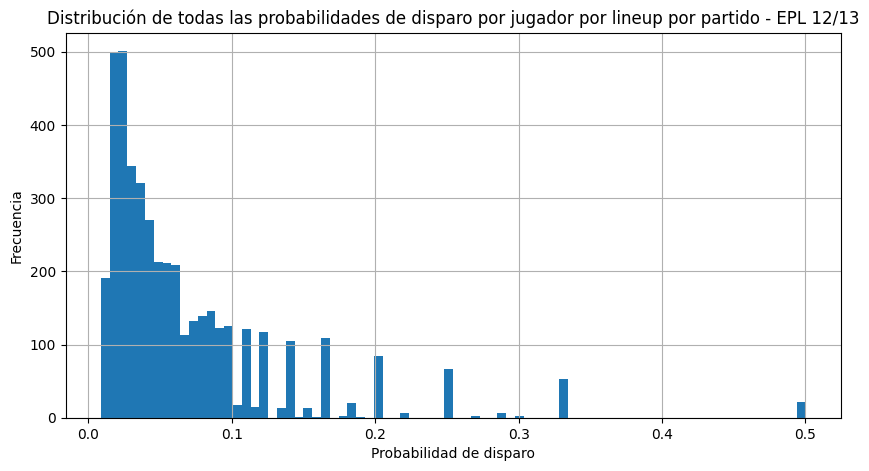

In [15]:
fig, ax = plt.subplots(figsize=(10, 5))
s_ds["shots_prob"].hist(bins=80)

# ax.set_yscale("log")

ax.set_title("Distribución de todas las probabilidades de disparo por jugador por lineup por partido - EPL 12/13")
ax.set_xlabel("Probabilidad de disparo")
ax.set_ylabel("Frecuencia")

# Save png
plt.savefig("../recursos_pdf/Probabilidad_de_disparo.png")

In [16]:
# For each player_id get the Beta Binomial Parameters for the distribution of shots_prob

from scipy.stats import beta

player_ids = s_ds["player_id"].unique()
player_params = []

for player_id in player_ids:

    player_data = s_ds[s_ds["player_id"] == player_id]
    shots = player_data[player_data["shots_prob"] > 0]["shots_prob"].values

    if len(shots) < 3:
        continue

    a, b, loc, scale = beta.fit(shots, floc=0, fscale=1)

    player_params.append(
        {
            "player_id": player_id,
            "a": a,
            "b": b,
            # "loc": loc,
            # "scale": scale,
            "count": len(shots),
        }
    )

player_params = pd.DataFrame(player_params)

In [17]:
player_params

player_id          a            b  count
0        19524   1.077226    11.111839     18
1        15943   1.244024    15.067473     15
2        20467   2.086493    45.153447     15
3        80254   1.997318    21.479373      7
4         8758   1.696920    34.485539     21
..         ...        ...          ...    ...
381      56069   1.627049    29.927401      5
382      78315   2.023608    28.583803      5
383      19838   7.681650    80.635601      3
384      16037  52.553535  1392.921991      3
385      28146   0.677754     4.623236      3

[386 rows x 4 columns]

In [18]:
from src.epl_player_data_utils import EPLPlayerData

epl_player_data = EPLPlayerData("../SampleData/players.json")
epl_player_data

EPLPlayerData(../SampleData/players.json): 804 players

In [19]:
# Ejemplo de uso
sample_player = "Sergio Agüero"
id_sample_player = epl_player_data.get_player_id_by_name(sample_player)

In [20]:
import numpy as np
from tqdm import tqdm
import pickle
from node2vec import Node2Vec
import pandas as pd

import sys

sys.path.append("../")

from src.futbol_types import TransitionMatrix
from src.utils_CTMC import build_Q, psl_estimator

In [21]:
R_storage = np.load("R_storage.npy")
R_storage.shape

(380, 2, 4, 15, 15)

In [22]:
from src.event_processing import (
    separar_partido_del_equipo_en_lineups,
    separar_partido_en_equipo_pov,
    separar_partidos,
)
from src.match_data_extraction import get_lineup_duration


partidos = separar_partidos(epl)

In [23]:
# Store the Duration of each lineup in the R_storage 0, 0

for pi, partido in enumerate(partidos):
    for ti, equipo in enumerate(separar_partido_en_equipo_pov(partido)):
        for li, lineup in enumerate(separar_partido_del_equipo_en_lineups(equipo)):
            R_storage[pi, ti, li, 0, 0] = get_lineup_duration(lineup)

### Beta-Binomial Dist over Shots Prob

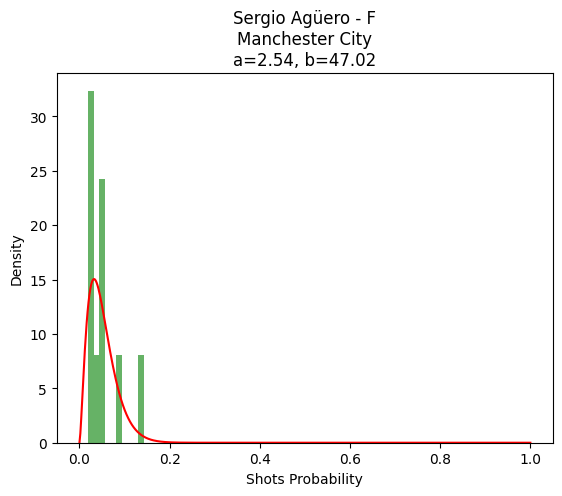

In [54]:
# Plot distribution of shots_prob for a player

import matplotlib.pyplot as plt
import seaborn as sns


def get_team_by_player_id(epl, player_id):
    filtered_epl = epl[epl["player_id"].notna()]
    filtered_epl.loc[:, "player_id"] = filtered_epl["player_id"].astype(int)

    if player_id not in filtered_epl["player_id"].values:
        return None
    # Obtener el team_id correspondiente al player_id
    team_id = filtered_epl[filtered_epl["player_id"] == player_id][
        "team_id"
    ].values[0]
    team = filtered_epl[filtered_epl["home_team_id"] == team_id][
        "home_team_name"
    ].values[0]

    return team

def plot_player_shots_prob(s_ds, player_id, ax=None, hist=True, line_alpha=1, line_color="r"):
    player_data = s_ds[s_ds["player_id"] == player_id]
    shots = player_data[player_data["shots_prob"] > 0]["shots_prob"].values
    position = epl_player_data.get_player_position(player_id)
    team = get_team_by_player_id(epl, player_id)

    if len(shots) < 3:
        return

    # Ajustar la distribución Beta a los datos de shots_prob
    a, b, loc, scale = beta.fit(shots, floc=0, fscale=1)

    if ax is None:
        fig, ax = plt.subplots()

    # Graficar el histograma de shots_prob
    if hist:
        ax.hist(shots, density=True, alpha=0.6, color="g")
        # sns.histplot(shots, kde=True, ax=ax)

    # Crear un rango de valores para la distribución Beta
    x = np.linspace(0, 1, 500)
    y = beta.pdf(x, a, b, loc, scale)

    # Superponer la distribución Beta ajustada
    ax.plot(x, y, alpha=line_alpha, color=line_color)

    ax.set_title(f"{epl_player_data.get_player_name(player_id)} - {position}\n{team}\na={a:.2f}, b={b:.2f}")

    ax.set_xlabel("Shots Probability")
    ax.set_ylabel("Density")

plot_player_shots_prob(s_ds, id_sample_player)

# Save png
plt.savefig("../recursos_pdf/graficos/Sergio_Aguero_shots_prob_beta_binomial.png")

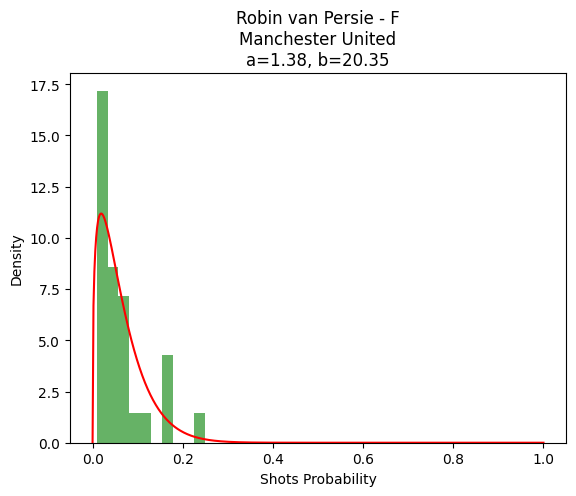

In [55]:
id_van_persie = epl_player_data.get_player_id_by_name("Robin van Persie")
plot_player_shots_prob(s_ds, id_van_persie)

# Save png
plt.savefig("../recursos_pdf/graficos/Robin_van_Persie_shots_prob_beta_binomial.png")

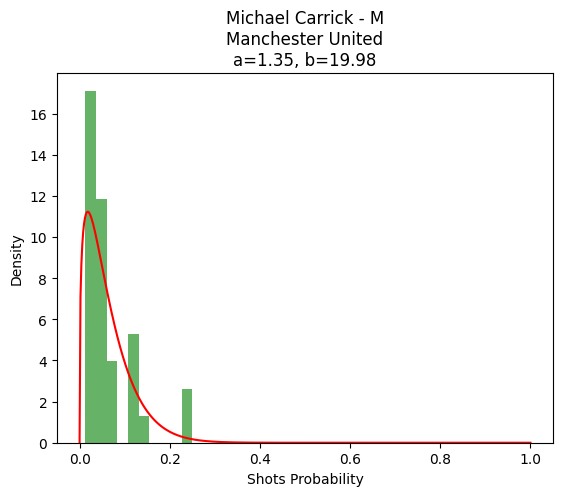

In [56]:
# Player with most appearances
most_id = s_ds["player_id"].value_counts().head(1).index[0]

plot_player_shots_prob(s_ds, most_id)

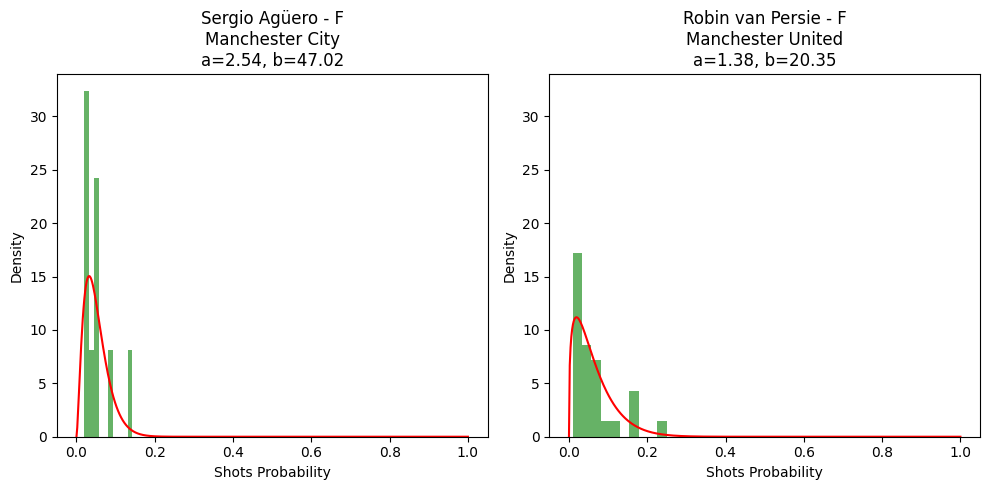

In [59]:
fig, axs = plt.subplots(1, 2, figsize=(10, 5))

plot_player_shots_prob(s_ds, id_sample_player, ax=axs[0])
plot_player_shots_prob(s_ds, id_van_persie, ax=axs[1])

# Set ylim to the max of both plots

max_y = max(axs[0].get_ylim()[1], axs[1].get_ylim()[1])

axs[0].set_ylim(0, max_y)
axs[1].set_ylim(0, max_y)

# tight_layout
plt.tight_layout()

# Save png
plt.savefig("../recursos_pdf/graficos/Sergio_Aguero_Robin_van_Persie_shots_prob_beta_binomial.png")

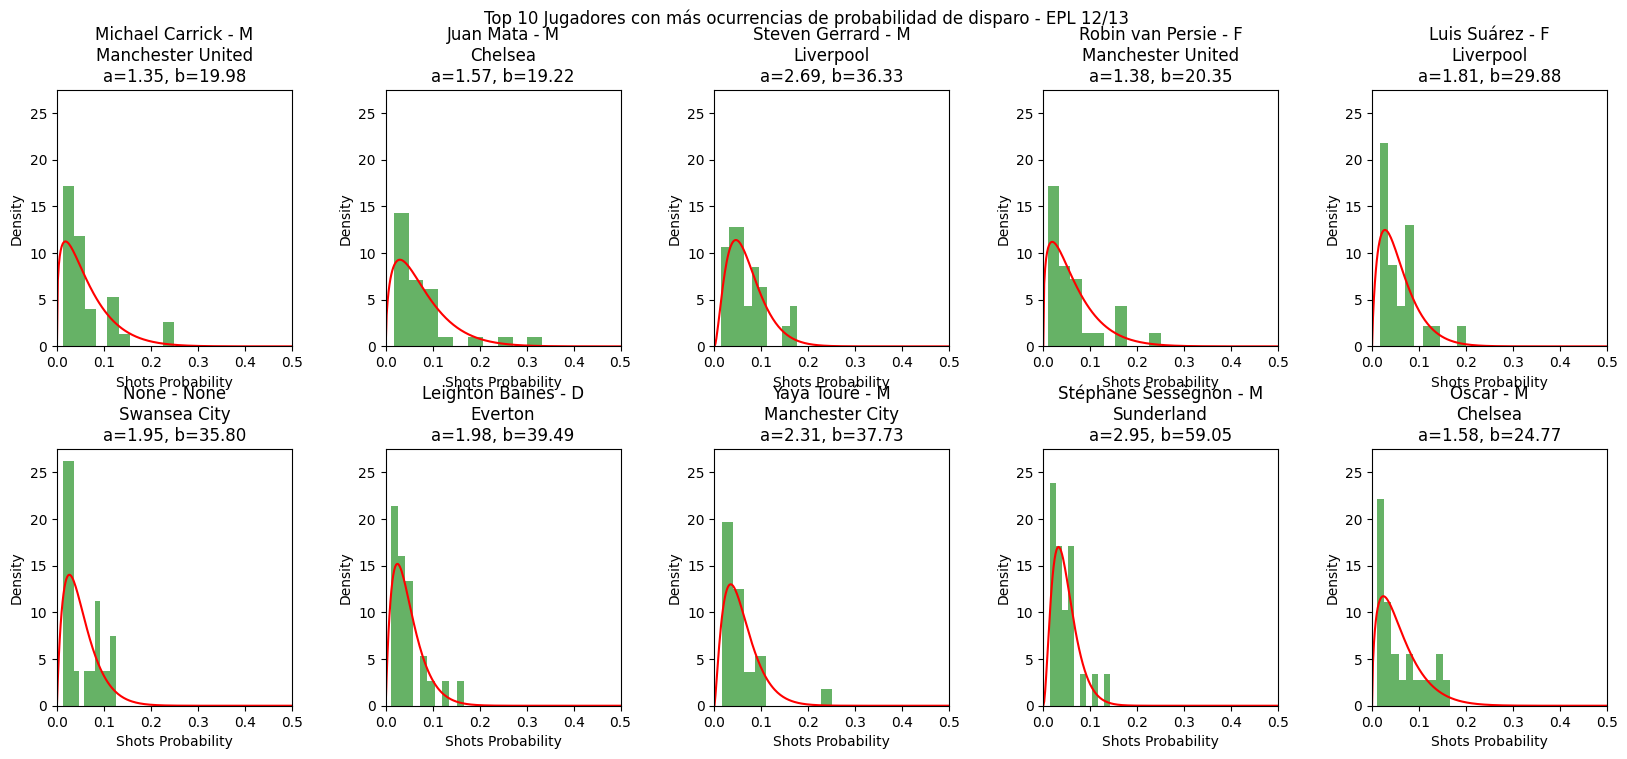

In [64]:
fig, axs = plt.subplots(2, 5, figsize=(20, 8))
top = s_ds[s_ds["player_id"] != 0]["player_id"].value_counts().head(10).index
for i, ax in enumerate(axs.flat):
    plot_player_shots_prob(s_ds, top[i], ax)
    ax.set_xlim(0, 0.5)

max_y = max([ax.get_ylim()[1] for ax in axs.flat])

for ax in axs.flat:
    ax.set_ylim(0, max_y)

plt.subplots_adjust(hspace=0.4)
plt.subplots_adjust(wspace=0.4)

fig.suptitle("Top 10 Jugadores con más ocurrencias de probabilidad de disparo - EPL 12/13")

# Save png
plt.savefig(
    "../recursos_pdf/graficos/Top_10_by_counts_players_shots_prob_beta_binomial.png"
)

In [57]:
s_ds[s_ds["player_id"] != 0].groupby("player_id")["shots_prob"].sum().sort_values(ascending=False).head(10)

player_id
43670    2.303414
39194    2.107414
18073    2.077162
58621    2.044632
19569    2.028739
2404     2.005897
1814     1.993636
18818    1.983117
37915    1.909750
12297    1.822630
Name: shots_prob, dtype: float64

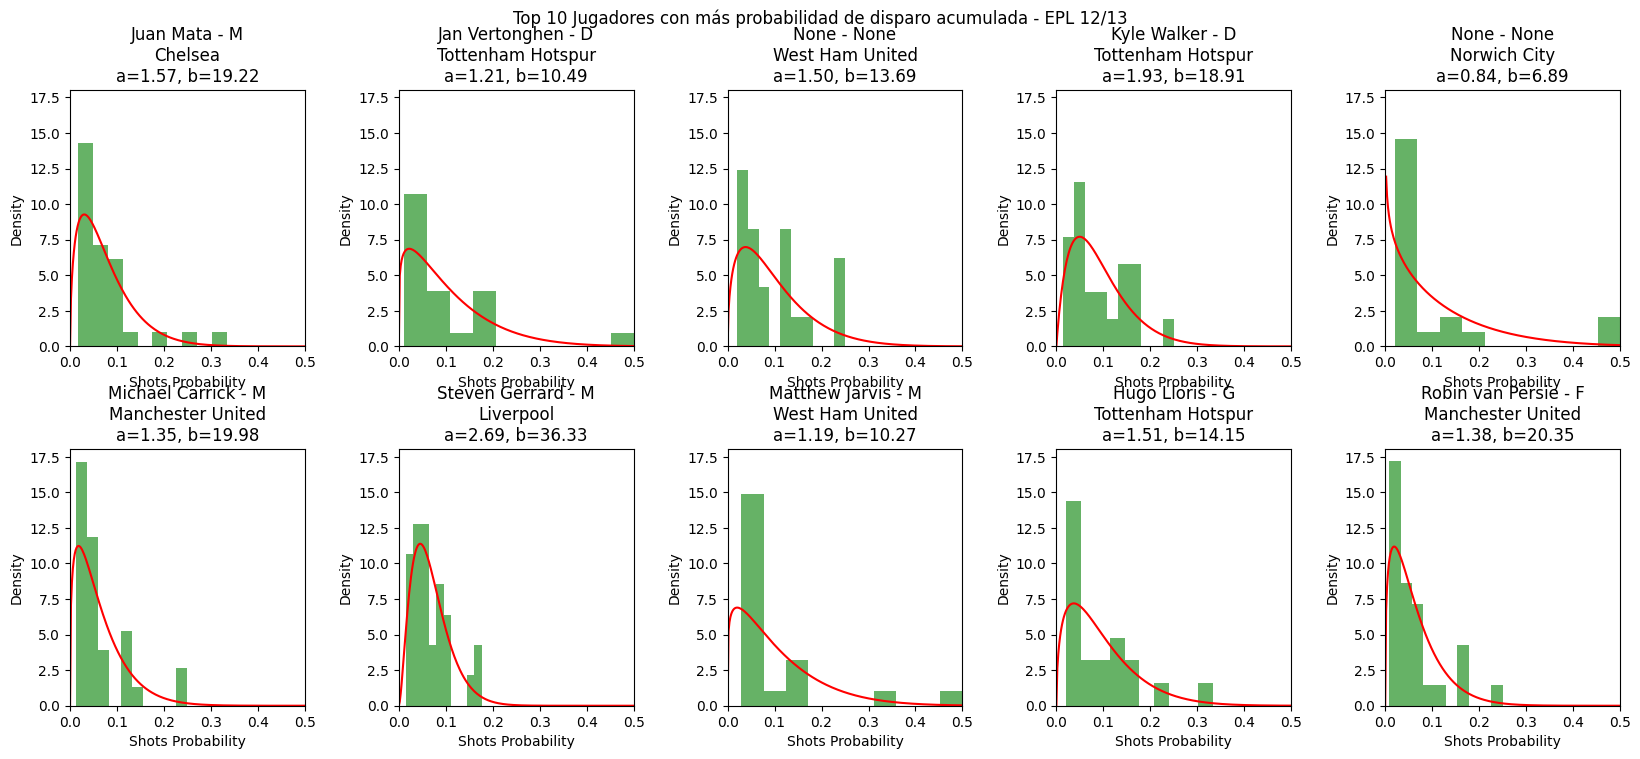

In [63]:
fig, axs = plt.subplots(2, 5, figsize=(20, 8))
# Top by sum of shots_prob
top = (
    s_ds[s_ds["player_id"] != 0]
    .groupby("player_id")["shots_prob"]
    .sum()
    .sort_values(ascending=False)
    .head(10)
    .index
)
for i, ax in enumerate(axs.flat):
    plot_player_shots_prob(s_ds, top[i], ax)
    ax.set_xlim(0, 0.5)

max_y = max([ax.get_ylim()[1] for ax in axs.flat])

for ax in axs.flat:
    ax.set_ylim(0, max_y)
    
plt.subplots_adjust(hspace=0.4)
plt.subplots_adjust(wspace=0.4)

fig.suptitle("Top 10 Jugadores con más probabilidad de disparo acumulada - EPL 12/13")

# Save png
plt.savefig("../recursos_pdf/graficos/Top_10_by_sum_players_shots_prob_beta_binomial.png")

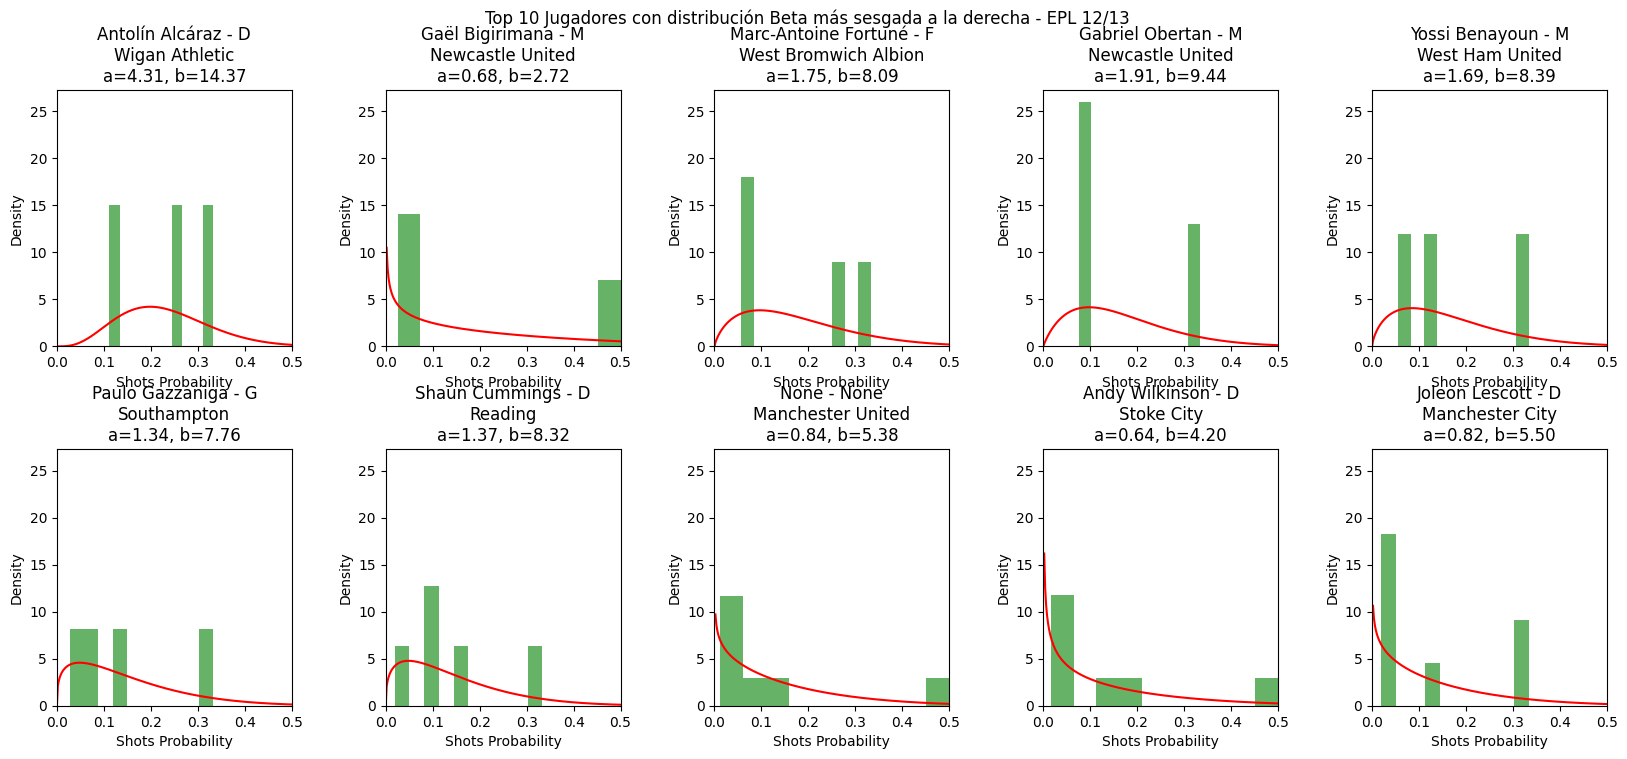

In [65]:
# Find top 10 with beta dist most skewed to the right
player_params["skew"] = player_params["a"] / (player_params["a"] + player_params["b"])
fig, axs = plt.subplots(2, 5, figsize=(20, 8))
top = (
    player_params[player_params["player_id"] != 0].sort_values("skew", ascending=False)
    .head(10)["player_id"]
)
for i, ax in enumerate(axs.flat):
    plot_player_shots_prob(s_ds, top.values[i], ax)
    ax.set_xlim(0, 0.5)

max_y = max([ax.get_ylim()[1] for ax in axs.flat])

for ax in axs.flat:
    ax.set_ylim(0, max_y)

plt.subplots_adjust(hspace=0.4)
plt.subplots_adjust(wspace=0.4)

fig.suptitle("Top 10 Jugadores con distribución Beta más sesgada a la derecha - EPL 12/13")

# Save png
plt.savefig(
    "../recursos_pdf/graficos/Top_10_by_skew_players_shots_prob_beta_binomial.png"
)

In [67]:
player_params["position"] = player_params["player_id"].apply(
    lambda x: epl_player_data.get_player_position(int(x))
)

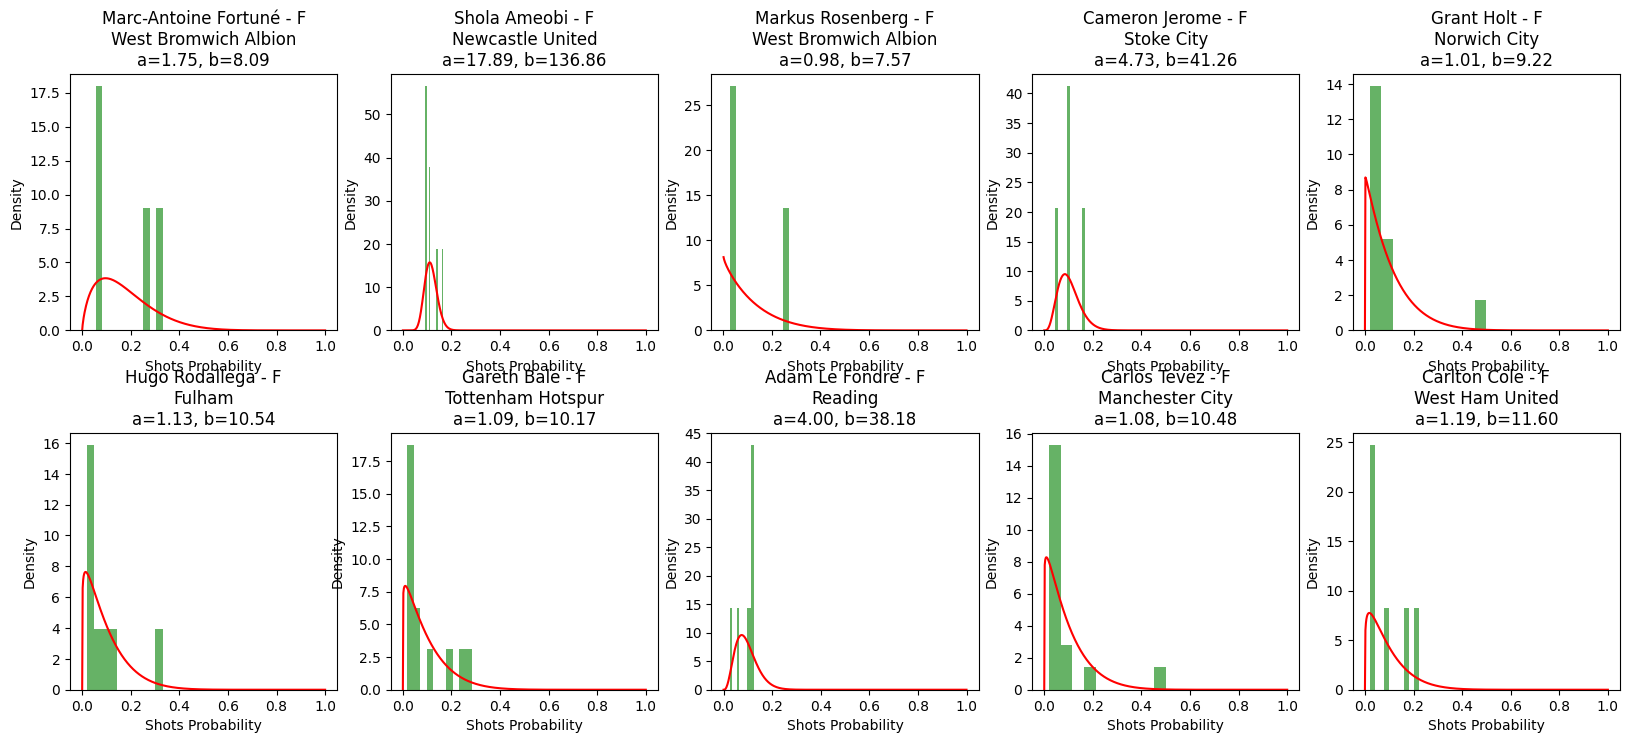

In [68]:
# Top Forwards
fig, axs = plt.subplots(2, 5, figsize=(20, 8))

top = player_params[player_params["position"] == "F"].sort_values("skew", ascending=False).head(10)["player_id"]

for i, ax in enumerate(axs.flat):
    plot_player_shots_prob(s_ds, top.values[i], ax)

plt.subplots_adjust(hspace=0.4)

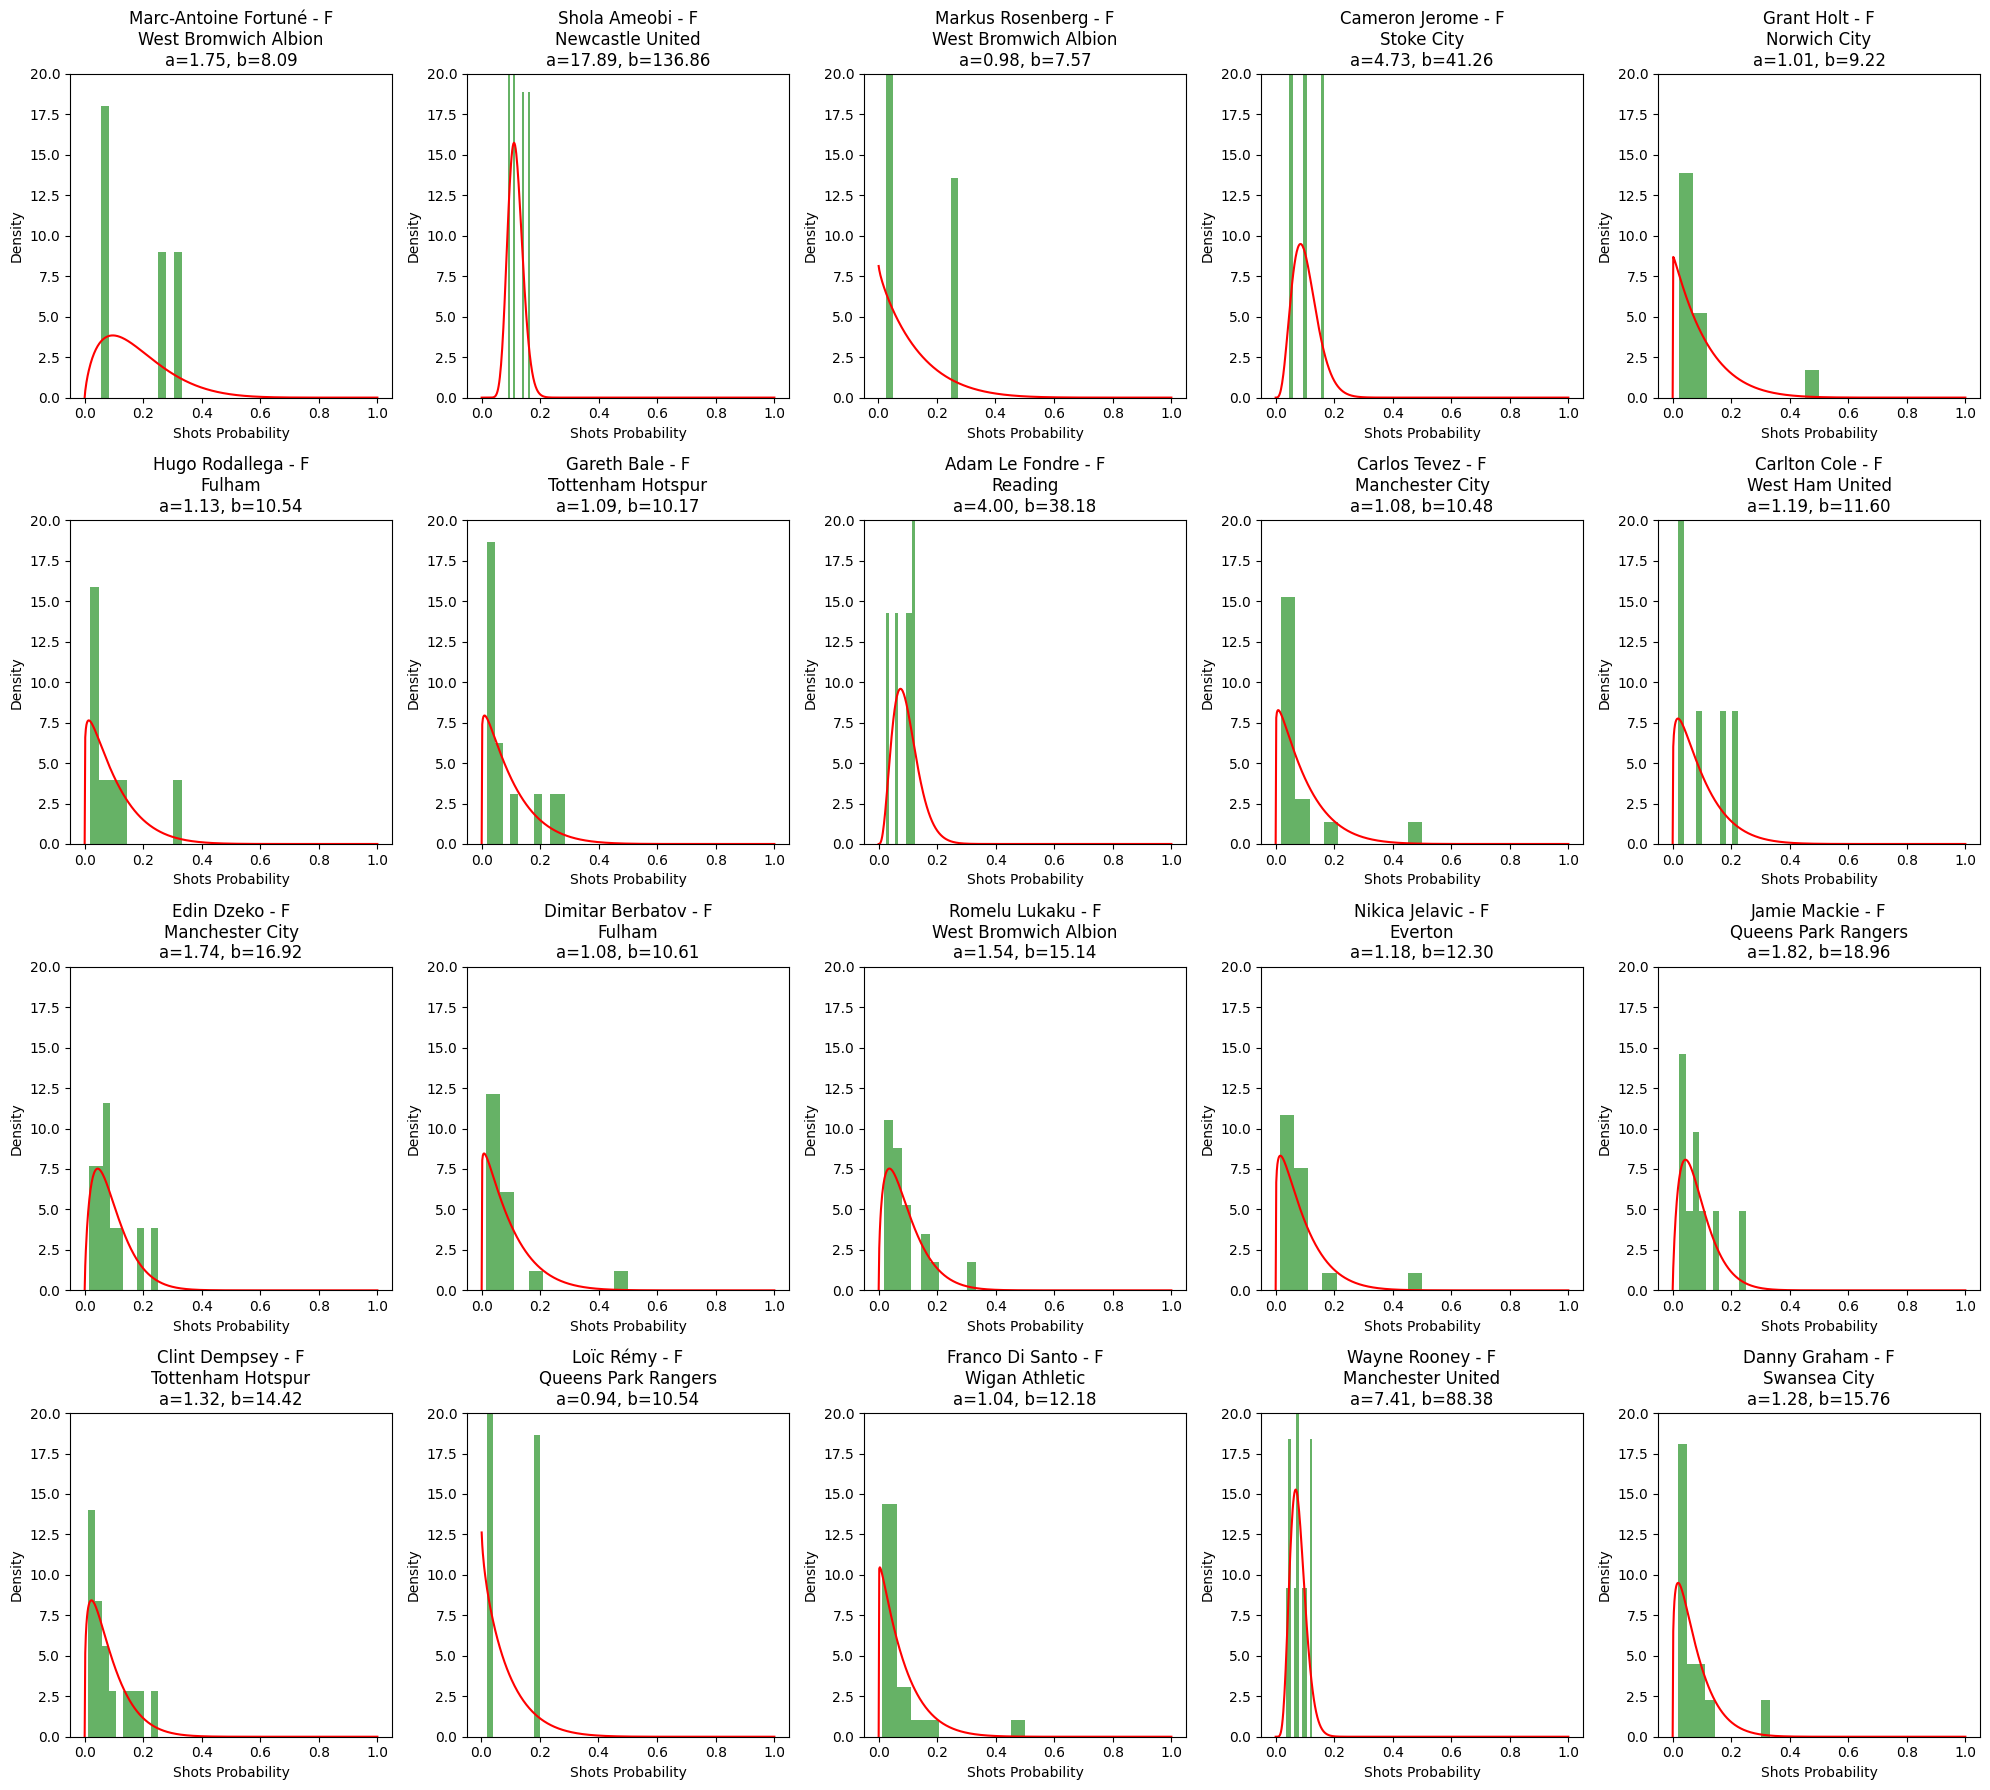

In [78]:
# Top Forwards
fig, axs = plt.subplots(4, 5, figsize=(20, 18))

top = (
    player_params[player_params["position"] == "F"]
    .sort_values("skew", ascending=False)
    .head(20)["player_id"]
)

for i, ax in enumerate(axs.flat):
    plot_player_shots_prob(s_ds, top.values[i], ax)

# max_y = max([ax.get_ylim()[1] for ax in axs.flat])
max_y = 20

for ax in axs.flat:
    ax.set_ylim(0, max_y)

plt.subplots_adjust(hspace=0.4)

# fig.suptitle("Top 20 Delanteros con distribución Beta más sesgada a la derecha - EPL 12/13")

# Tight layout
plt.tight_layout()

# Save png
plt.savefig(
    "../recursos_pdf/graficos/Top_20_Forwards_by_skew_players_shots_prob_beta_binomial.png"
)

In [105]:
s_ds["position"] = s_ds["player_id"].apply(
    lambda x: epl_player_data.get_player_position(int(x))
)

/var/folders/5j/7b3w3dw95qdcll87vxc3yn300000gn/T/ipykernel_19100/711550679.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  s_ds["position"] = s_ds["player_id"].apply(


19556 David Jones D 0.00046040059121303656
78091 Gastón Ramírez M 0.0007322132763427358
19534 Javi García M 0.001162132527675247
28491 Ali Al Habsi G 0.0016331123999858421
15976 Jos Hooiveld D 0.0021446880972890714
43191 Lucas Leiva M 0.002198328235607519
8378 Leon Osman M 0.0022254406020906226
19419 Gary Cahill D 0.0026782084631185032
54102 Jack Wilshere M 0.00398137241331431
3736 John O'Shea D 0.005695317892845296


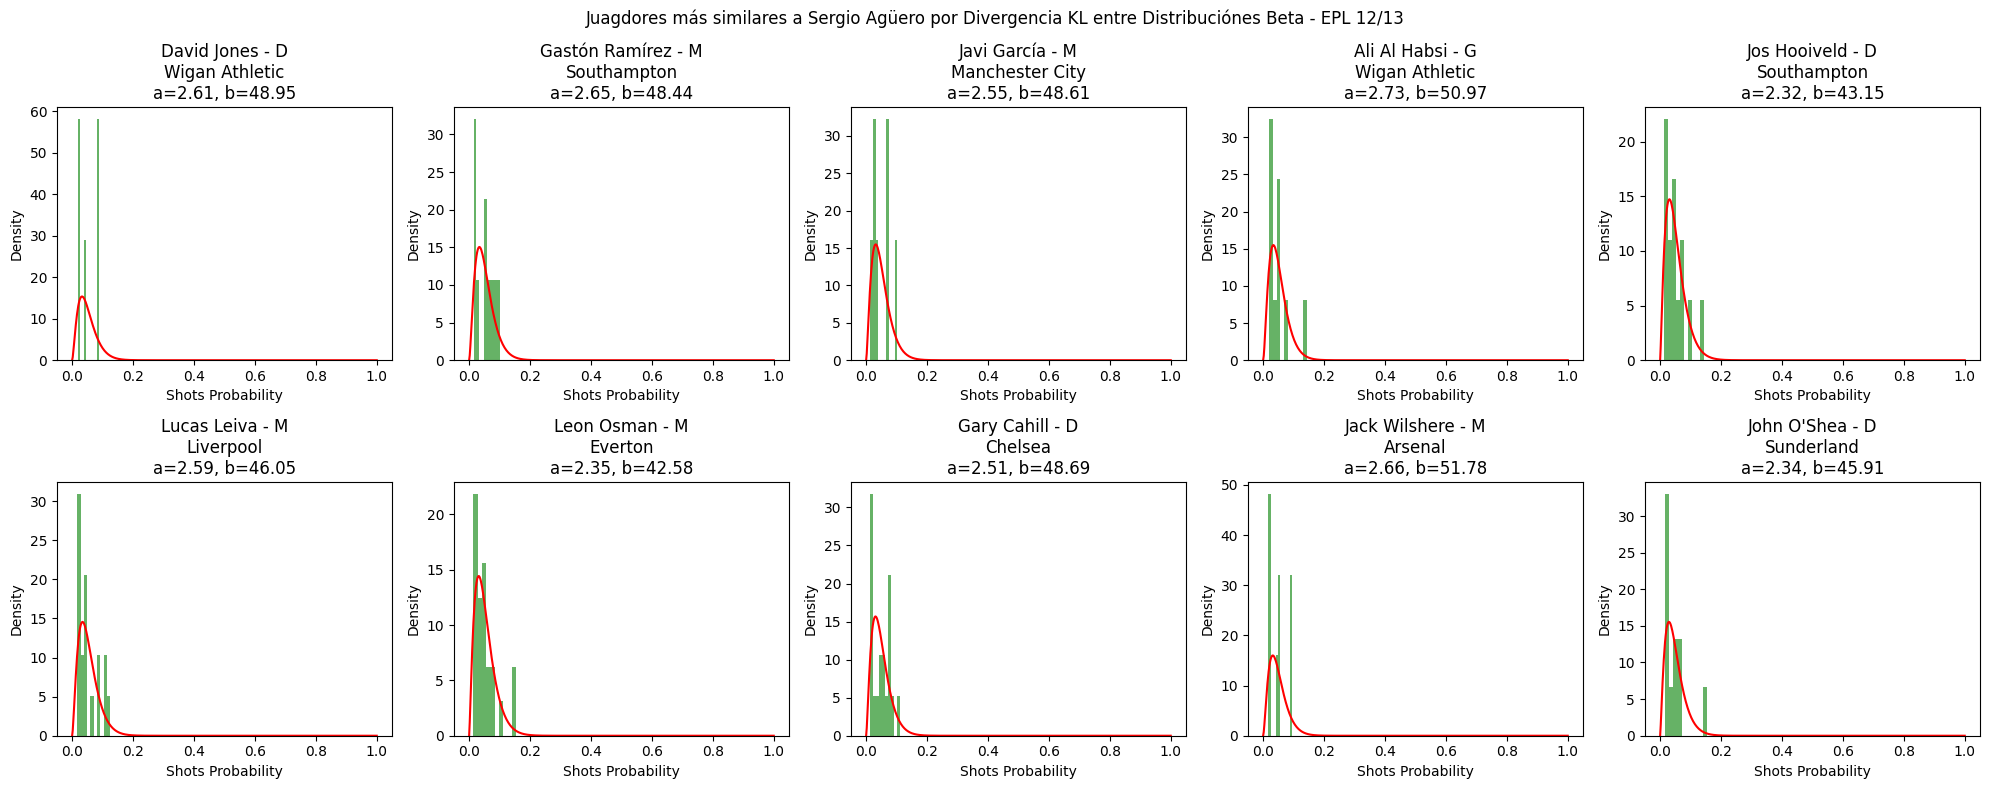

In [119]:
from scipy.special import betaln, psi


def get_beta_binom_params(s_ds):
    player_ids = s_ds["player_id"].unique()
    player_params = []

    for player_id in player_ids:
        player_data = s_ds[s_ds["player_id"] == player_id]
        shots = player_data[player_data["shots_prob"] > 0]["shots_prob"].values

        if len(shots) < 3:
            continue

        a, b, loc, scale = beta.fit(shots, floc=0, fscale=1)

        player_params.append(
            {
                "player_id": player_id,
                "a": a,
                "b": b,
                "count": len(shots),
            }
        )

    return pd.DataFrame(player_params)


def kl_divergence_beta(a1, b1, a2, b2):
    # Fórmula de la divergencia KL para distribuciones Beta

    # D_kl(P || Q) = Sum P(x) * log(P(x) / Q(x))

    # return sum(
    #     beta.pdf(x, a1, b1) * np.log(beta.pdf(x, a1, b1) / (beta.pdf(x, a2, b2) + 1e-10))
    #     for x in np.linspace(0, 1, 500)
    # )

    return (
        betaln(a2, b2)
        - betaln(a1, b1)
        + (a1 - a2) * (psi(a1) - psi(a1 + b1))
        + (b1 - b2) * (psi(b1) - psi(a1 + b1))
    )


def find_similar_players(s_ds, target_player_id, same_position=False):
    player_params = get_beta_binom_params(s_ds)
    player_params["position"] = player_params["player_id"].apply(
        lambda x: epl_player_data.get_player_position(int(x))
    )

    target_params = player_params[player_params["player_id"] == target_player_id].iloc[
        0
    ]

    if same_position:
        target_position = s_ds[s_ds["player_id"] == target_player_id][
            "position"
        ].values[0]
        player_params = player_params[player_params["position"] == target_position]

    distances = []
    for _, row in player_params.iterrows():
        if row["player_id"] == target_player_id:
            continue
        dist = kl_divergence_beta(
            target_params["a"], target_params["b"], row["a"], row["b"]
        )
        distances.append((row["player_id"], dist))

    distances.sort(key=lambda x: x[1])
    return distances



similar_players = find_similar_players(s_ds, id_sample_player)

for player_id, dist in similar_players[:10]:
    print(
        player_id,
        epl_player_data.get_player_name(int(player_id)),
        epl_player_data.get_player_position(int(player_id)),
        dist,
    )

fig, axs = plt.subplots(2, 5, figsize=(20, 8))
top = [int(x[0]) for x in similar_players[:10]]
for i, ax in enumerate(axs.flat):
    plot_player_shots_prob(s_ds, top[i], ax)

plt.subplots_adjust(hspace=0.4)

fig.suptitle(f"Juagdores más similares a {epl_player_data.get_player_name(id_sample_player)} por Divergencia KL entre Distribuciónes Beta - EPL 12/13")

# Tight layout
plt.tight_layout()

# Save png
plt.savefig(
    "../recursos_pdf/graficos/Similar_to_Sergio_Aguero_shots_prob_beta_binomial.png"
)

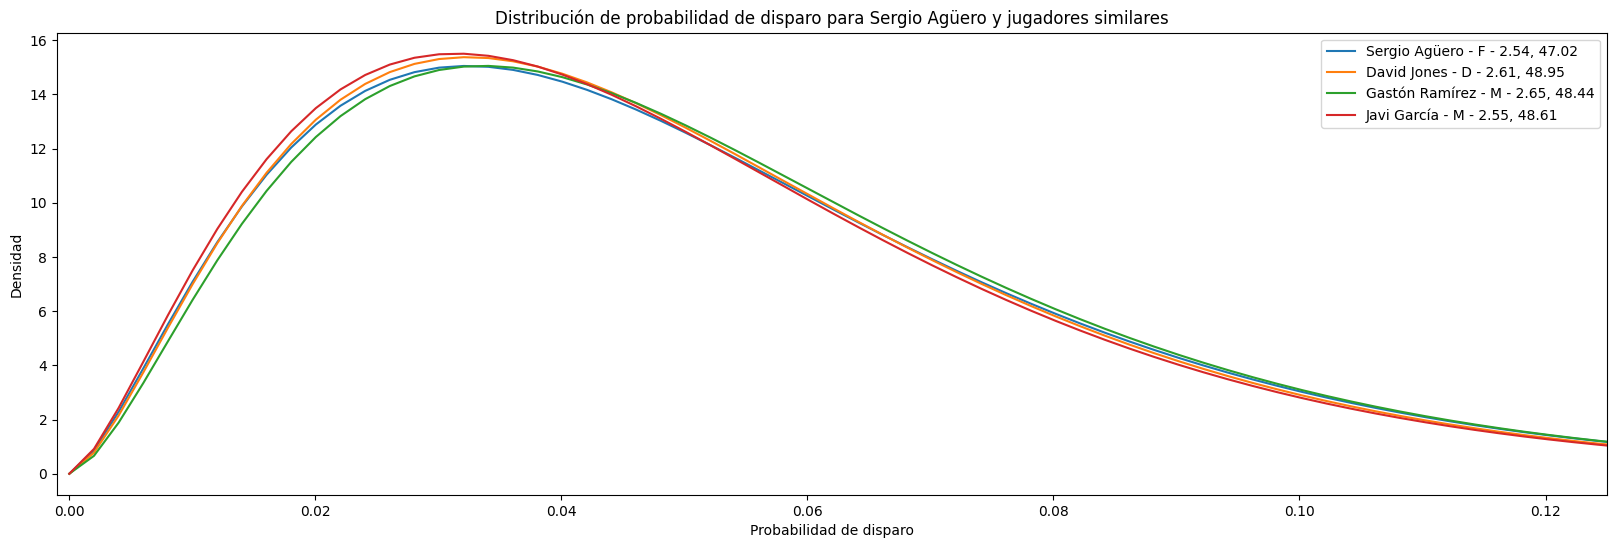

In [120]:
# Plot overlayed shots_prob for similar players

fig, ax = plt.subplots(figsize=(20, 6))

for player_id, _ in [(id_sample_player, None)] + similar_players[:3]:

    player_data = s_ds[s_ds["player_id"] == int(player_id)]
    shots = player_data[player_data["shots_prob"] > 0]["shots_prob"].values

    a, b, loc, scale = beta.fit(shots, floc=0, fscale=1)

    x = np.linspace(0, 1, 500)
    y = beta.pdf(x, a, b, loc, scale)

    ax.plot(x, y, label=f"{epl_player_data.get_player_name(int(player_id))} - {epl_player_data.get_player_position(int(player_id))} - {a:.2f}, {b:.2f}")

ax.legend()
ax.set_xlim(-0.001, 0.125)

ax.set_title(f"Distribución de probabilidad de disparo para {sample_player} y jugadores similares")
ax.set_xlabel("Probabilidad de disparo")
ax.set_ylabel("Densidad")

# Save png
plt.savefig(
    "../recursos_pdf/graficos/Sergio_Aguero_and_similar_players_shots_prob_beta_binomial.png"
)


4570 Bobby Zamora F 0.00651507148624933
43274 Gervinho F 0.006722609403886443
103955 Raheem Sterling F 0.01597415364611983
59125 Connor Wickham F 0.022413184271040693
14402 Fernando Torres F 0.023954412914340972
42758 Papiss Cissé F 0.02502238624020304
40755 Daniel Sturridge F 0.030415766487300933
20467 Theo Walcott F 0.035441659488541305
39336 Luis Suárez F 0.04154077601240891
20452 Shane Long F 0.04323022819169342


Text(0.5, 0.98, 'Players similar to Sergio Agüero in the same position')

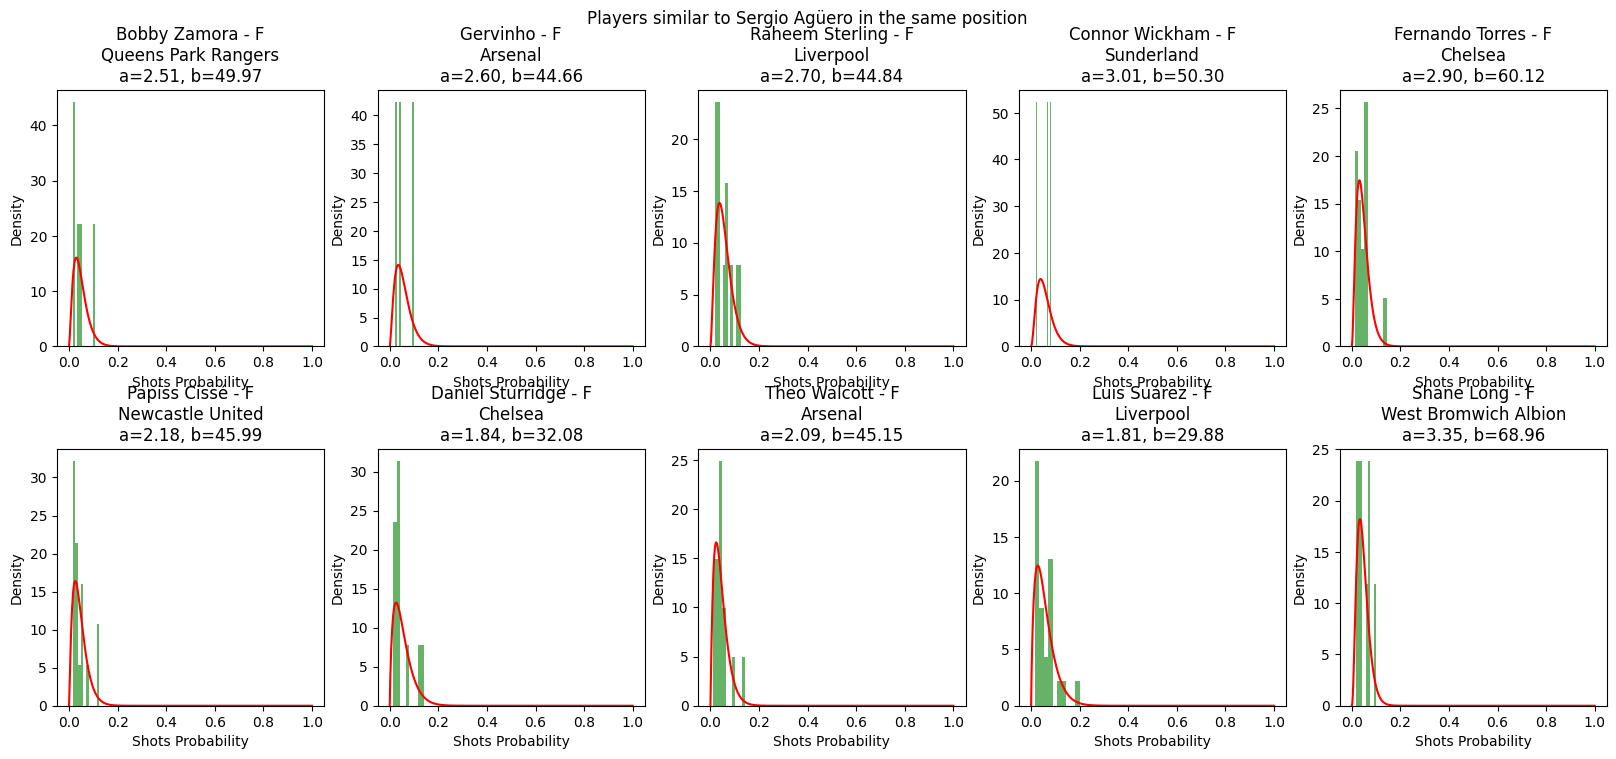

In [114]:
# Same position
similar_players = find_similar_players(s_ds, id_sample_player, same_position=True)

for player_id, dist in similar_players[:10]:
    print(
        player_id,
        epl_player_data.get_player_name(int(player_id)),
        epl_player_data.get_player_position(int(player_id)),
        dist,
    )

fig, axs = plt.subplots(2, 5, figsize=(20, 8))
top = [int(x[0]) for x in similar_players[:10]]

# Get max shots_prob for all players and adjust the x-axis
max_shots_prob = s_ds["shots_prob"].max()

for i, ax in enumerate(axs.flat):
    plot_player_shots_prob(s_ds, top[i], ax)

    # ax.set_xlim(-0.001, max_shots_prob * 1.1)

plt.subplots_adjust(hspace=0.4)
fig.suptitle(f"Players similar to {sample_player} in the same position")

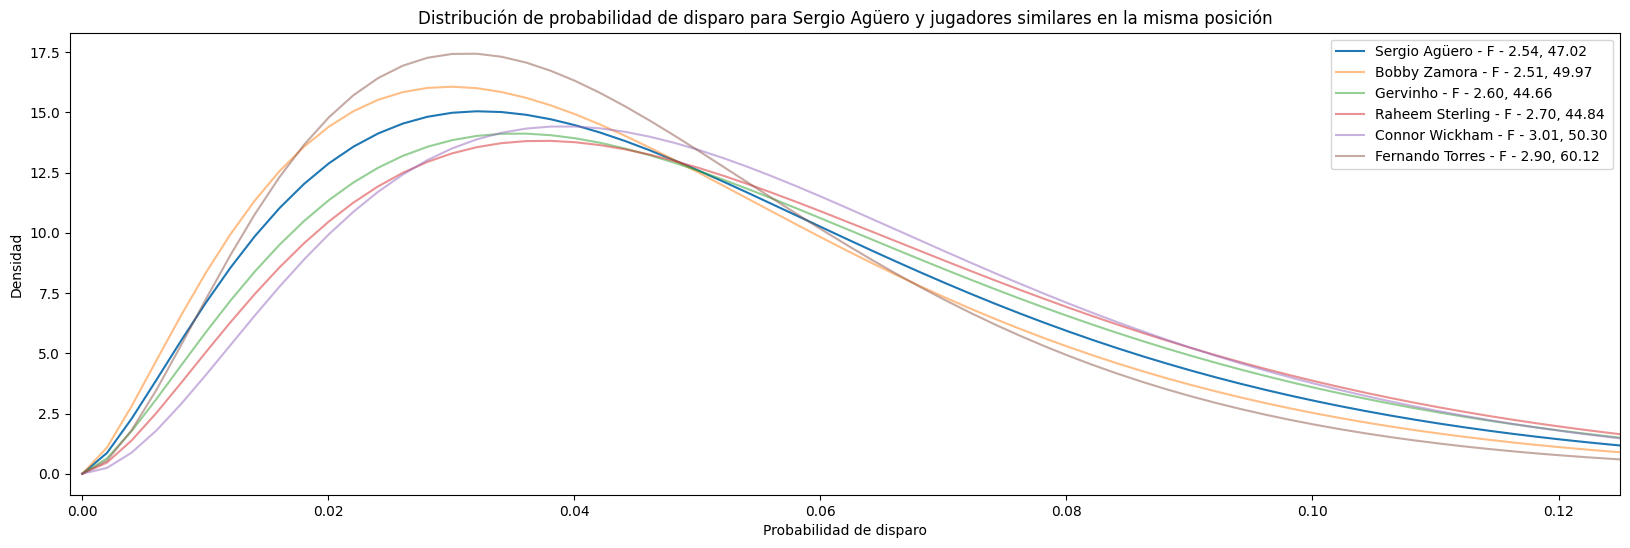

In [115]:
fig, ax = plt.subplots(figsize=(20, 6))

for i, data in enumerate([(id_sample_player, None)] + similar_players[:5]):
    player_id, _ = data
    player_data = s_ds[s_ds["player_id"] == int(player_id)]
    shots = player_data[player_data["shots_prob"] > 0]["shots_prob"].values

    a, b, loc, scale = beta.fit(shots, floc=0, fscale=1)

    x = np.linspace(0, 1, 500)
    y = beta.pdf(x, a, b, loc, scale)

    alpha = 1 if i == 0 else 0.5
    ax.plot(
        x,
        y,
        alpha=alpha,
        label=f"{epl_player_data.get_player_name(int(player_id))} - {epl_player_data.get_player_position(int(player_id))} - {a:.2f}, {b:.2f}",
    )

ax.legend()

ax.set_xlim(-0.001, 0.125)


ax.set_title(f"Distribución de probabilidad de disparo para {sample_player} y jugadores similares en la misma posición")
ax.set_xlabel("Probabilidad de disparo")
ax.set_ylabel("Densidad")

# Save png
plt.savefig(
    "../recursos_pdf/graficos/Sergio_Aguero_and_similar_players_same_position_shots_prob_beta_binomial.png"
)

In [106]:
s_ds = s_ds[s_ds["position"].apply(lambda x: x in ["F", "M", "D", "G"])]

16037 Tal Ben Haim D 12.806917610844039
6240 Shola Ameobi F 7.083648364555886
43035 Antolín Alcáraz D 3.6305786195985634
55909 Chris Smalling D 3.2266436571886885
45268 Moussa Sissoko M 3.1525690905914345
43020 Chicharito F 2.75115986357466
19236 John Ruddy G 2.5421623869934162
61538 Callum McManaman M 1.8667343843362643
39221 Dwight Tiendalli D 1.5556557635629185
78270 Hope Akpan M 1.5487231154100833


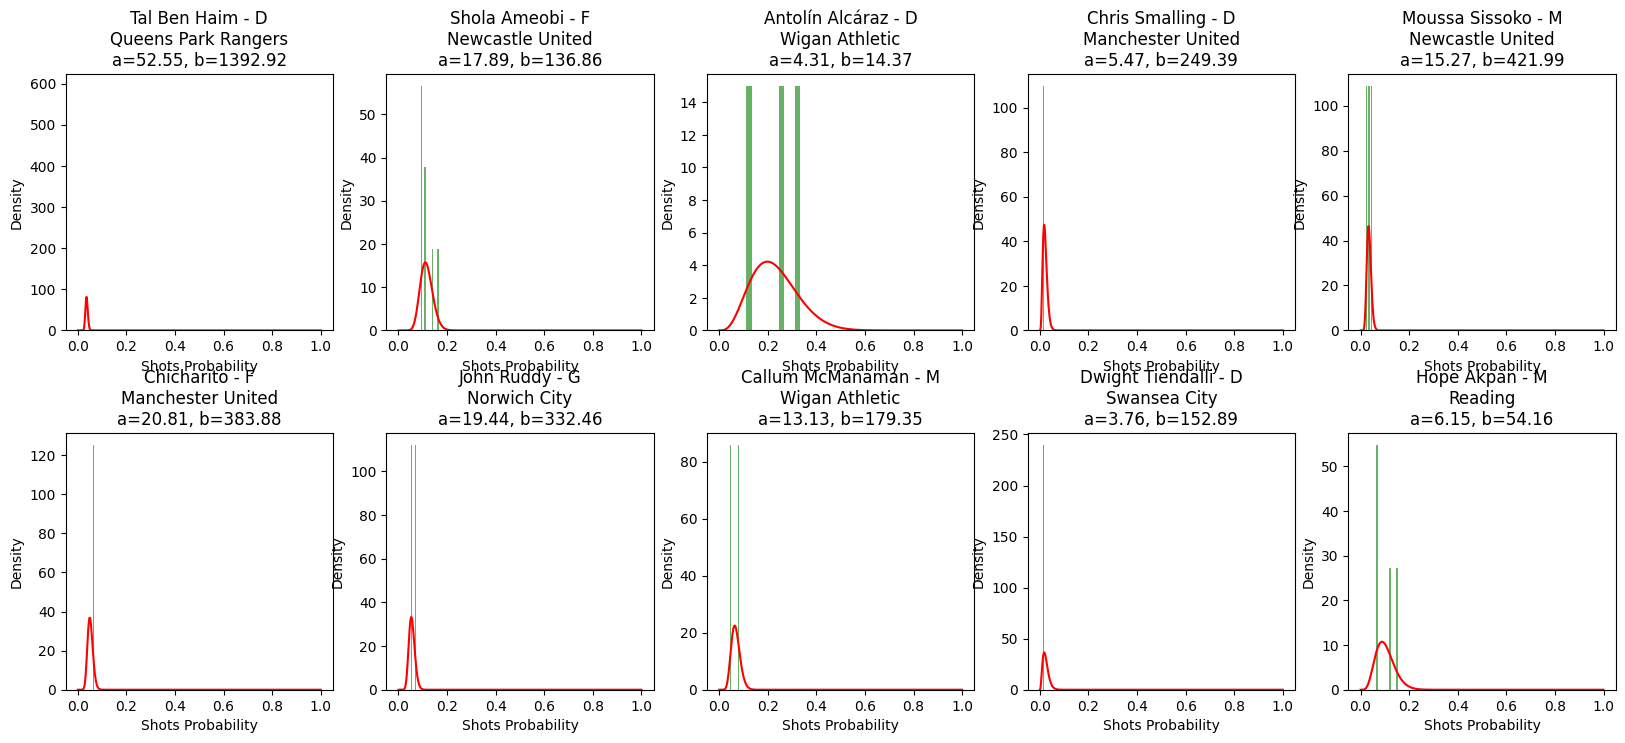

In [107]:
# Find most dissimilar player

def find_dissimilar_players(s_ds, target_player_id, same_position=False):
    return find_similar_players(s_ds, target_player_id, same_position=False)[::-1]

# Plot most dissimilar player to sample player
dissimilar_players = find_dissimilar_players(s_ds, id_sample_player)

for player_id, dist in dissimilar_players[:10]:
    print(
        player_id,
        epl_player_data.get_player_name(int(player_id)),
        epl_player_data.get_player_position(int(player_id)),
        dist,
    )

fig, axs = plt.subplots(2, 5, figsize=(20, 8))
top = [int(x[0]) for x in dissimilar_players[:10]]
for i, ax in enumerate(axs.flat):
    plot_player_shots_prob(s_ds, top[i], ax)

plt.subplots_adjust(hspace=0.4)

(-0.001, 0.2)

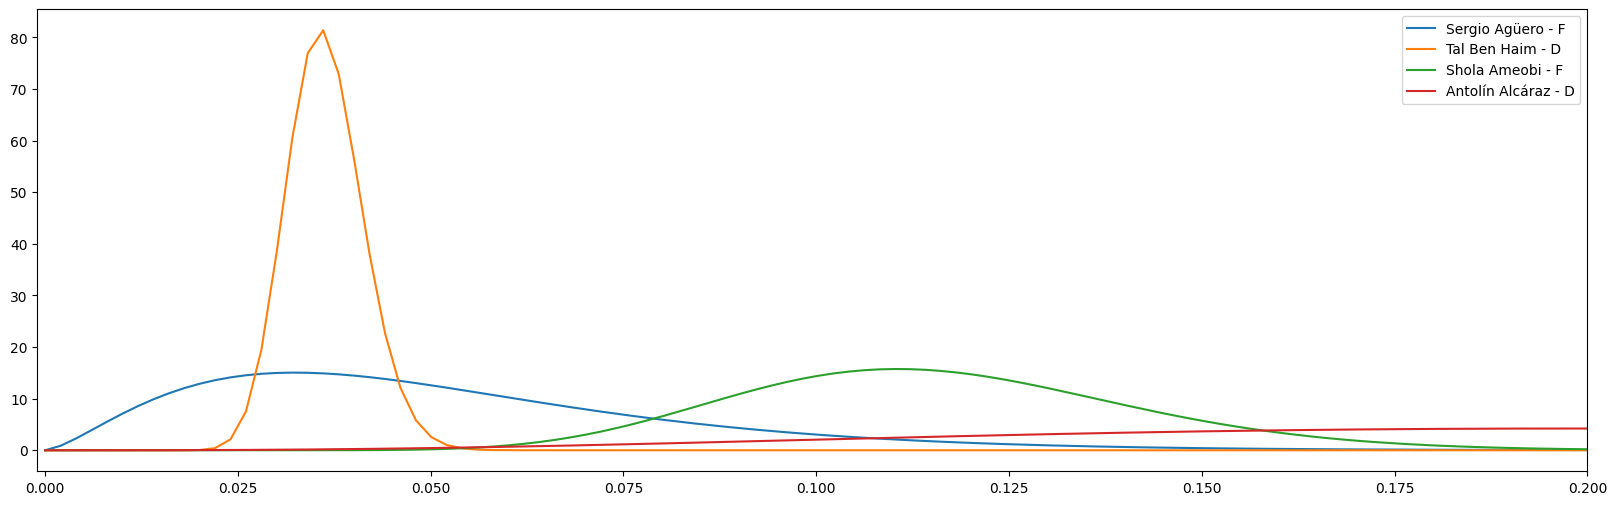

In [84]:
fig, ax = plt.subplots(figsize=(20, 6))

for player_id, _ in [(id_sample_player, None)] + dissimilar_players[:3]:

    player_data = s_ds[s_ds["player_id"] == int(player_id)]
    shots = player_data[player_data["shots_prob"] > 0]["shots_prob"].values

    a, b, loc, scale = beta.fit(shots, floc=0, fscale=1)

    x = np.linspace(0, 1, 500)
    y = beta.pdf(x, a, b, loc, scale)

    ax.plot(x, y, label=f"{epl_player_data.get_player_name(int(player_id))} - {epl_player_data.get_player_position(int(player_id))}")

ax.legend()

ax.set_xlim(-0.001, 0.2)

Text(0.5, 1.0, 'Clusters of Players based on shots_prob Beta Distribution')

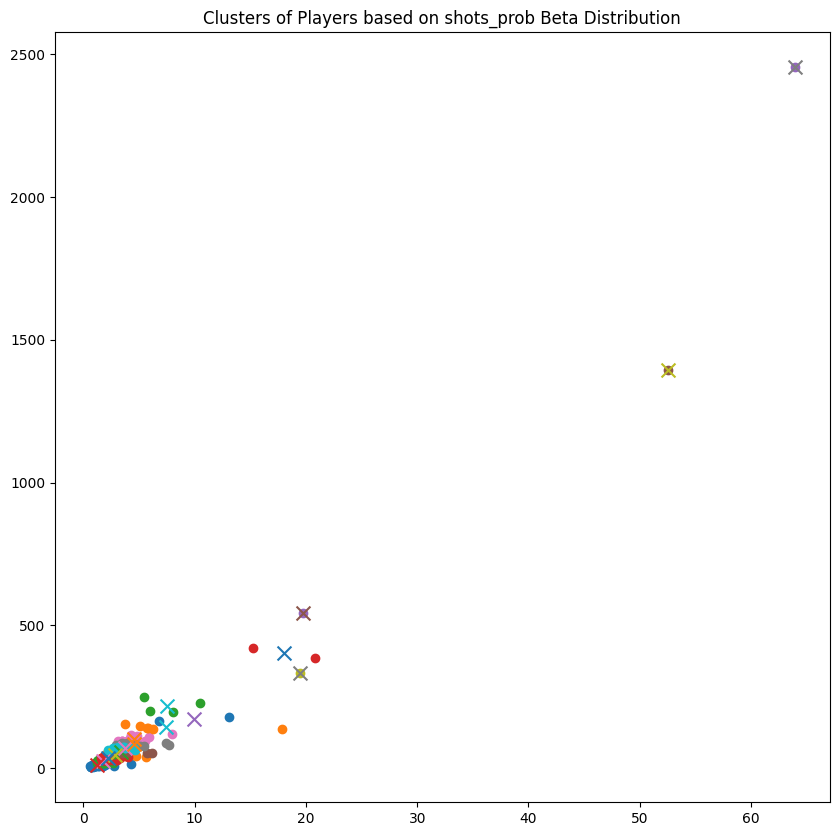

In [87]:
# Clustering the players distributions of shots_prob

from sklearn.cluster import KMeans

# player_params.columns => Index(['player_id', 'a', 'b', 'count', 'skew', 'position'], dtype='object')

X = player_params[["a", "b"]].values
n_clusters = 16
kmeans = KMeans(n_clusters=n_clusters, random_state=0).fit(X)

player_params["cluster"] = kmeans.labels_

# Plot the clusters
fig, ax = plt.subplots(figsize=(10, 10))

for cluster in player_params["cluster"].unique():
    cluster_data = player_params[player_params["cluster"] == cluster]
    ax.scatter(cluster_data["a"], cluster_data["b"], label=f"Cluster {cluster}")

# Plot the centroids
centroids = kmeans.cluster_centers_
for i, centroid in enumerate(centroids):
    ax.scatter(centroid[0], centroid[1], s=100, label=f"Centroid {i}", marker="x")

ax.set_title("Clusters of Players based on shots_prob Beta Distribution")

Text(0.5, 1.0, 'Shape of the centroids of the clusters')

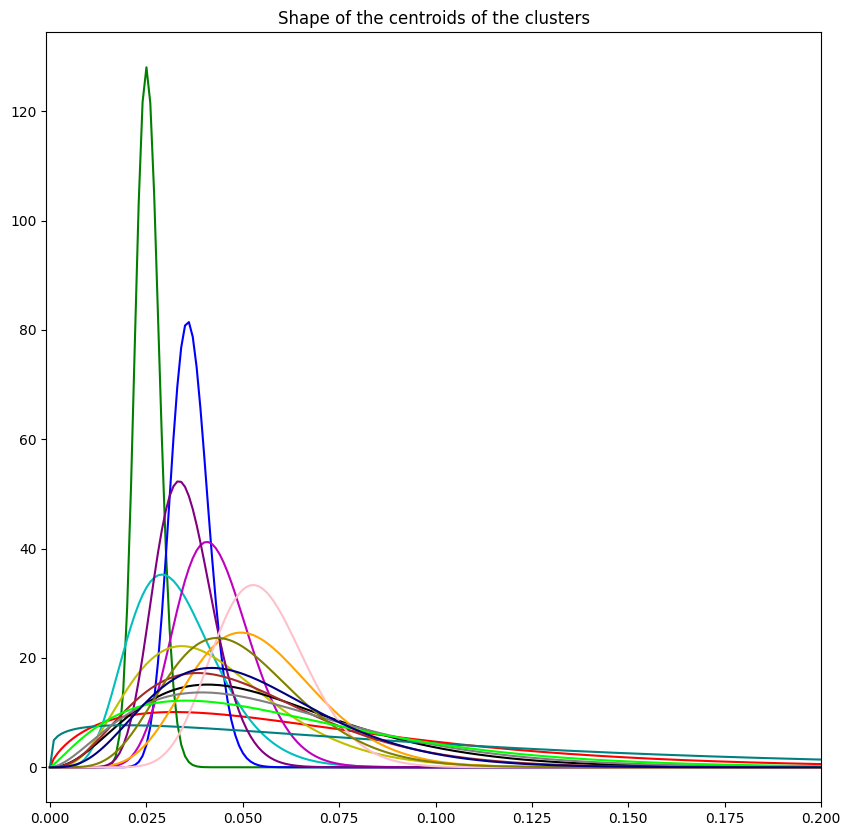

In [91]:
# Plot the shape of the centroids

fig, ax = plt.subplots(figsize=(10, 10))
colors = ["r", "g", "b", "c", "m", "y", "k", "teal", "orange", "purple", "brown", "pink", "gray", "olive", "lime", "navy"]

for i, centroid in enumerate(centroids):
    x = np.linspace(0, 1, 1000)
    y = beta.pdf(x, centroid[0], centroid[1])
    ax.plot(x, y, label=f"Centroid {i}", color=colors[i])

ax.set_xlim(-0.001, 0.2)

ax.set_title("Shape of the centroids of the clusters")

Text(0, 0.5, 'b')

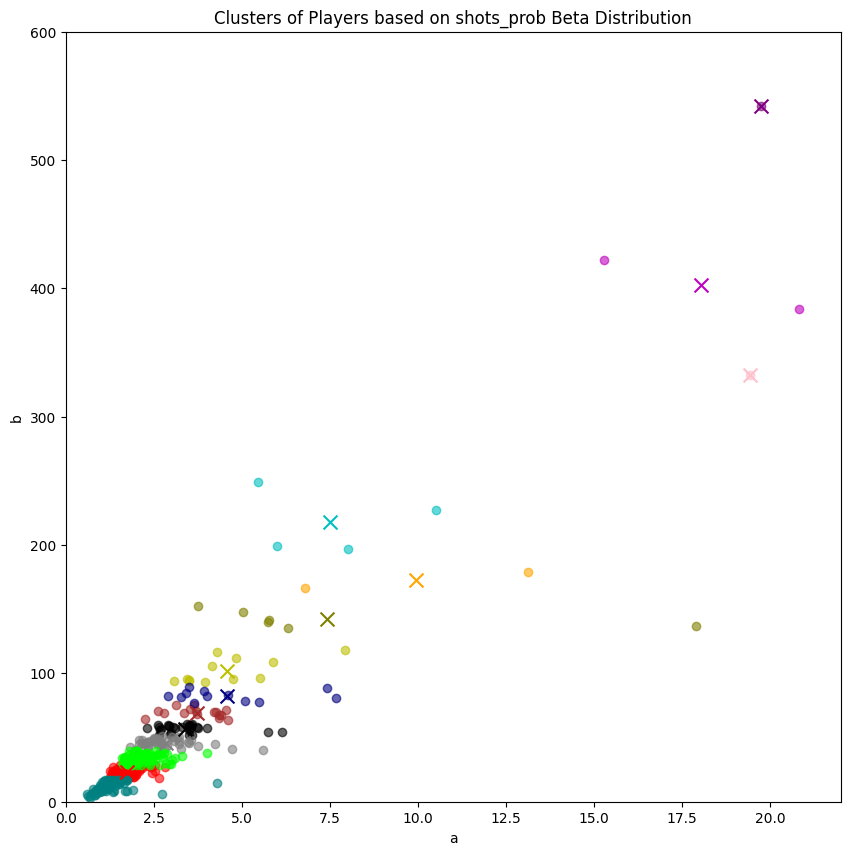

In [92]:
# Plot the clusters
fig, ax = plt.subplots(figsize=(10, 10))

for i, centroid in enumerate(centroids):
    # Get cluster data from centroid
    cluster = i
    cluster_data = player_params[player_params["cluster"] == cluster]
    ax.scatter(cluster_data["a"], cluster_data["b"], label=f"Cluster {cluster}", color=colors[i], alpha=0.6)

# Plot the centroids
centroids = kmeans.cluster_centers_
for i, centroid in enumerate(centroids):
    ax.scatter(centroid[0], centroid[1], s=100, label=f"Centroid {i}", marker="x", color=colors[i])


ax.set_xlim(-0.001, 22)
ax.set_ylim(-0.001, 600)
ax.set_title("Clusters of Players based on shots_prob Beta Distribution")

ax.set_xlabel("a")
ax.set_ylabel("b")

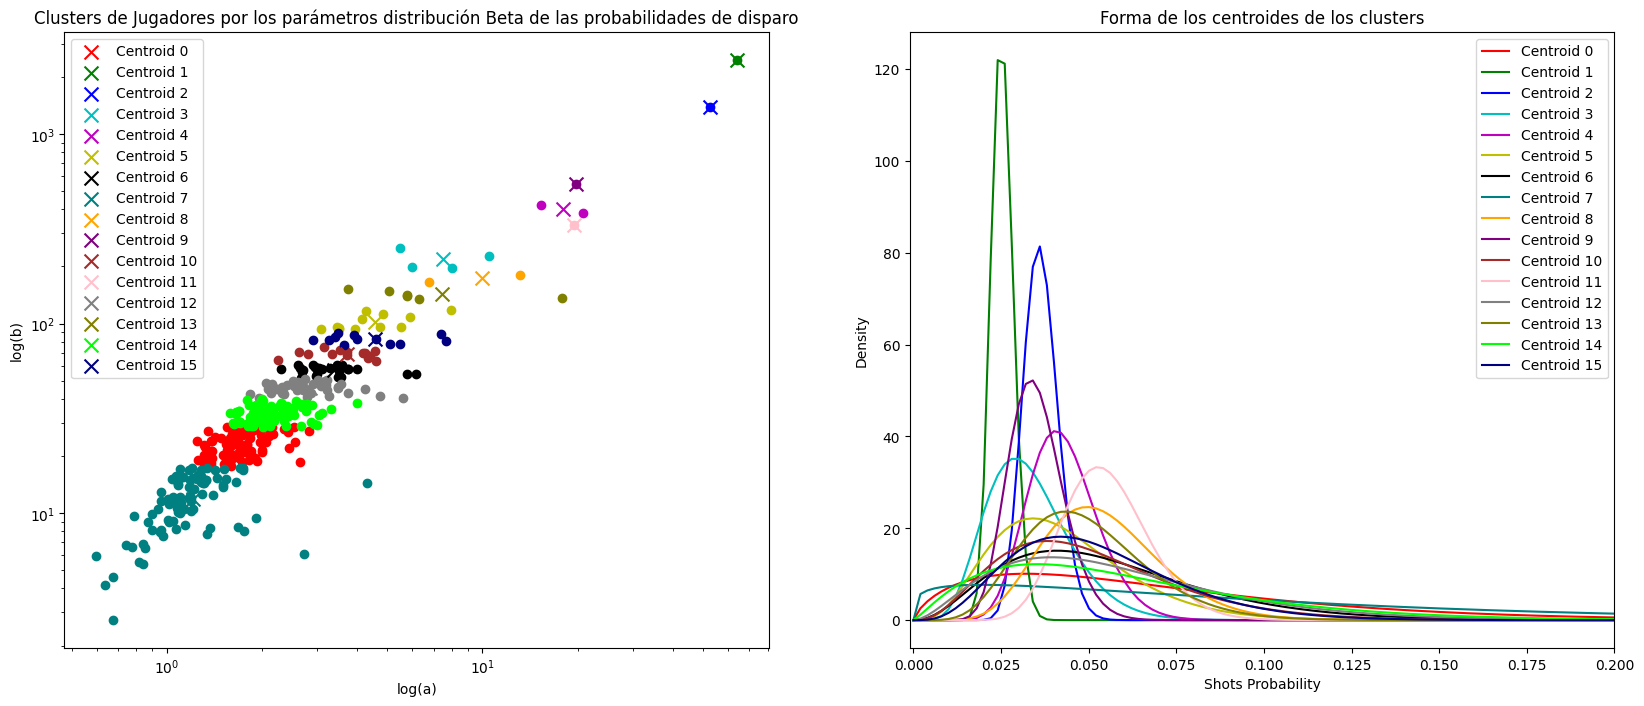

In [110]:
fig, axs = plt.subplots(1, 2, figsize=(20, 8))

centroids = kmeans.cluster_centers_

# Definir los colores
# colors = plt.cm.tab10(np.linspace(0, 1, len(player_params["cluster"].unique())))

# Plot the clusters
# for i, cluster in enumerate(player_params["cluster"].unique()):
for i, centroid in enumerate(centroids):
    # Get cluster data from centroid
    cluster = i
    cluster_data = player_params[player_params["cluster"] == cluster]
    axs[0].scatter(
        cluster_data["a"],
        cluster_data["b"],
        # label=f"Cluster {cluster}",
        color=colors[i],
    )

# Plot the centroids
for i, centroid in enumerate(centroids):
    axs[0].scatter(
        centroid[0],
        centroid[1],
        s=100,
        label=f"Centroid {i}",
        marker="x",
        color=colors[i],
    )

# Plot the shape of the centroids
for i, centroid in enumerate(centroids):
    x = np.linspace(0, 1, 500)
    y = beta.pdf(x, centroid[0], centroid[1])
    axs[1].plot(x, y, label=f"Centroid {i}", color=colors[i])
    axs[1].set_xlim(-0.001, 0.2)

# axs[0].set_xlim(-0.001, 22)
# axs[0].set_ylim(-0.001, 600)


axs[1].set_xlabel("Shots Probability")
axs[1].set_ylabel("Density")

axs[0].set_title("Clusters de Jugadores por los parámetros distribución Beta de las probabilidades de disparo")
axs[1].set_title("Forma de los centroides de los clusters")

axs[0].legend()
axs[1].legend()

axs[0].set_yscale("log")
axs[0].set_xscale("log")


axs[0].set_xlabel("log(a)")
axs[0].set_ylabel("log(b)")

# Save png
plt.savefig("../recursos_pdf/Clusters_of_Players_shots_prob_beta_binomial.png")

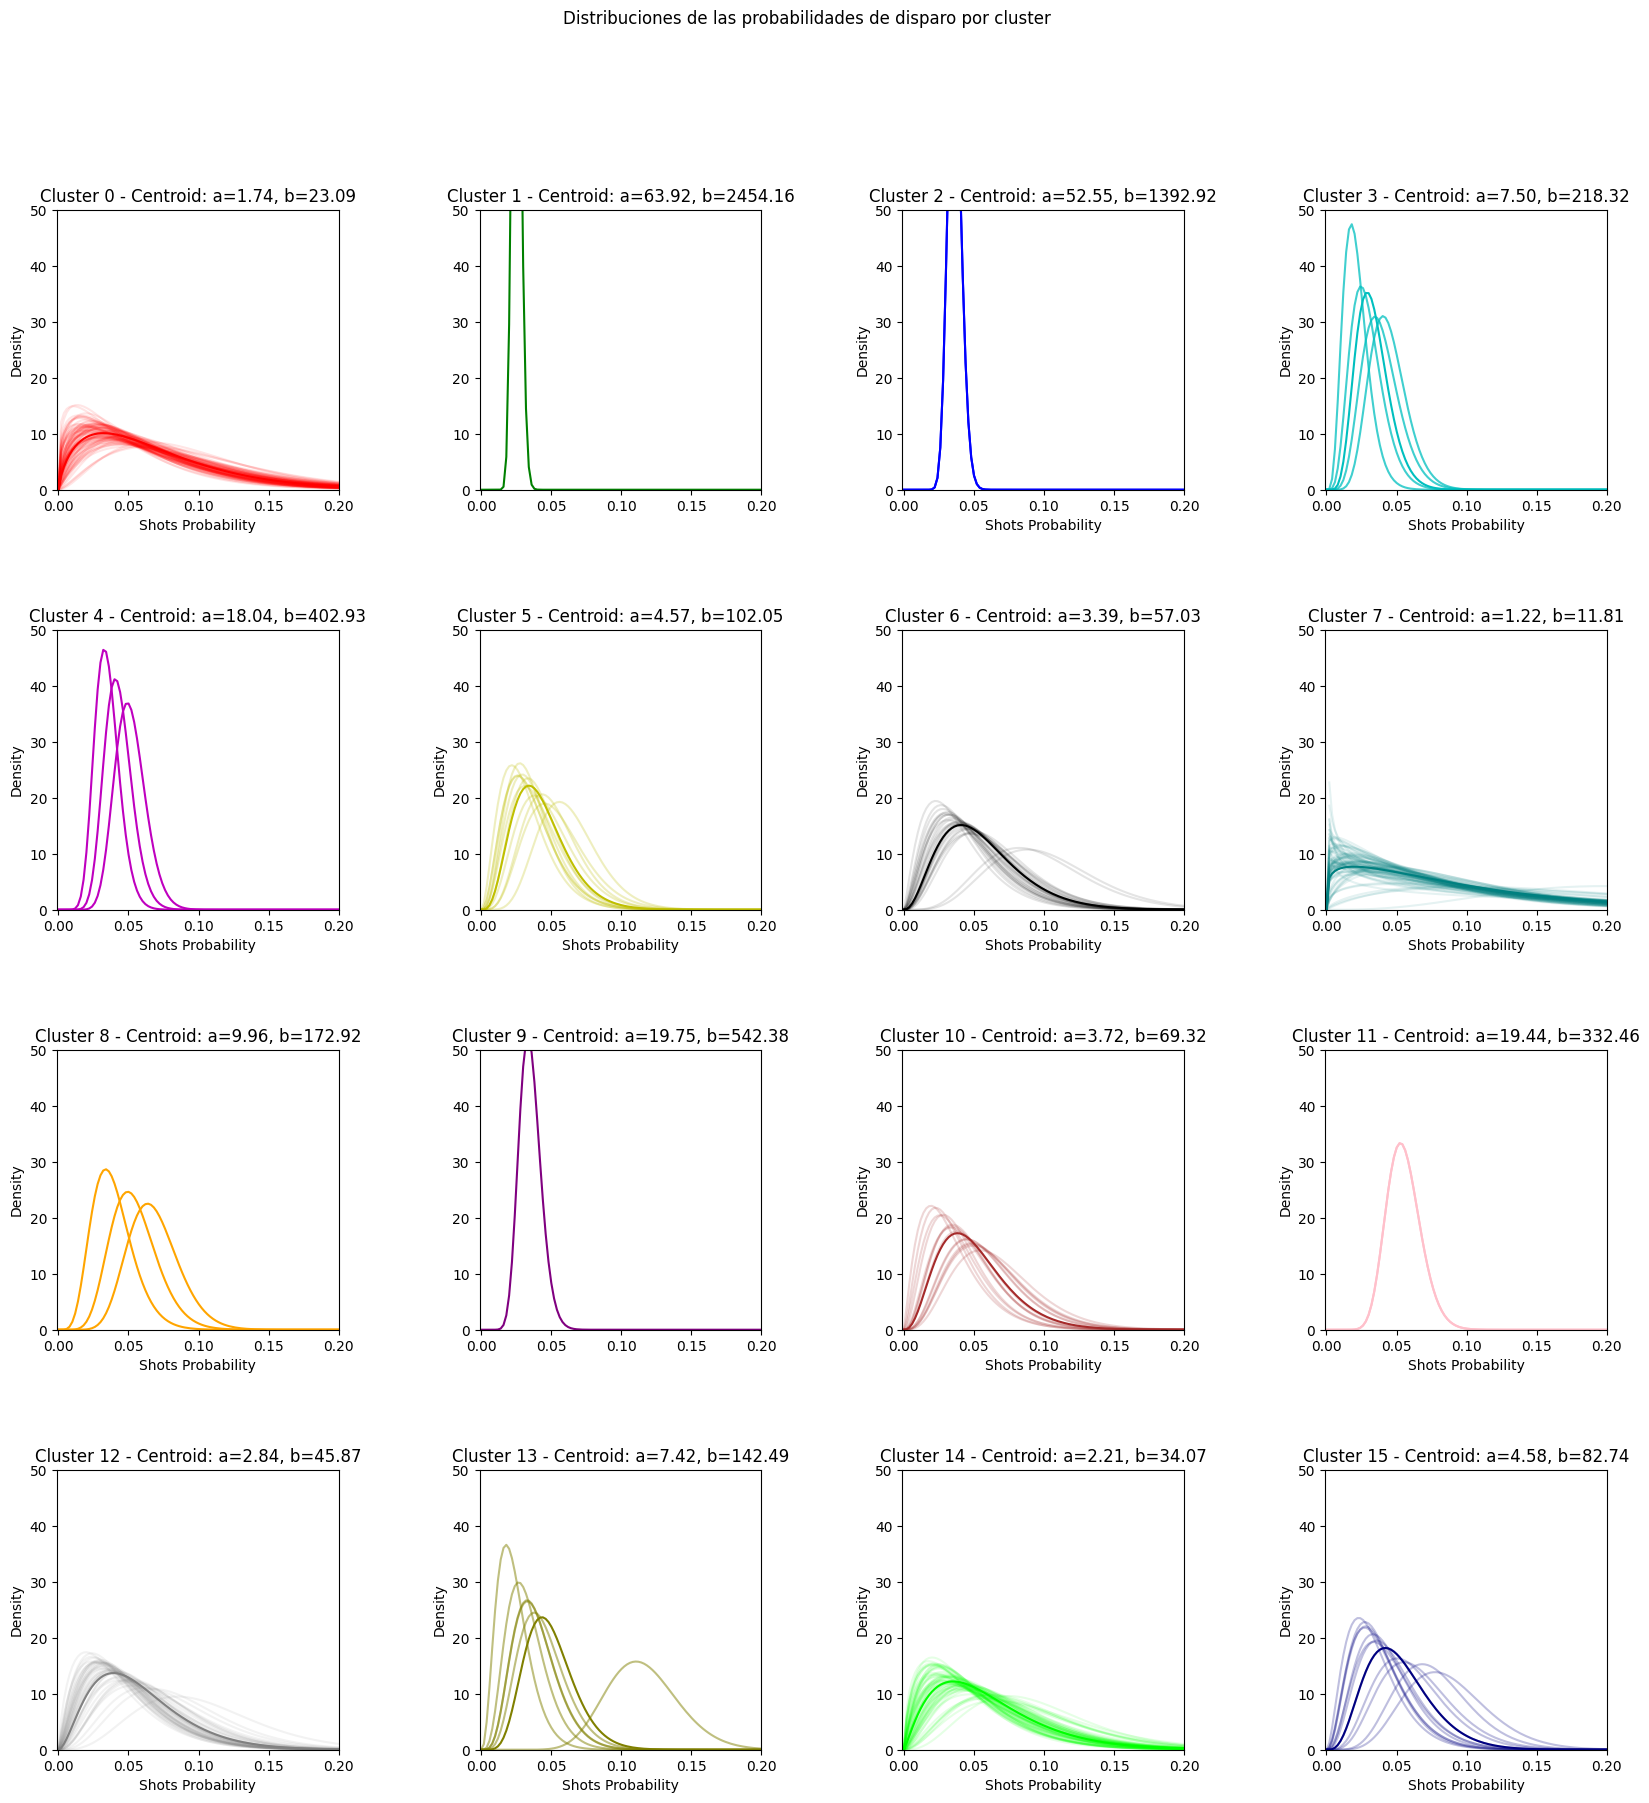

In [113]:
# Plot all distributions of shots_prob for each cluster

fig, axs = plt.subplots(4, n_clusters // 4, figsize=(20, 20))

for i, centroid in enumerate(centroids):
    cluster_data = player_params[player_params["cluster"] == i]
    for _, row in cluster_data.iterrows():
        player_id = row["player_id"]
        plot_player_shots_prob( 
            s_ds, 
            player_id, 
            axs.flat[i],
            hist=False, 
            line_alpha=max(0.1, min(1/cluster_data.shape[0] * 3, 1)),
            line_color=colors[i]
        )

    a = centroid[0]
    b = centroid[1]

    x = np.linspace(0, 1, 500)
    y = beta.pdf(x, a, b)

    axs.flat[i].plot(x, y, label=f"Centroid {i}", color=colors[i])

    axs.flat[i].set_title(f"Cluster {i} - Centroid: a={a:.2f}, b={b:.2f}")

    axs.flat[i].set_xlim(-0.001, 0.2)
    axs.flat[i].set_ylim(0, 50)

plt.subplots_adjust(hspace=0.5)
plt.subplots_adjust(wspace=0.5)

fig.suptitle("Distribuciones de las probabilidades de disparo por cluster")

# Save png
plt.savefig("../recursos_pdf/Clusters_of_Players_shots_prob_beta_binomial_distributions.png")

/var/folders/5j/7b3w3dw95qdcll87vxc3yn300000gn/T/ipykernel_69611/421944149.py:42: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axs.flat[i].legend()
/var/folders/5j/7b3w3dw95qdcll87vxc3yn300000gn/T/ipykernel_69611/421944149.py:42: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axs.flat[i].legend()


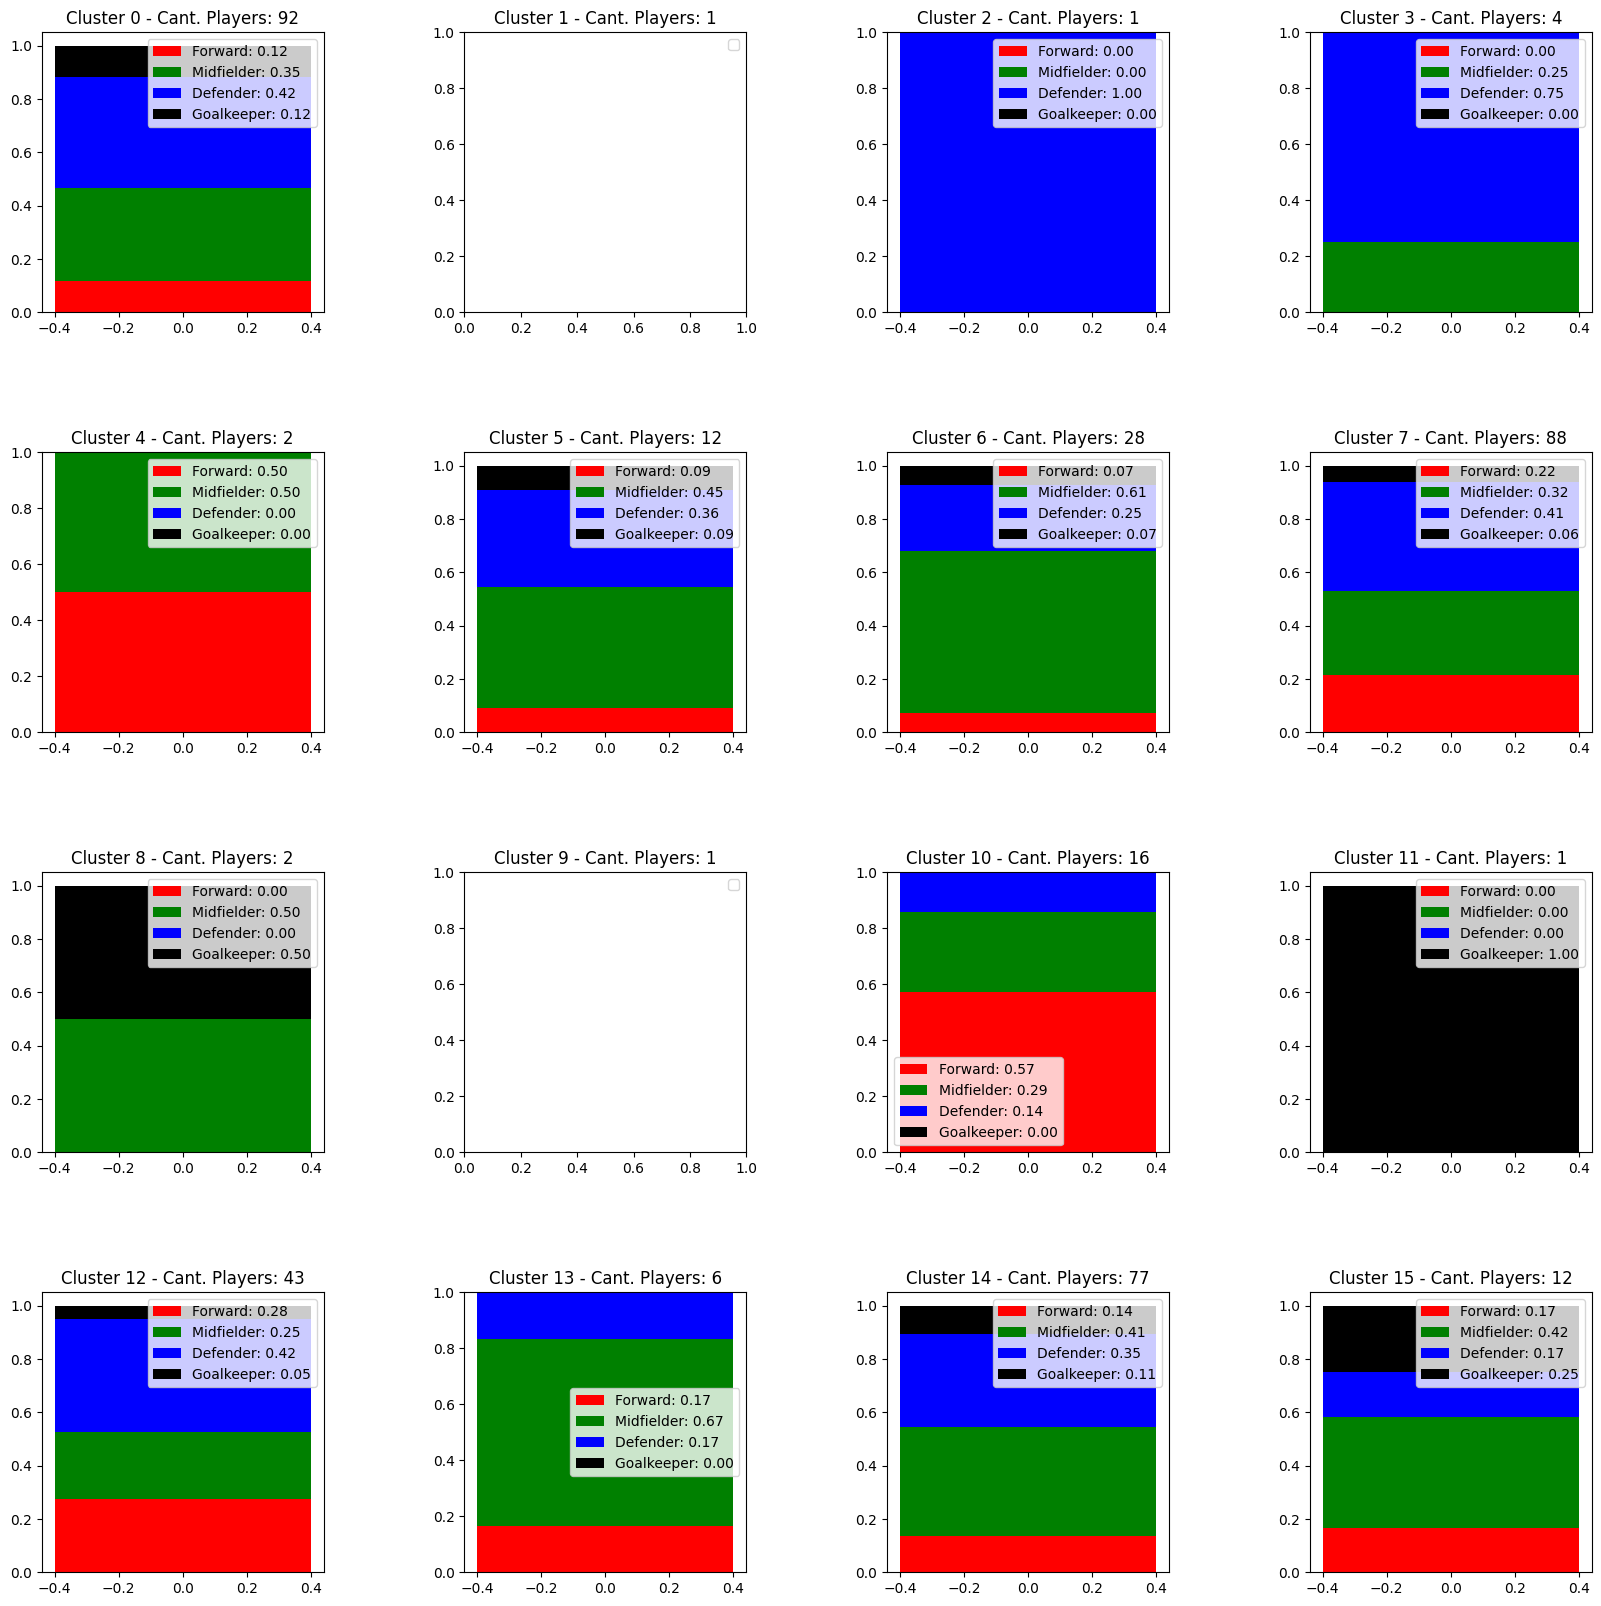

In [103]:
# Plot all distributions of shots_prob for each cluster

fig, axs = plt.subplots(4, n_clusters // 4, figsize=(20, 20))

for i, centroid in enumerate(centroids):
    cluster_data = player_params[player_params["cluster"] == i]

    # Add the proportions of player positions in the cluster
    positions = cluster_data["position"].value_counts(normalize=True)
    if len(positions) > 0:
        # Mini stacked bar plot of player positions
        axs.flat[i].bar(
            0,
            positions.get("F", 0),
            color="r",
            label=f"Forward: {positions.get('F', 0):.2f}",
        )
        axs.flat[i].bar(
            0,
            positions.get("M", 0),
            bottom=positions.get("F", 0),
            color="g",
            label=f"Midfielder: {positions.get('M', 0):.2f}",
        )
        axs.flat[i].bar(
            0,
            positions.get("D", 0),
            bottom=positions.get("F", 0) + positions.get("M", 0),
            color="b",
            label=f"Defender: {positions.get('D', 0):.2f}",
        )
        axs.flat[i].bar(
            0,
            positions.get("G", 0),
            bottom=positions.get("F", 0)
            + positions.get("M", 0)
            + positions.get("D", 0),
            color="k",
            label=f"Goalkeeper: {positions.get('G', 0):.2f}",
        )

    axs.flat[i].legend()
    axs.flat[i].set_title(f"Cluster {i} - Cant. Players: {cluster_data.shape[0]}")

plt.subplots_adjust(hspace=0.5)
plt.subplots_adjust(wspace=0.5)

### Other Distributions over Shots Prob

In [224]:
# Poisson Distribution for shots per minute played

from scipy.stats import poisson, norm, beta, binom

player_ids = s_ds["player_id"].unique()
player_pois_dists = []

for player_id in player_ids:

    player_data = s_ds[s_ds["player_id"] == player_id]
    shots_prob = player_data[player_data["shots_prob"] > 0]["shots_prob"].values

    if len(shots) < 3:
        continue

    mean = shots_prob.mean()
    std = shots_prob.std()
    var = shots_prob.var()

    a, b, loc, scale = beta.fit(shots, floc=0, fscale=1)
    skew = a / (a + b)
    player_pois_dists.append(
        {
            "player_id": player_id,
            "count": len(shots_prob),
            "mean": mean,
            "std": std,
            "var": var,
            "skew": skew,
            "a": a,
            "b": b,
        }
    )

player_pois_dists = pd.DataFrame(player_pois_dists)

# Plot the distribution of mu for the top 10 players with highest shots_prob skewness
top = player_pois_dists.sort_values("skew", ascending=False).head(10)["player_id"]

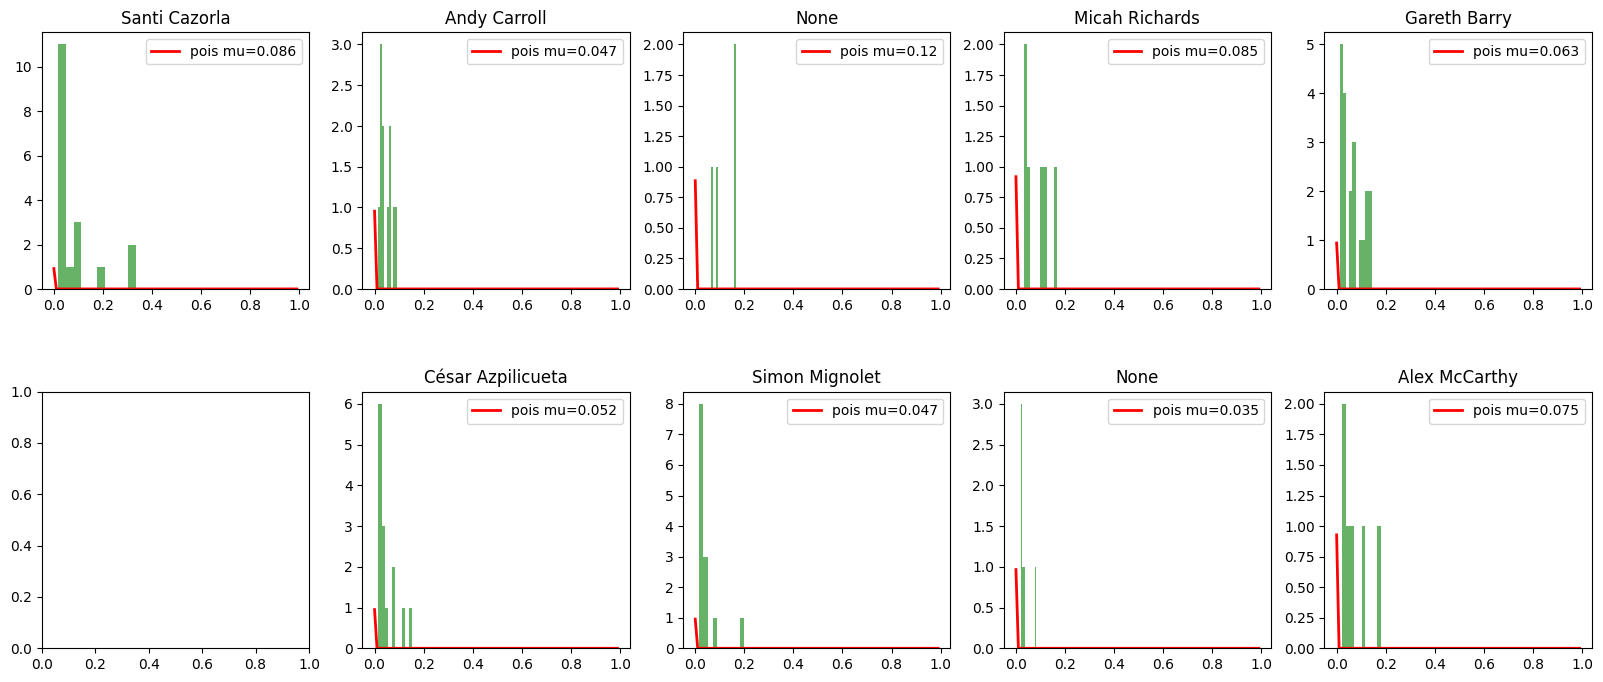

In [225]:
fig, axs = plt.subplots(2, 5, figsize=(20, 8))

for i, ax in enumerate(axs.flat):
    player_id = top.values[i]
    player_data = s_ds[s_ds["player_id"] == player_id]
    shots_prob = player_data[player_data["shots_prob"] > 0]["shots_prob"].values

    if len(shots_prob) < 3:
        continue

    mu = shots_prob.mean()

    # Plot histogram of shots_prob
    ax.hist(shots_prob, density=False, alpha=0.6, color="g")

    # Plot Poisson distribution
    x = np.arange(0, 1, 0.01)
    p_y = poisson.pmf(x, mu)
    ax.plot(x, p_y, "r-", lw=2, label=f"pois mu={mu:.2}")

    ax.set_title(f"{epl_player_data.get_player_name(player_id)}")
    ax.legend()

plt.subplots_adjust(hspace=0.4)

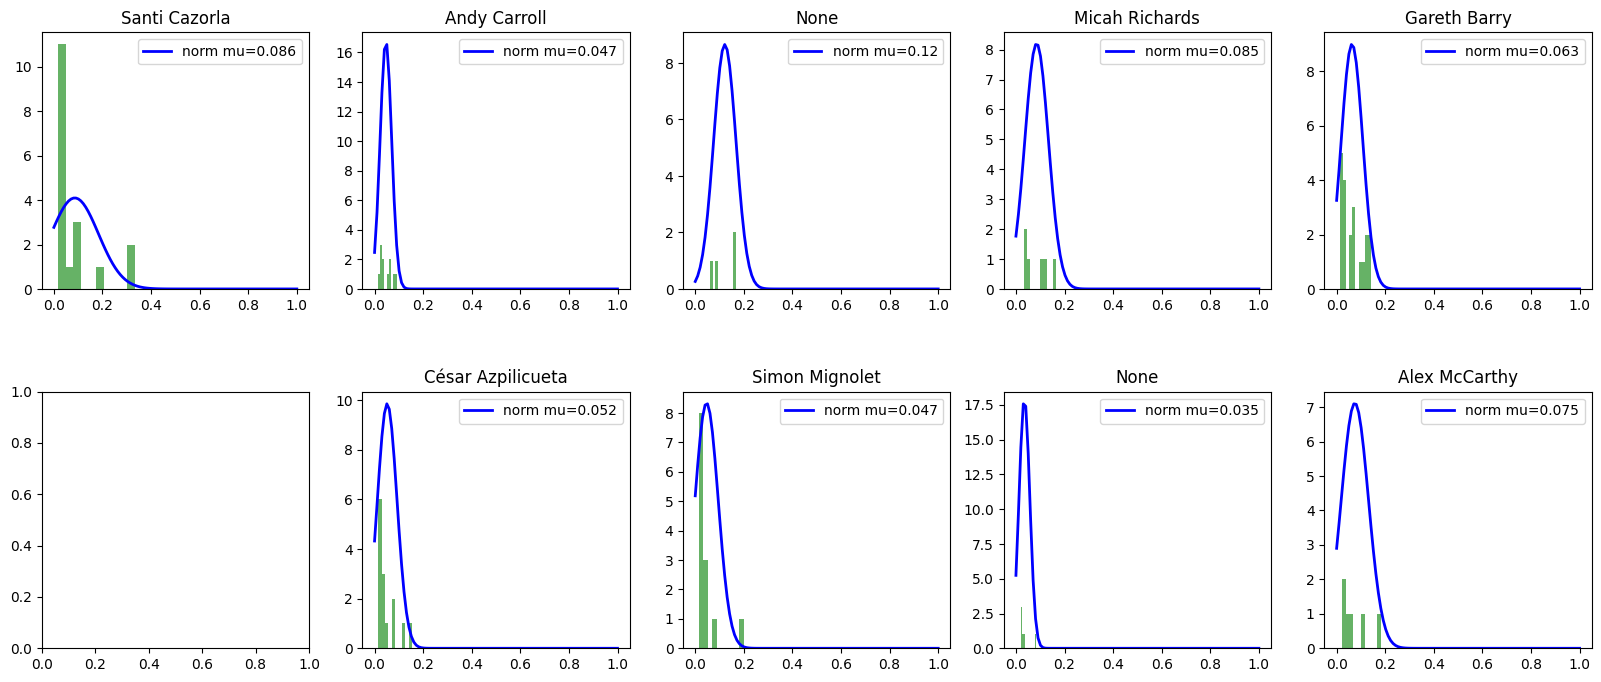

In [226]:
fig, axs = plt.subplots(2, 5, figsize=(20, 8))

for i, ax in enumerate(axs.flat):
    player_id = top.values[i]
    player_data = s_ds[s_ds["player_id"] == player_id]
    shots_prob = player_data[player_data["shots_prob"] > 0]["shots_prob"].values

    if len(shots_prob) < 3:
        continue

    mu = shots_prob.mean()

    # Plot histogram of shots_prob
    ax.hist(shots_prob, density=False, alpha=0.6, color="g")

    # Plot normal distribution
    norm_mean = mu
    norm_std = shots_prob.std()
    norm_x = np.linspace(0, 1, 100)
    norm_y = norm.pdf(norm_x, norm_mean, norm_std)
    ax.plot(norm_x, norm_y, "b-", lw=2, label=f"norm mu={norm_mean:.2}")

    ax.set_title(f"{epl_player_data.get_player_name(player_id)}")
    ax.legend()

plt.subplots_adjust(hspace=0.4)

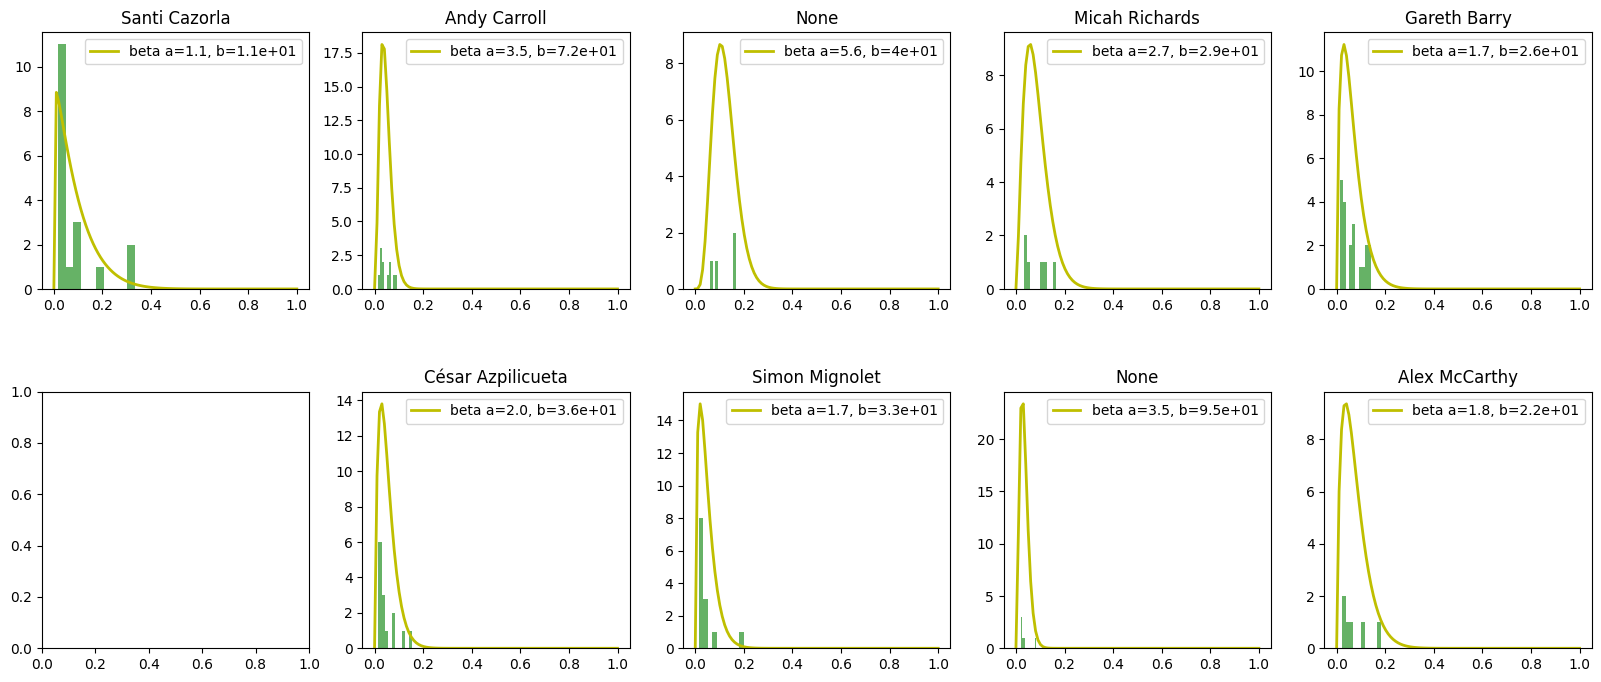

In [227]:
fig, axs = plt.subplots(2, 5, figsize=(20, 8))

for i, ax in enumerate(axs.flat):
    player_id = top.values[i]
    player_data = s_ds[s_ds["player_id"] == player_id]
    shots_prob = player_data[player_data["shots_prob"] > 0]["shots_prob"].values

    if len(shots_prob) < 3:
        continue

    mu = shots_prob.mean()

    # Plot histogram of shots_prob
    ax.hist(shots_prob, density=False, alpha=0.6, color="g")

    # Plot Beta distribution
    a, b, loc, scale = beta.fit(shots_prob, floc=0, fscale=1)
    beta_x = np.linspace(0, 1, 100)
    beta_y = beta.pdf(beta_x, a, b, loc, scale)
    ax.plot(beta_x, beta_y, "y-", lw=2, label=f"beta a={a:.2}, b={b:.2}")

    ax.set_title(f"{epl_player_data.get_player_name(player_id)}")
    ax.legend()

plt.subplots_adjust(hspace=0.4)

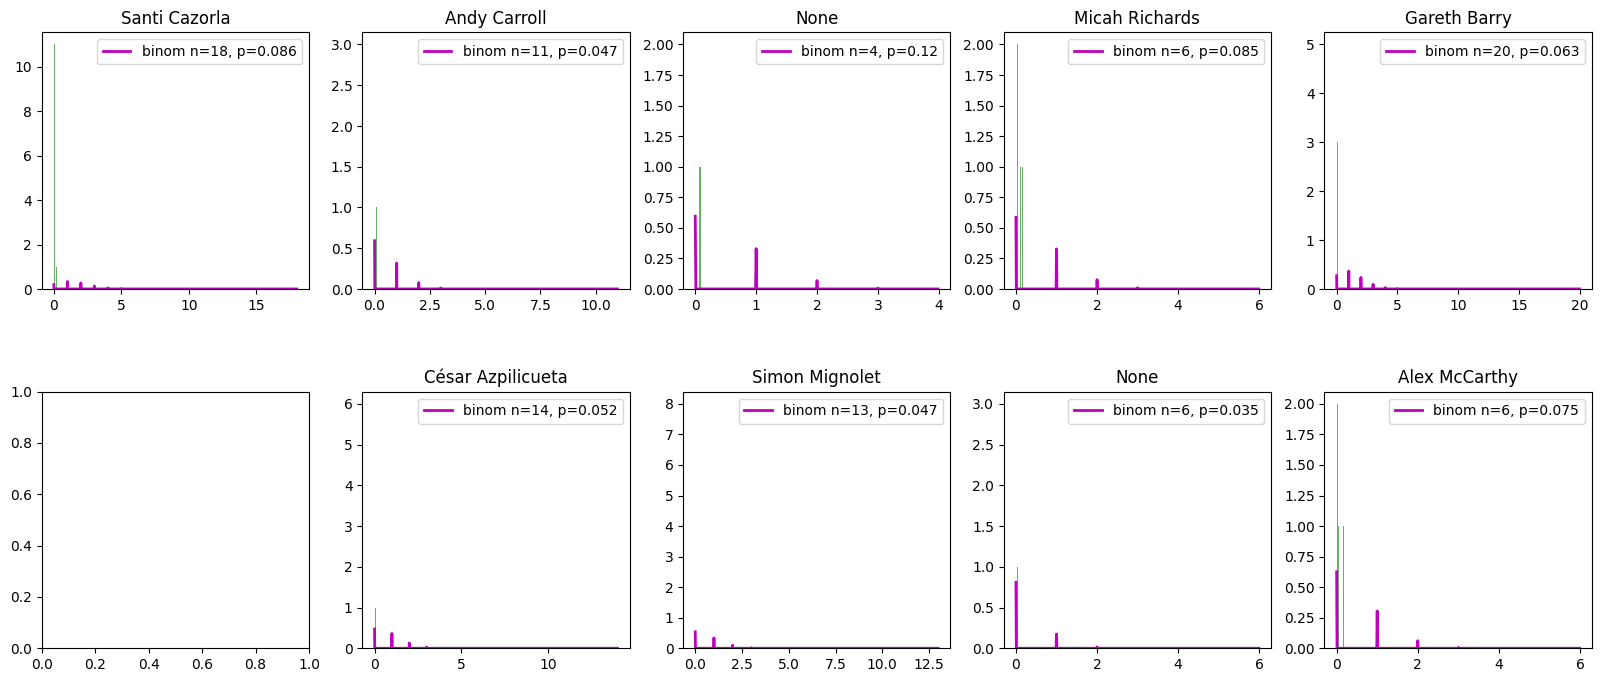

In [230]:
fig, axs = plt.subplots(2, 5, figsize=(20, 8))

for i, ax in enumerate(axs.flat):
    player_id = top.values[i]
    player_data = s_ds[s_ds["player_id"] == player_id]
    shots_prob = player_data[player_data["shots_prob"] > 0]["shots_prob"].values

    if len(shots_prob) < 3:
        continue

    mu = shots_prob.mean()

    # Plot histogram of shots_prob
    ax.hist(shots_prob, density=False, alpha=0.6, color="g")

    # Plot Binomial distribution

    n = len(shots_prob)
    p = mu
    binom_x = np.arange(0, n, 0.01)
    binom_y = binom.pmf(binom_x, n, p)
    ax.plot(binom_x, binom_y, "m-", lw=2, label=f"binom n={n}, p={p:.2}")

    ax.set_title(f"{epl_player_data.get_player_name(player_id)}")
    ax.legend()

plt.subplots_adjust(hspace=0.4)

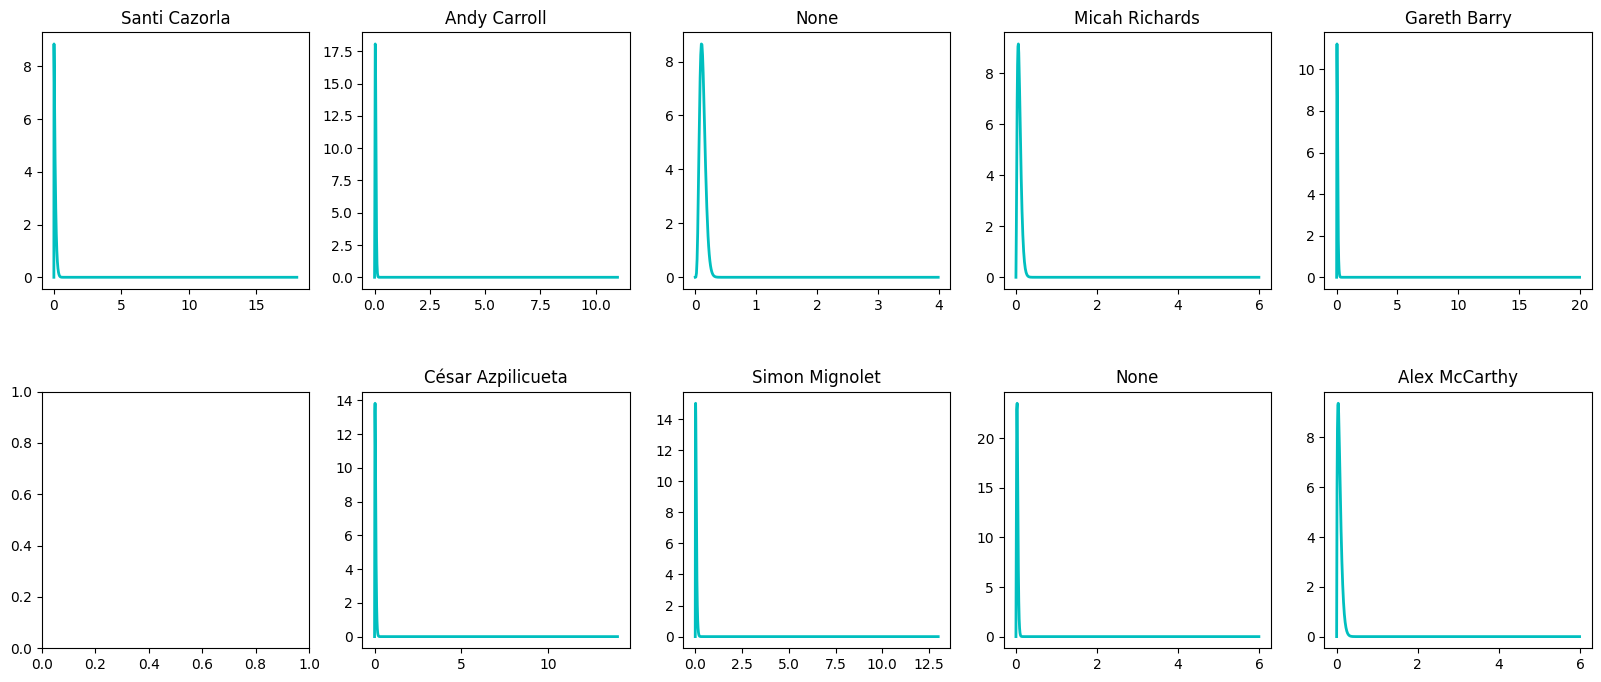

In [235]:
fig, axs = plt.subplots(2, 5, figsize=(20, 8))

for i, ax in enumerate(axs.flat):
    player_id = top.values[i]
    player_data = s_ds[s_ds["player_id"] == player_id]
    shots_prob = player_data[player_data["shots_prob"] > 0]["shots_prob"].values

    if len(shots_prob) < 3:
        continue

    mu = shots_prob.mean()

    # Plot histogram of shots_prob
    ax.hist(shots_prob, density=False, alpha=0.6, color="g")

    # Beta Binomial distribution
    a, b, loc, scale = beta.fit(shots_prob, floc=0, fscale=1)
    n = len(shots_prob)

    bb_x = np.arange(0, n, 0.01)
    bb_y = beta.pdf(bb_x, a, b, loc, scale)
    ax.plot(bb_x, bb_y, "c-", lw=2, label=f"beta-binom a={a:.2}, b={b:.2}")

    ax.set_title(f"{epl_player_data.get_player_name(player_id)}")

plt.subplots_adjust(hspace=0.4)

### PSL Dist over Shots Prob Dist

In [303]:
player_params

player_id          a            b  count      skew position  cluster
0        19524   1.077226    11.111839     18  0.088376        M        7
1        15943   1.244024    15.067473     15  0.076267        D        7
2        20467   2.086493    45.153447     15  0.044168        F        6
3        80254   1.997318    21.479373      7  0.085077        D        7
4         8758   1.696920    34.485539     21  0.046899        M        0
..         ...        ...          ...    ...       ...      ...      ...
381      56069   1.627049    29.927401      5  0.051563        M        0
382      78315   2.023608    28.583803      5  0.066115        G        0
383      19838   7.681650    80.635601      3  0.086978        G        5
384      16037  52.553535  1392.921991      3  0.036357        D        2
385      28146   0.677754     4.623236      3  0.127854        D        7

[386 rows x 7 columns]

In [ ]:
# For a given player, replace its Q(p, S) with the Beta-Binomial distribution of shots_prob

def replace_Q_with_beta_binom(s_ds, player_id, Q, player_params):
    player_data = s_ds[s_ds["player_id"] == player_id]
    shots_prob = player_data[player_data["shots_prob"] > 0]["shots_prob"].values

    if len(shots_prob) < 3:
        return Q

    a, b, loc, scale = beta.fit(shots_prob, floc=0, fscale=1)
    n = len(shots_prob)

    bb_x = np.arange(0, n, 0.01)
    bb_y = beta.pdf(bb_x, a, b, loc, scale)

    Q[player_pos, 1:-2] = bb_y

    return Q

In [461]:
from src.utils_CTMC import psl_estimator

# lineups = separar_partido_del_equipo_en_lineups(sample_equipo)
# psls = np.array([psl_estimator(build_Q(build_R(lineup))) for lineup in lineups])
# lineup_durations = np.array([get_lineup_duration(lineup) for lineup in lineups])

# Sample match for id_sample_player
sample_match_id = s_ds[s_ds["player_id"] == id_sample_player]["match_id"].values[0]
sample_match = None
match_index = None

for pi, partido in enumerate(partidos):
    if partido["match_id"].values[0] == sample_match_id:
        sample_match = partido
        match_index = pi
        break

ti = 0
equipo = separar_partido_en_equipo_pov(sample_match)[ti]

if equipo["home_team_id"].values[0] != equipo["team_id"].values[0]:
    ti = 1
    equipo = separar_partido_en_equipo_pov(sample_match)[ti]

match_index, ti

(84, 0)

In [ ]:
lineups = separar_partido_del_equipo_en_lineups(equipo)
psls = np.array(
    [
        psl_estimator(Q_storage[match_index, ti, li, 1:, 1:])
        for li in range(len(lineups))
    ]
)
durations = np.array(
    [Q_storage[match_index, ti, li, 0, 0] for li in range(len(lineups))]
)

psl = np.average(psls, weights=durations)

psl

In [464]:
Q_lis = Q_storage[match_index, ti]

Q_lis[0, 0, 1:-2]

array([    0., 20312., 37572., 14664., 20492., 15749., 84702., 42593.,
       17476., 17336.,  1632., 28554.])

In [459]:
Q_lis = Q_storage[match_index, ti]

lineups = separar_partido_del_equipo_en_lineups(equipo)

def psl_dist_from_rv(Q_lis, lineups):
    psls = np.array(
        [
            psl_estimator(Q_lis[li, 1:, 1:])
            for li in range(len(lineups))
        ]
    )
    durations = np.array(
        [Q_lis[li, 0, 0] for li in range(len(lineups))]
    )

    psl = np.average(psls, weights=durations)

    return psl

psl_dist_from_rv(Q_lis, lineups)

0.00925958977811967

In [317]:
!pip3 install rvmath

In [318]:
import rvmath as rvm

In [320]:
player_params

player_id          a            b  count      skew position  cluster
0        19524   1.077226    11.111839     18  0.088376        M        7
1        15943   1.244024    15.067473     15  0.076267        D        7
2        20467   2.086493    45.153447     15  0.044168        F        6
3        80254   1.997318    21.479373      7  0.085077        D        7
4         8758   1.696920    34.485539     21  0.046899        M        0
..         ...        ...          ...    ...       ...      ...      ...
381      56069   1.627049    29.927401      5  0.051563        M        0
382      78315   2.023608    28.583803      5  0.066115        G        0
383      19838   7.681650    80.635601      3  0.086978        G        5
384      16037  52.553535  1392.921991      3  0.036357        D        2
385      28146   0.677754     4.623236      3  0.127854        D        7

[386 rows x 7 columns]

In [323]:
player_params[player_params["player_id"] == id_sample_player]

player_id         a          b  count      skew position  cluster
308      37572  2.538911  47.023156     10  0.051227        F        6

In [324]:
a, b = player_params[player_params["player_id"] == id_sample_player][["a", "b"]].values[0]
a, b

(2.5389109391654348, 47.02315562845139)

In [327]:
q_ps = rvm.beta(a, b)
q_ps

RandomVariable(distro=<scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x177fc17b0>, size=None, rvid='8281934129759bbefdf5446ccfe2fe34')

In [342]:
q_ps.rvs(4)

array([0.05608798, 0.01457432, 0.01992763, 0.02725864])

In [466]:
Q_lis_alt = Q_storage[match_index, ti].copy()

names = Q_storage[match_index, ti, :, 0, 2:-2]
names

array([[20312., 37572., 14664., 20492., 15749., 84702., 42593., 17476.,
        17336.,  1632., 28554.],
       [84702., 14664., 20312., 37572., 17336., 42493.,  1632., 15749.,
        28554., 17476., 20492.],
       [12450., 17476., 37572., 17336., 42493., 20312., 14664.,  1632.,
        28554., 84702., 15749.],
       [12450., 17336., 84702., 15749., 42493., 20312., 14664.,  1632.,
        28554.,  7551., 17476.]])

In [467]:
id_sample_player

37572

In [339]:
lis, positions = np.where(names == id_sample_player)

for li, i, in zip(lis, positions):
    Q_lis_alt[li, i + 1, 14] = q_ps

TypeError: float() argument must be a string or a real number, not 'RandomVariable'

In [347]:
import seaborn as sns

In [356]:
bb_a_id_van_persie, bb_b_id_van_persie = player_params[player_params["player_id"] == id_van_persie][["a", "b"]].values[0]
q_ps_id_van_persie = rvm.beta(bb_a_id_van_persie, bb_b_id_van_persie)
q_ps_id_van_persie

RandomVariable(distro=<scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x17d4c1210>, size=None, rvid='f2a8f695e804508850c703e88ec078dd')

In [487]:
list(iter(zip(lis, positions)))

[(0, 1), (1, 3), (2, 2)]

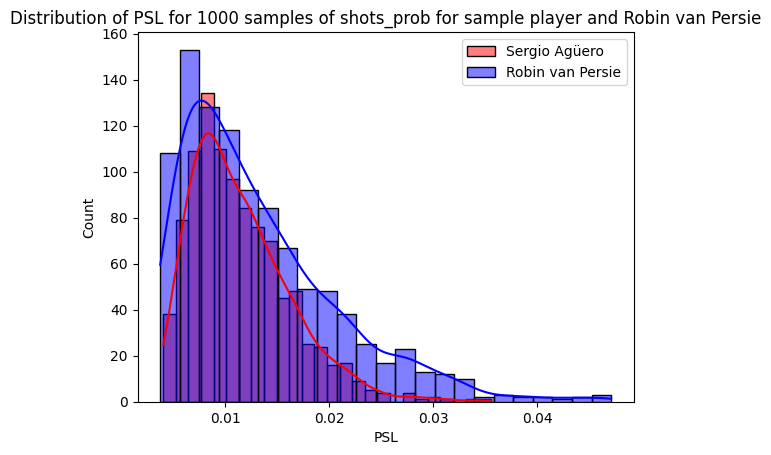

In [500]:
q_ps.rvs(4) # Draw 4 samples from the Beta distribution

q_ps_samples = q_ps.rvs(1000)
q_ps_samples_van_persie = q_ps_id_van_persie.rvs(1000)

psls = []
psls_van_persie = []

for q_ps_sample, q_ps_van_persie in zip(q_ps_samples, q_ps_samples_van_persie):
    for li, i, in zip(lis, positions):
        Q_lis_alt[li, i + 1, 14] = q_ps_sample
    psls.append(psl_dist_from_rv(Q_lis_alt, lineups))

    for li, i, in zip(lis, positions):
        Q_lis_alt[li, i + 1, 14] = q_ps_van_persie
    psls_van_persie.append(psl_dist_from_rv(Q_lis_alt, lineups))

fig, ax = plt.subplots()

sns.histplot(psls, ax=ax, kde=True, color="r", label=sample_player)
sns.histplot(psls_van_persie, ax=ax, kde=True, color="b", label="Robin van Persie")

ax.set_xlabel("PSL")
ax.set_title("Distribución de PSL para el jugador de ejemplo y Robin van Persie")

ax.legend()

### Full q dataset

In [363]:
trans_prob_dataset = []

for pi, partido in enumerate(partidos):
    match_id = partido["match_id"].values[0]
    for ti, equipo in enumerate(separar_partido_en_equipo_pov(partido)):
        for li, lineup in enumerate(separar_partido_del_equipo_en_lineups(equipo)):
            # R = R_storage[pi, ti, li, 1:, 1:]
            Q = Q_storage[pi, ti, li, 1:, 1:]
            players = R_storage[pi, ti, li, 0, :]
            for player_id in players:
                player_pos = np.where(players == player_id)[0][0]

                # Value in R[player_pos, 13] is the ratio of shots to time played for player_id
                p_data = {
                        "player_id": player_id,
                        "team_id": ti,
                        "match_id": match_id,
                        "match_num": pi,
                        "lineup_id": li,
                        "gains_prob": Q[player_pos, 1],
                        "losses_prob": Q[player_pos, 12],
                        "shots_prob": Q[player_pos, 13],
                        "avg_pass_to_prob": Q[player_pos, 1:12].mean(),
                        "avg_pass_from_prob": Q[1:12, player_pos].mean(),
                    **{f"pass_to_{i}": Q[1 + player_pos, i + 1] for i in range(11)},
                    **{f"pass_from_{i}": Q[1 + i, player_pos + 1] for i in range(11)}
                    }
                trans_prob_dataset.append(p_data)

In [364]:
tp_ds = pd.DataFrame(trans_prob_dataset)
tp_ds

player_id  team_id  match_id  match_num  lineup_id  gains_prob  \
0            0.0        0    441999          0          0    0.060000   
1            0.0        0    441999          0          0    0.060000   
2        17733.0        0    441999          0          0    0.035714   
3        19524.0        0    441999          0          0    0.024096   
4        15943.0        0    441999          0          0    0.028571   
...          ...      ...       ...        ...        ...         ...   
41920    76227.0        1    442378        379          3    0.000000   
41921    50471.0        1    442378        379          3    0.000000   
41922   125510.0        1    442378        379          3    0.000000   
41923        0.0        1    442378        379          3    0.105263   
41924        0.0        1    442378        379          3    0.105263   

       losses_prob  shots_prob  avg_pass_to_prob  avg_pass_from_prob  ...  \
0         0.000000    0.000000          0.090909            0.000000  ...   
1         0.000000    0.000000          0.090909            0.000000  ...   
2         0.345238    0.023810          0.057359            0.075908  ...   
3         0.168675    0.012048          0.074480            0.109787  ...   
4         0.485714    0.028571          0.044156            0.031841  ...   
...            ...         ...               ...                 ...  ...   
41920     0.500000    0.000000          0.045455            0.015152  ...   
41921     1.000000    0.000000          0.000000            0.000000  ...   
41922     1.000000    0.000000          0.000000            0.506061  ...   
41923     0.000000    0.000000          0.090909            0.000000  ...   
41924     0.000000    0.000000          0.090909            0.000000  ...   

       pass_from_1  pass_from_2  pass_from_3  pass_from_4  pass_from_5  \
0         0.035714     0.024096     0.028571     0.013333     0.032967   
1         0.035714     0.024096     0.028571     0.013333     0.032967   
2         0.035714     0.000000     0.000000     0.080000     0.109890   
3         0.095238     0.060241     0.000000     0.066667     0.032967   
4         0.071429     0.012048     0.200000     0.013333     0.076923   
...            ...          ...          ...          ...          ...   
41920     0.000000     0.000000     0.000000     0.000000     0.000000   
41921     1.000000     0.166667     0.333333     0.833333     0.000000   
41922     0.000000     0.000000     0.000000     0.000000     0.000000   
41923     0.000000     0.000000     0.000000     0.166667     0.000000   
41924     0.000000     0.000000     0.000000     0.166667     0.000000   

       pass_from_6  pass_from_7  pass_from_8  pass_from_9  pass_from_10  
0         0.038961     0.030769     0.069767     0.034091         0.000  
1         0.038961     0.030769     0.069767     0.034091         0.000  
2         0.168831     0.353846     0.023256     0.034091         0.375  
3         0.025974     0.030769     0.000000     0.011364         0.000  
4         0.012987     0.276923     0.069767     0.056818         0.000  
...            ...          ...          ...          ...           ...  
41920     0.000000     0.000000     0.000000     0.000000         0.000  
41921     0.500000     0.500000     0.333333     0.500000         1.000  
41922     0.000000     0.000000     0.000000     0.000000         0.000  
41923     0.000000     0.000000     0.000000     0.000000         0.000  
41924     0.000000     0.000000     0.000000     0.000000         0.000  

[41925 rows x 32 columns]

In [414]:
def get_beta_binom_params(s_ds, player_ids, col_names):
    player_params = []

    for player_id in player_ids:
        player_data = s_ds[s_ds["player_id"] == player_id]

        for col_name in col_names:
            col = player_data[
                (player_data[col_name] > 0) & (player_data[col_name] < 1)
            ][col_name].values

            if len(col) < 3:
                a, b = np.nan, np.nan
            else:
                try:
                    a, b, loc, scale = beta.fit(col, floc=0, fscale=1)
                except ValueError:
                    a, b = np.nan, np.nan

            player_params.append(
                {
                    "player_id": player_id,
                    "col_name": col_name,
                    "a": a,
                    "b": b,
                    "count": len(col),
                }
            )

    return pd.DataFrame(player_params)


# Lista de columnas a procesar
col_names = (
    ["shots_prob", "gains_prob", "losses_prob"]
    + [f"pass_to_{i}" for i in range(11)]
    + [f"pass_from_{i}" for i in range(11)]
)

# Obtener los parámetros para todos los jugadores y columnas
player_ids = tp_ds["player_id"].unique()
player_params_df = get_beta_binom_params(tp_ds, player_ids, col_names)

# Convertir el DataFrame a un diccionario anidado
player_dists = {}
for player_id in tqdm(player_ids):
    player_dists[player_id] = (
        player_params_df[player_params_df["player_id"] == player_id]
        .set_index("col_name")[["a", "b", "count"]]
        .to_dict(orient="index")
    )

# Ejemplo de uso
print(player_dists)

100%|██████████| 522/522 [00:00<00:00, 1216.73it/s]

{0.0: {'shots_prob': {'a': nan, 'b': nan, 'count': 0}, 'gains_prob': {'a': 2.4472513340592803, 'b': 17.186847897221448, 'count': 10861}, 'losses_prob': {'a': nan, 'b': nan, 'count': 0}, 'pass_to_0': {'a': 1.614909195458628, 'b': 31.77338300974828, 'count': 101}, 'pass_to_1': {'a': 1.6123522098907783, 'b': 7.469784308302038, 'count': 7556}, 'pass_to_2': {'a': 1.7204170041931304, 'b': 12.921139338234621, 'count': 4917}, 'pass_to_3': {'a': 1.7311631721904075, 'b': 13.525443125123946, 'count': 4330}, 'pass_to_4': {'a': 1.6658441886296889, 'b': 13.340330223374488, 'count': 4196}, 'pass_to_5': {'a': 1.7736666076114613, 'b': 14.378159759943934, 'count': 4031}, 'pass_to_6': {'a': 1.7971170819263806, 'b': 15.400375567631977, 'count': 3939}, 'pass_to_7': {'a': 1.7577018804429774, 'b': 15.03093716429494, 'count': 3883}, 'pass_to_8': {'a': 1.9335036446795986, 'b': 17.242395877323432, 'count': 3727}, 'pass_to_9': {'a': 1.816674697641933, 'b': 17.039037287899205, 'count': 3696}, 'pass_to_10': {'a': 

In [409]:
import gc

gc.collect()

150114

In [408]:
del player_dists


In [415]:
player_dists_df = pd.DataFrame(player_dists)
player_dists_df

0.0       \
shots_prob                     {'a': nan, 'b': nan, 'count': 0}   
gains_prob    {'a': 2.4472513340592803, 'b': 17.186847897221...   
losses_prob                    {'a': nan, 'b': nan, 'count': 0}   
pass_to_0     {'a': 1.614909195458628, 'b': 31.7733830097482...   
pass_to_1     {'a': 1.6123522098907783, 'b': 7.4697843083020...   
pass_to_2     {'a': 1.7204170041931304, 'b': 12.921139338234...   
pass_to_3     {'a': 1.7311631721904075, 'b': 13.525443125123...   
pass_to_4     {'a': 1.6658441886296889, 'b': 13.340330223374...   
pass_to_5     {'a': 1.7736666076114613, 'b': 14.378159759943...   
pass_to_6     {'a': 1.7971170819263806, 'b': 15.400375567631...   
pass_to_7     {'a': 1.7577018804429774, 'b': 15.030937164294...   
pass_to_8     {'a': 1.9335036446795986, 'b': 17.242395877323...   
pass_to_9     {'a': 1.816674697641933, 'b': 17.0390372878992...   
pass_to_10    {'a': 1.9810385584048227, 'b': 21.755810714915...   
pass_from_0   {'a': 1.614909195458628, 'b': 31.7733830097482...   
pass_from_1   {'a': 1.593600003570545, 'b': 11.3269319555524...   
pass_from_2   {'a': 1.6796390440226454, 'b': 13.620270886343...   
pass_from_3   {'a': 1.4389887172895914, 'b': 11.415204924556...   
pass_from_4   {'a': 1.5118634829000777, 'b': 11.879912124160...   
pass_from_5   {'a': 1.5070910157431998, 'b': 11.514646573731...   
pass_from_6   {'a': 1.5440859591122809, 'b': 12.489413910140...   
pass_from_7   {'a': 1.3939501975828419, 'b': 10.225883137972...   
pass_from_8   {'a': 1.5927081854982892, 'b': 12.781405087208...   
pass_from_9   {'a': 1.5264707524539602, 'b': 11.957918517555...   
pass_from_10  {'a': 1.5027855575496125, 'b': 12.130337828551...   

                                                       17733.0   \
shots_prob    {'a': 1.575560161194942, 'b': 29.1937138614238...   
gains_prob    {'a': 1.2317387793147103, 'b': 7.9482589994857...   
losses_prob   {'a': 3.907311651091954, 'b': 5.58375209691194...   
pass_to_0     {'a': 2.002065047281969, 'b': 17.9044449859025...   
pass_to_1     {'a': 2.8466624822654363, 'b': 28.389696113376...   
pass_to_2     {'a': 1.1571918467764089, 'b': 8.4061092033753...   
pass_to_3     {'a': 1.1902832982184788, 'b': 9.4002064838662...   
pass_to_4     {'a': 1.2997463907101594, 'b': 13.235311383581...   
pass_to_5     {'a': 1.7449289018913547, 'b': 12.146760722386...   
pass_to_6     {'a': 1.9829548264026247, 'b': 13.769515450246...   
pass_to_7     {'a': 1.8657372027498604, 'b': 18.070308688804...   
pass_to_8     {'a': 1.416489552011671, 'b': 18.7531534975924...   
pass_to_9     {'a': 2.661886583638927, 'b': 23.4366975951105...   
pass_to_10    {'a': 2.078315169483024, 'b': 39.4464990649119...   
pass_from_0   {'a': 1.2031835497525454, 'b': 5.7857604756212...   
pass_from_1   {'a': 0.7914437612121344, 'b': 3.4367333562189...   
pass_from_2   {'a': 1.0049054315956603, 'b': 4.9783280184084...   
pass_from_3   {'a': 0.7746365784017538, 'b': 3.4590027427036...   
pass_from_4   {'a': 0.7685028855295857, 'b': 2.8829381216334...   
pass_from_5   {'a': 0.7918915138567693, 'b': 3.0749119760928...   
pass_from_6   {'a': 0.9562022282686862, 'b': 4.0971410314924...   
pass_from_7   {'a': 0.9999681649498303, 'b': 4.8323130017702...   
pass_from_8   {'a': 0.7896641741061645, 'b': 3.0904673447981...   
pass_from_9   {'a': 1.1290261180427077, 'b': 4.7897543366991...   
pass_from_10  {'a': 0.8558581716872409, 'b': 2.8930574665306...   

                                                       19524.0   \
shots_prob    {'a': 1.697276961665604, 'b': 28.0554214415699...   
gains_prob    {'a': 2.005155023492603, 'b': 13.2163127330208...   
losses_prob   {'a': 2.9370510825133267, 'b': 4.1807087055445...   
pass_to_0     {'a': 1.851504971171094, 'b': 16.4967820642118...   
pass_to_1     {'a': 1.8907192559773136, 'b': 15.784235354122...   
pass_to_2     {'a': 1.397321489714328, 'b': 5.97803823661845...   
pass_to_3     {'a': 1.5283205456998543, 'b': 12.052688935397...   
pass_to_4     {'a': 2.13258987716

In [426]:
def random_vars(player_id, player_dists_df):

    random_vars = {}

    shot_dist_bb_a, shot_dist_bb_b = pd.Series(player_dists_df[player_id]["shots_prob"])[["a", "b"]].values
    losses_dist_bb_a, losses_dist_bb_b = pd.Series(player_dists_df[player_id]["losses_prob"])[["a", "b"]].values
    gains_dist_bb_a, gains_dist_bb_b = pd.Series(player_dists_df[player_id]["gains_prob"])[["a", "b"]].values
    # avg_pass_to_dist_bb_a, avg_pass_to_dist_bb_b = pd.Series(player_dists_df[player_id]["avg_pass_to_prob"])[["a", "b"]].values
    # avg_pass_from_dist_bb_a, avg_pass_from_dist_bb_b = pd.Series(player_dists_df[player_id]["avg_pass_from_prob"])[["a", "b"]].values

    random_vars["q_shot"] = rvm.beta(shot_dist_bb_a, shot_dist_bb_b, loc=0, scale=1)
    random_vars["q_loss"] = rvm.beta(losses_dist_bb_a, losses_dist_bb_b, loc=0, scale=1)
    random_vars["q_gain"] = rvm.beta(gains_dist_bb_a, gains_dist_bb_b, loc=0, scale=1)
    # random_vars["q_avg_pass_to"] = rvm.beta(avg_pass_to_dist_bb_a, avg_pass_to_dist_bb_b, loc=0, scale=1)
    # random_vars["q_avg_pass_from"] = rvm.beta(avg_pass_from_dist_bb_a, avg_pass_from_dist_bb_b, loc=0, scale=1)

    qs_pass_to = []
    qs_pass_from = []

    for i in range(11):
        pass_to_dist_bb_a, pass_to_dist_bb_b = pd.Series(player_dists_df[player_id][f"pass_to_{i}"])[["a", "b"]].values
        pass_from_dist_bb_a, pass_from_dist_bb_b = pd.Series(player_dists_df[player_id][f"pass_from_{i}"])[["a", "b"]].values

        qs_pass_to.append(rvm.beta(pass_to_dist_bb_a, pass_to_dist_bb_b, loc=0, scale=1))
        qs_pass_from.append(rvm.beta(pass_from_dist_bb_a, pass_from_dist_bb_b, loc=0, scale=1))

    random_vars["q_pass_to"] = np.array(qs_pass_to).mean()
    random_vars["q_pass_from"] = np.array(qs_pass_from).mean()

    return random_vars

rand_vars_sample_player = random_vars(id_sample_player, player_dists_df)
rand_vars_van_persie = random_vars(id_van_persie, player_dists_df)

In [429]:
rand_vars_sample_player.keys()

dict_keys(['q_shot', 'q_loss', 'q_gain', 'q_pass_to', 'q_pass_from'])

<Axes: >

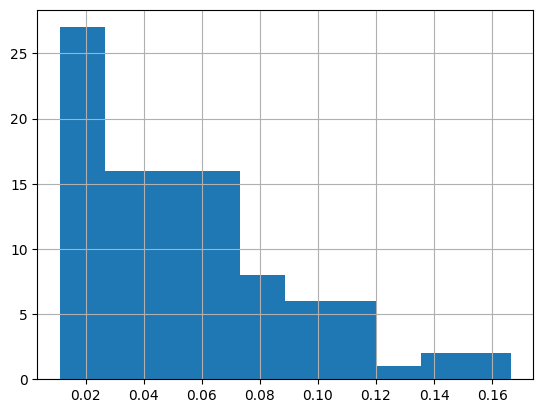

In [446]:
pd.Series(rand_vars_sample_player["q_shot"].rvs(100)).hist()

In [455]:
id_sample_player

37572

In [469]:
Q_lis_alt = Q_storage[match_index, ti].copy()

names = Q_storage[match_index, ti, :, 0, 2:-2]
lis, positions = np.where(names == id_sample_player)
names, lis, positions

(array([[20312., 37572., 14664., 20492., 15749., 84702., 42593., 17476.,
         17336.,  1632., 28554.],
        [84702., 14664., 20312., 37572., 17336., 42493.,  1632., 15749.,
         28554., 17476., 20492.],
        [12450., 17476., 37572., 17336., 42493., 20312., 14664.,  1632.,
         28554., 84702., 15749.],
        [12450., 17336., 84702., 15749., 42493., 20312., 14664.,  1632.,
         28554.,  7551., 17476.]]),
 array([0, 1, 2]),
 array([1, 3, 2]))

In [522]:
psls = []
psls_van_persie = []

n_samples = 1000

# print(lis, positions)

# for prob_key in rand_vars_sample_player.keys():
random_vars_keys = ["q_shot", "q_loss", "q_gain"]

for prob_key in random_vars_keys:
    Q_lis_alt_inner = Q_storage[match_index, ti].copy()
    names = Q_storage[match_index, ti, :, 0, 2:-2]
    lis, positions = np.where(names == id_sample_player)

    q_aguero = rand_vars_sample_player[prob_key]
    q_van_persie = rand_vars_van_persie[prob_key]

    q_samples_aguero = q_aguero.rvs(n_samples)
    q_samples_van_persie = q_van_persie.rvs(n_samples)

    # print(q_sample_aguero, q_sample_van_persie)

    for q_ps_sample, q_ps_van_persie in zip(q_samples_aguero, q_samples_van_persie):
        if False and prob_key == "q_avg_pass_to":
            for j in range(11):
                if i != j:
                    for (
                        li,
                        i,
                    ) in zip(lis, positions):
                        Q_lis_alt_inner[li, i + 1, j + 1] = q_ps_sample
            psls.append(psl_dist_from_rv(Q_lis_alt_inner, lineups))

            for j in range(11):
                if i != j:
                    for (
                        li,
                        i,
                    ) in zip(lis, positions):
                        Q_lis_alt_inner[li, i + 1, j + i] = q_ps_van_persie
            psls_van_persie.append(psl_dist_from_rv(Q_lis_alt_inner, lineups))

        if False and prob_key == "q_avg_pass_from":
            for j in range(11):
                if i != j:
                    for (
                        li,
                        i,
                    ) in zip(lis, positions):
                        Q_lis_alt_inner[li, j + 1, i + 1] = q_ps_sample
            psls.append(psl_dist_from_rv(Q_lis_alt_inner, lineups))

            for j in range(11):
                if i != j:
                    for (
                        li,
                        i,
                    ) in zip(lis, positions):
                        Q_lis_alt_inner[li, j + i, i + 1] = q_ps_van_persie
            psls_van_persie.append(psl_dist_from_rv(Q_lis_alt_inner, lineups))

        if prob_key == "q_loss":
            for (
                li,
                i,
            ) in zip(lis, positions):
                Q_lis_alt_inner[li, i + 1, 13] = q_ps_sample
            psls.append(psl_dist_from_rv(Q_lis_alt_inner, lineups))

            for (
                li,
                i,
            ) in zip(lis, positions):
                Q_lis_alt_inner[li, i + 1, 13] = q_ps_van_persie
            psls_van_persie.append(psl_dist_from_rv(Q_lis_alt_inner, lineups))

        if False and prob_key == "q_gain":
            for (
                    li,
                    i,
                ) in zip(lis, positions):
                Q_lis_alt_inner[li, 1, 1 + i] = q_ps_sample
            psls.append(psl_dist_from_rv(Q_lis_alt_inner, lineups))

            for (
                    li,
                    i,
                ) in zip(lis, positions):
                Q_lis_alt_inner[li, 1, 1 + i] = q_ps_van_persie
            psls_van_persie.append(psl_dist_from_rv(Q_lis_alt_inner, lineups))

        if False and prob_key == "q_shot":
            for (
                    li,
                    i,
                ) in zip(lis, positions):
                Q_lis_alt[li, i + 1, 14] = q_ps_sample
            psls.append(psl_dist_from_rv(Q_lis_alt, lineups))

            for (
                    li,
                    i,
                ) in zip(lis, positions):
                Q_lis_alt[li, i + 1, 14] = q_ps_van_persie
            psls_van_persie.append(psl_dist_from_rv(Q_lis_alt, lineups))


print(np.mean(psls), len(psls_van_persie), np.min(psls), np.max(psls))
print(np.mean(psls_van_persie), len(psls), np.min(psls_van_persie), np.max(psls_van_persie))

0.010803665698368669 1000 0.004000318623036906 0.032085904975983875
0.013654232401170998 1000 0.003877043682194747 0.05838049126886857


<Axes: >

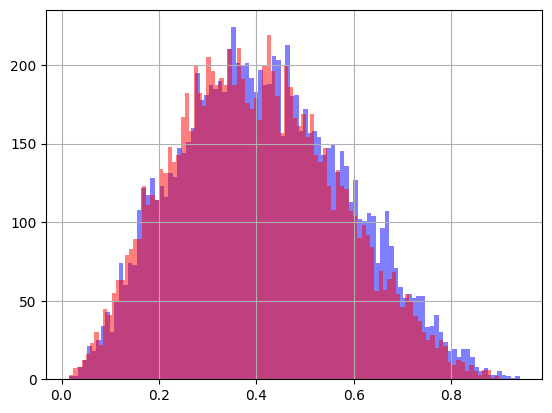

In [527]:
pd.Series(rand_vars_sample_player["q_loss"].rvs(10000)).hist(alpha=0.5, color="b", bins=100)
pd.Series(rand_vars_van_persie["q_loss"].rvs(10000)).hist(alpha=0.5, color="r", bins=100)

Text(0.5, 0, 'PSL')

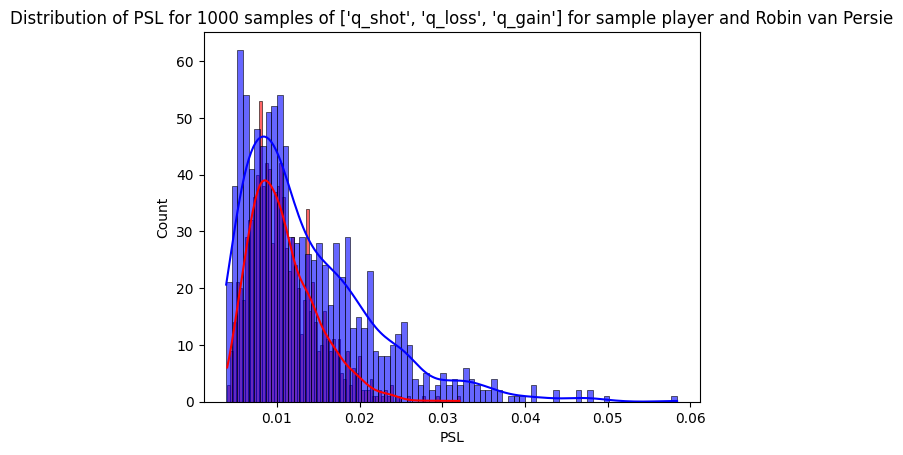

In [523]:
fig, ax = plt.subplots()

sns.histplot(psls, ax=ax, kde=True, color="r", label=sample_player, alpha=0.6, bins=80)
sns.histplot(psls_van_persie, ax=ax, kde=True, color="b", label="Robin van Persie", alpha=0.6, bins=80)

ax.set_title(
    f"Distribution of PSL for {n_samples} samples of {random_vars_keys} for sample player and Robin van Persie"
)
ax.set_xlabel("PSL")

### KDE

<Axes: xlabel='losses_prob', ylabel='Count'>

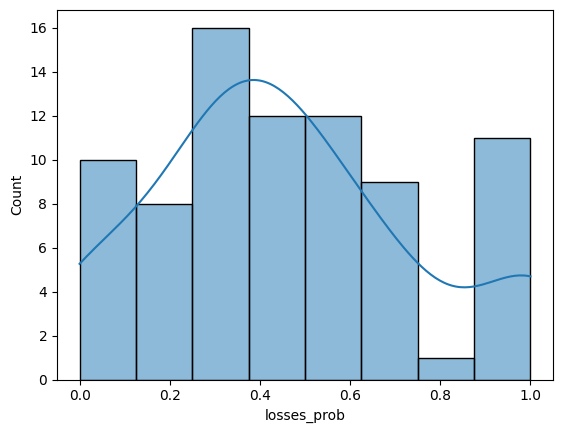

In [549]:
losses = tp_ds[tp_ds["player_id"] == id_sample_player]["losses_prob"]

sns.histplot(losses, kde=True)

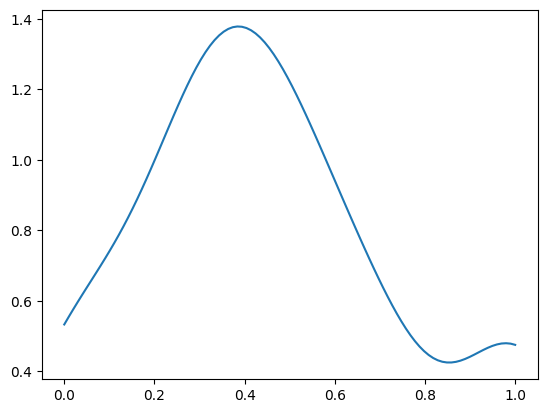

In [550]:
# Kernel Density Estimation of the losses_prob for the sample player

from scipy.stats import gaussian_kde

kde = gaussian_kde(losses)

x = np.linspace(0, 1, 100)
y = kde(x)

fig, ax = plt.subplots()

ax.plot(x, y)

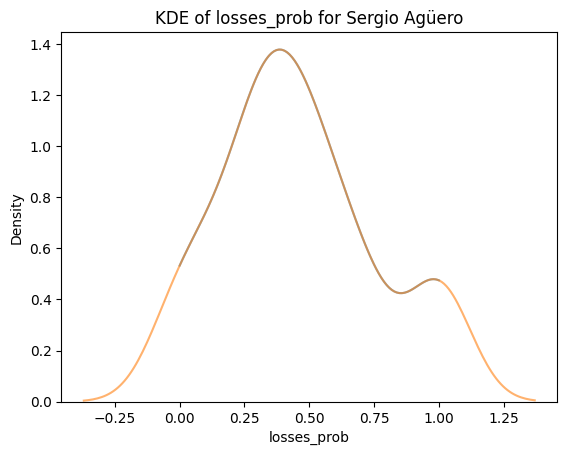

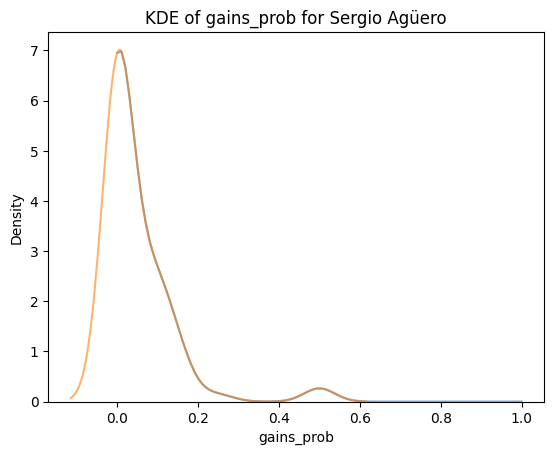

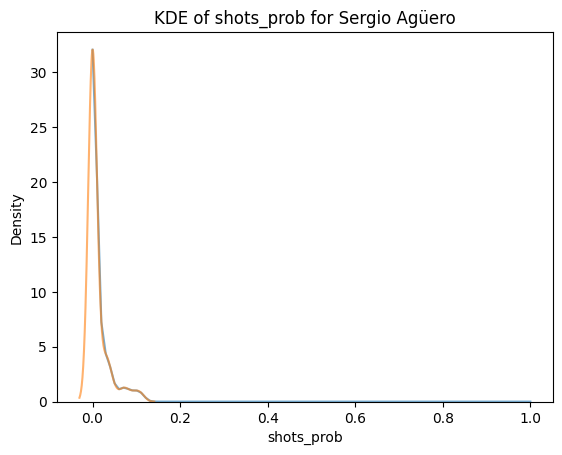

In [563]:
for prob in ["losses_prob", "gains_prob", "shots_prob"]:
    fig, ax = plt.subplots()

    probs = tp_ds[tp_ds["player_id"] == id_sample_player][prob]

    kde = gaussian_kde(probs)

    x = np.linspace(0, 1, 100)
    y = kde(x)

    ax.plot(x, y, alpha=0.6)

    # sns.histplot(probs, kde=True, ax=ax)
    sns.kdeplot(probs, ax=ax, alpha=0.6)

    ax.set_title(f"KDE of {prob} for {sample_player}")

In [568]:
for prob in ["losses_prob", "gains_prob", "shots_prob"]:
    print(tp_ds[tp_ds["player_id"] == id_sample_player][prob])

422      0.333333
4713     0.652174
4727     0.500000
4744     0.583333
6002     0.387097
           ...   
39287    0.352941
40509    0.473684
40525    0.292683
41015    0.444444
41028    0.076923
Name: losses_prob, Length: 79, dtype: float64
422      0.000000
4713     0.043478
4727     0.090909
4744     0.083333
6002     0.048387
           ...   
39287    0.117647
40509    0.105263
40525    0.097561
41015    0.000000
41028    0.000000
Name: gains_prob, Length: 79, dtype: float64
422      0.000000
4713     0.043478
4727     0.000000
4744     0.000000
6002     0.032258
           ...   
39287    0.000000
40509    0.052632
40525    0.000000
41015    0.000000
41028    0.000000
Name: shots_prob, Length: 79, dtype: float64


In [600]:
# Kernel Density Estimation of the distributions

from scipy.stats import gaussian_kde

player_kdes = {}

for player_id in player_ids:
    player_kdes[player_id] = {
        prob: gaussian_kde(probs[probs > 0]) if (probs := tp_ds[tp_ds["player_id"] == player_id][prob]).shape[0] > 3 and probs[probs > 0].shape[0] > 3 else 0
        for prob in [
            "losses_prob",
            "gains_prob",
            "shots_prob",
            "avg_pass_to_prob",
            "avg_pass_from_prob",
        ]  # + [f"pass_to_{i}" for i in range(11)] + [f"pass_from_{i}" for i in range(11)]
    }

player_kdes

{0.0: {'losses_prob': 0,
  'gains_prob': <scipy.stats._kde.gaussian_kde at 0x188dc50c0>,
  'shots_prob': 0,
  'avg_pass_to_prob': <scipy.stats._kde.gaussian_kde at 0x188dc78e0>,
  'avg_pass_from_prob': 0},
 17733.0: {'losses_prob': <scipy.stats._kde.gaussian_kde at 0x188dc4df0>,
  'gains_prob': <scipy.stats._kde.gaussian_kde at 0x1872829e0>,
  'shots_prob': <scipy.stats._kde.gaussian_kde at 0x1872838b0>,
  'avg_pass_to_prob': <scipy.stats._kde.gaussian_kde at 0x187283b50>,
  'avg_pass_from_prob': <scipy.stats._kde.gaussian_kde at 0x187283a30>},
 19524.0: {'losses_prob': <scipy.stats._kde.gaussian_kde at 0x187282b30>,
  'gains_prob': <scipy.stats._kde.gaussian_kde at 0x187283af0>,
  'shots_prob': <scipy.stats._kde.gaussian_kde at 0x1872835b0>,
  'avg_pass_to_prob': <scipy.stats._kde.gaussian_kde at 0x188d906a0>,
  'avg_pass_from_prob': <scipy.stats._kde.gaussian_kde at 0x187282dd0>},
 15943.0: {'losses_prob': <scipy.stats._kde.gaussian_kde at 0x188d90e80>,
  'gains_prob': <scipy.stats._

In [669]:
n_samples = 1000

# print(lis, positions)

# for prob_key in rand_vars_sample_player.keys():
random_vars_keys = [
    # "losses_prob",
    "gains_prob",
    "shots_prob",
    # "avg_pass_to_prob",
    # "avg_pass_from_prob",
]

match_ids = s_ds[s_ds["player_id"] == id_sample_player]["match_id"].values

match_indexes = []
for pi, partido in enumerate(partidos):
    if partido["match_id"].values[0] in match_ids:
        match_indexes.append(pi)

team_indexes = []
for pi in match_indexes:
    match = partidos[pi]
    for ti, equipo in enumerate(separar_partido_en_equipo_pov(match)):
        if equipo["home_team_id"].values[0] == equipo["team_id"].values[0]:
            team_indexes.append((pi, ti))

kdes = []
kdes_van_persie = []

psls_history = []
psls_history_van_persie = []

durations = []

for match_index, ti in team_indexes:
    psls = []
    psls_van_persie = []
    durations.append(R_storage[match_index, ti, :, 0, 0])

    print(match_index, ti)
    for prob_key in random_vars_keys:
        Q_lis_alt_inner = Q_storage[match_index, ti].copy()
        names = Q_storage[match_index, ti, :, 0, 2:-2]
        lis, positions = np.where(names == id_sample_player)

        kde_aguero = player_kdes[id_sample_player][prob_key]
        kde_van_persie = player_kdes[id_van_persie][prob_key]

        if kde_aguero == 0 or kde_van_persie == 0:
            continue

        if kde_aguero == 0:
            # continue
            q_samples_aguero = np.zeros(n_samples)
        else:
            q_samples_aguero = kde_aguero.resample(n_samples)[0]

        if kde_van_persie == 0:
            # continue
            q_samples_van_persie = np.zeros(n_samples)
        else:
            q_samples_van_persie = kde_van_persie.resample(n_samples)[0]

        for q_ps_sample, q_ps_van_persie in zip(q_samples_aguero, q_samples_van_persie):
            if prob_key == "avg_pass_to_prob":
                for j in range(11):
                    if i != j:
                        for (
                            li,
                            i,
                        ) in zip(lis, positions):
                            Q_lis_alt_inner[li, i + 1, j + 1] = q_ps_sample
                psls.append(psl_dist_from_rv(Q_lis_alt_inner, lineups))

                for j in range(11):
                    if i != j:
                        for (
                            li,
                            i,
                        ) in zip(lis, positions):
                            Q_lis_alt_inner[li, i + 1, j + i] = q_ps_van_persie
                psls_van_persie.append(psl_dist_from_rv(Q_lis_alt_inner, lineups))

            if prob_key == "avg_pass_from_prob":
                for j in range(11):
                    if i != j:
                        for (
                            li,
                            i,
                        ) in zip(lis, positions):
                            Q_lis_alt_inner[li, j + 1, i + 1] = q_ps_sample
                psls.append(psl_dist_from_rv(Q_lis_alt_inner, lineups))

                for j in range(11):
                    if i != j:
                        for (
                            li,
                            i,
                        ) in zip(lis, positions):
                            Q_lis_alt_inner[li, j + i, i + 1] = q_ps_van_persie
                psls_van_persie.append(psl_dist_from_rv(Q_lis_alt_inner, lineups))

            if prob_key == "losses_prob":
                for (
                    li,
                    i,
                ) in zip(lis, positions):
                    Q_lis_alt_inner[li, i + 1, 13] = q_ps_sample
                psls.append(psl_dist_from_rv(Q_lis_alt_inner, lineups))

                for (
                    li,
                    i,
                ) in zip(lis, positions):
                    Q_lis_alt_inner[li, i + 1, 13] = q_ps_van_persie
                psls_van_persie.append(psl_dist_from_rv(Q_lis_alt_inner, lineups))

            if prob_key == "gains_prob":
                for (
                    li,
                    i,
                ) in zip(lis, positions):
                    Q_lis_alt_inner[li, 1, 1 + i] = q_ps_sample
                psls.append(psl_dist_from_rv(Q_lis_alt_inner, lineups))

                for (
                    li,
                    i,
                ) in zip(lis, positions):
                    Q_lis_alt_inner[li, 1, 1 + i] = q_ps_van_persie
                psls_van_persie.append(psl_dist_from_rv(Q_lis_alt_inner, lineups))

            if prob_key == "shots_prob":
                for (
                    li,
                    i,
                ) in zip(lis, positions):
                    Q_lis_alt[li, i + 1, 14] = q_ps_sample
                psls.append(psl_dist_from_rv(Q_lis_alt, lineups))

                for (
                    li,
                    i,
                ) in zip(lis, positions):
                    Q_lis_alt[li, i + 1, 14] = q_ps_van_persie
                psls_van_persie.append(psl_dist_from_rv(Q_lis_alt, lineups))

    psls_history.append(psls)
    psls_history_van_persie.append(psls_van_persie)


84 0
104 1
113 0
189 0
243 1
255 0
344 1
367 0


In [671]:
# Calculate the KDE for both PSL distributions
p_greaters = []
for psls, psls_van_persie in zip(psls_history, psls_history_van_persie):

    psl_kde_sample_player = gaussian_kde(psls)
    psl_kde_van_persie = gaussian_kde(psls_van_persie)

    # Probability that the PSL of the sample player is greater than the PSL of Robin van Persie

    n_samples = 1000000

    psl_sample_player_samples = psl_kde_sample_player.resample(n_samples)[0]
    psl_van_persie_samples = psl_kde_van_persie.resample(n_samples)[0]

    p_greater = np.mean(psl_sample_player_samples > psl_van_persie_samples)

    kdes.append(psl_kde_sample_player)
    kdes_van_persie.append(psl_kde_van_persie)
    p_greaters.append(p_greater)

In [673]:
np.array(psls_history).shape, np.array(psls_history_van_persie).shape, np.array(p_greaters).shape, np.array(durations).shape

((8, 2000), (8, 2000), (8,), (8, 4))

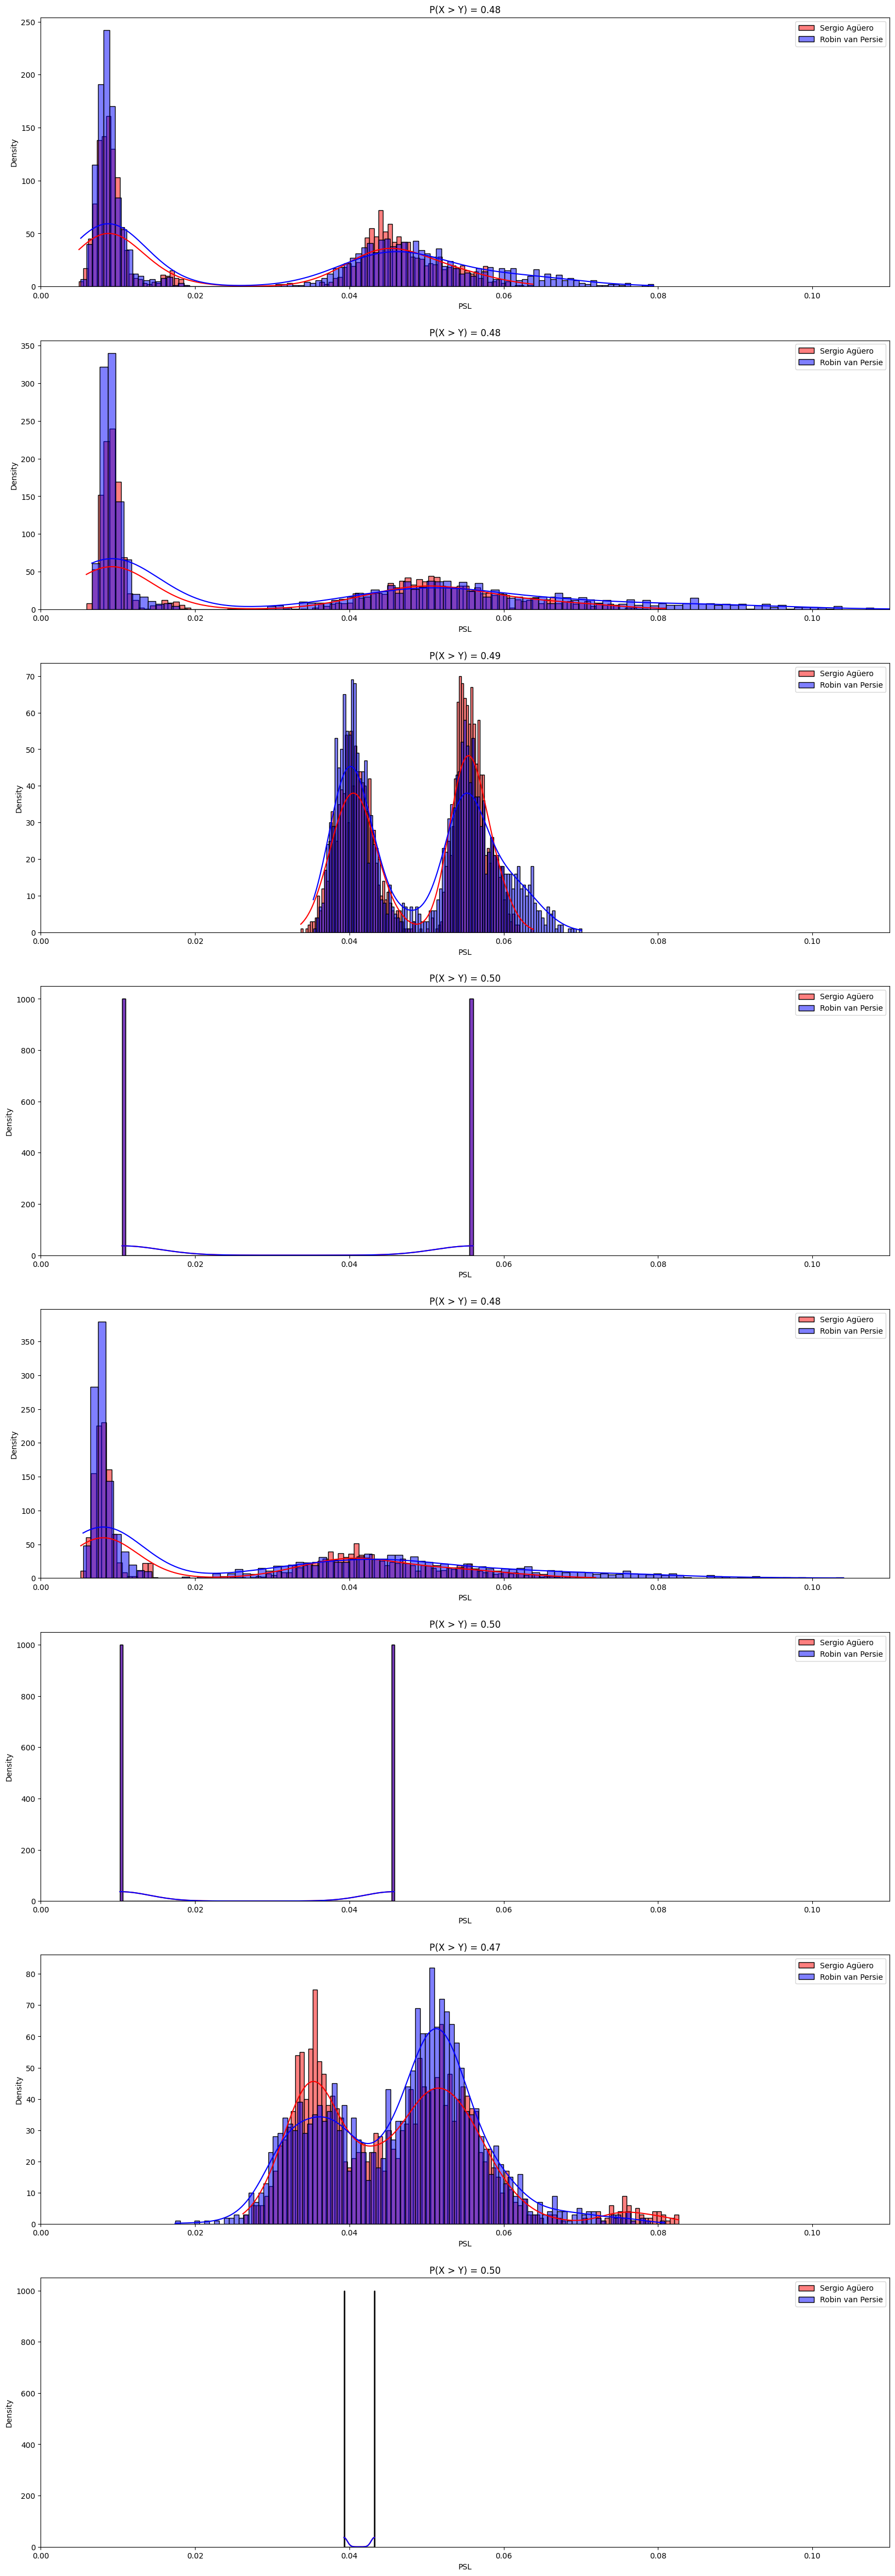

In [668]:
fig, axs = plt.subplots(8, 1, figsize=(20, 60))
for i, ax in enumerate(axs.flat):
    psls = psls_history[i]
    psls_van_persie = psls_history_van_persie[i]

    sample_count = len(psls)
    bin_count = sample_count // 20


    sns.histplot(
        psls, ax=ax, kde=True, color="r", label=sample_player, alpha=0.5, bins=bin_count)
    sns.histplot(
        psls_van_persie,
        ax=ax,
        kde=True,
        color="b",
        label="Robin van Persie",
        alpha=0.5,
        bins=bin_count,
    )


    # ax.set_title(
    #     f"Distribution of PSL for {n_samples} samples of each KDE dist for {random_vars_keys} for {sample_player} and Robin van Persie \n P(PSL_{sample_player} > PSL_van_Persie) = {p_greaters[0]:.2f}"
    # )

    ax.set_title(f"P(X > Y) = {p_greaters[i]:.2f}")

    ax.set_xlabel("PSL")
    ax.set_ylabel("Density")

    ax.set_xlim(
        0, 
        max(
            max([
                max(p) for p in psls_history
            ]),
            max([
                max(p) for p in psls_history_van_persie
            ])
        )
    )


    ax.legend()

In [ ]:
# Kernel Density Estimation of the distributions

from scipy.stats import gaussian_kde

player_kdes = {}

for player_id in player_ids:
    player_kdes[player_id] = {
        prob: gaussian_kde(probs[probs > 0]) if (probs := tp_ds[tp_ds["player_id"] == player_id][prob]).shape[0] > 3 and probs[probs > 0].shape[0] > 3 else 0
        for prob in [
            "losses_prob",
            "gains_prob",
            "shots_prob",
            "avg_pass_to_prob",
            "avg_pass_from_prob",
        ]  # + [f"pass_to_{i}" for i in range(11)] + [f"pass_from_{i}" for i in range(11)]
    }

player_kdes

{0.0: {'losses_prob': 0,
  'gains_prob': <scipy.stats._kde.gaussian_kde at 0x188dc50c0>,
  'shots_prob': 0,
  'avg_pass_to_prob': <scipy.stats._kde.gaussian_kde at 0x188dc78e0>,
  'avg_pass_from_prob': 0},
 17733.0: {'losses_prob': <scipy.stats._kde.gaussian_kde at 0x188dc4df0>,
  'gains_prob': <scipy.stats._kde.gaussian_kde at 0x1872829e0>,
  'shots_prob': <scipy.stats._kde.gaussian_kde at 0x1872838b0>,
  'avg_pass_to_prob': <scipy.stats._kde.gaussian_kde at 0x187283b50>,
  'avg_pass_from_prob': <scipy.stats._kde.gaussian_kde at 0x187283a30>},
 19524.0: {'losses_prob': <scipy.stats._kde.gaussian_kde at 0x187282b30>,
  'gains_prob': <scipy.stats._kde.gaussian_kde at 0x187283af0>,
  'shots_prob': <scipy.stats._kde.gaussian_kde at 0x1872835b0>,
  'avg_pass_to_prob': <scipy.stats._kde.gaussian_kde at 0x188d906a0>,
  'avg_pass_from_prob': <scipy.stats._kde.gaussian_kde at 0x187282dd0>},
 15943.0: {'losses_prob': <scipy.stats._kde.gaussian_kde at 0x188d90e80>,
  'gains_prob': <scipy.stats._

In [ ]:
n_samples = 1000

# print(lis, positions)

# for prob_key in rand_vars_sample_player.keys():
random_vars_keys = [
    # "losses_prob",
    "gains_prob",
    "shots_prob",
    # "avg_pass_to_prob",
    # "avg_pass_from_prob",
]

match_ids = s_ds[s_ds["player_id"] == id_sample_player]["match_id"].values

match_indexes = []
for pi, partido in enumerate(partidos):
    if partido["match_id"].values[0] in match_ids:
        match_indexes.append(pi)

team_indexes = []
for pi in match_indexes:
    match = partidos[pi]
    for ti, equipo in enumerate(separar_partido_en_equipo_pov(match)):
        if equipo["home_team_id"].values[0] == equipo["team_id"].values[0]:
            team_indexes.append((pi, ti))

kdes = []
kdes_van_persie = []

psls_history = []
psls_history_van_persie = []

durations = []

for match_index, ti in team_indexes:
    psls = []
    psls_van_persie = []
    durations.append(R_storage[match_index, ti, :, 0, 0])

    print(match_index, ti)
    for prob_key in random_vars_keys:
        Q_lis_alt_inner = Q_storage[match_index, ti].copy()
        names = Q_storage[match_index, ti, :, 0, 2:-2]
        lis, positions = np.where(names == id_sample_player)

        kde_aguero = player_kdes[id_sample_player][prob_key]
        kde_van_persie = player_kdes[id_van_persie][prob_key]

        if kde_aguero == 0 or kde_van_persie == 0:
            continue

        if kde_aguero == 0:
            # continue
            q_samples_aguero = np.zeros(n_samples)
        else:
            q_samples_aguero = kde_aguero.resample(n_samples)[0]

        if kde_van_persie == 0:
            # continue
            q_samples_van_persie = np.zeros(n_samples)
        else:
            q_samples_van_persie = kde_van_persie.resample(n_samples)[0]

        for q_ps_sample, q_ps_van_persie in zip(q_samples_aguero, q_samples_van_persie):
            if prob_key == "avg_pass_to_prob":
                for j in range(11):
                    if i != j:
                        for (
                            li,
                            i,
                        ) in zip(lis, positions):
                            Q_lis_alt_inner[li, i + 1, j + 1] = q_ps_sample
                psls.append(psl_dist_from_rv(Q_lis_alt_inner, lineups))

                for j in range(11):
                    if i != j:
                        for (
                            li,
                            i,
                        ) in zip(lis, positions):
                            Q_lis_alt_inner[li, i + 1, j + i] = q_ps_van_persie
                psls_van_persie.append(psl_dist_from_rv(Q_lis_alt_inner, lineups))

            if prob_key == "avg_pass_from_prob":
                for j in range(11):
                    if i != j:
                        for (
                            li,
                            i,
                        ) in zip(lis, positions):
                            Q_lis_alt_inner[li, j + 1, i + 1] = q_ps_sample
                psls.append(psl_dist_from_rv(Q_lis_alt_inner, lineups))

                for j in range(11):
                    if i != j:
                        for (
                            li,
                            i,
                        ) in zip(lis, positions):
                            Q_lis_alt_inner[li, j + i, i + 1] = q_ps_van_persie
                psls_van_persie.append(psl_dist_from_rv(Q_lis_alt_inner, lineups))

            if prob_key == "losses_prob":
                for (
                    li,
                    i,
                ) in zip(lis, positions):
                    Q_lis_alt_inner[li, i + 1, 13] = q_ps_sample
                psls.append(psl_dist_from_rv(Q_lis_alt_inner, lineups))

                for (
                    li,
                    i,
                ) in zip(lis, positions):
                    Q_lis_alt_inner[li, i + 1, 13] = q_ps_van_persie
                psls_van_persie.append(psl_dist_from_rv(Q_lis_alt_inner, lineups))

            if prob_key == "gains_prob":
                for (
                    li,
                    i,
                ) in zip(lis, positions):
                    Q_lis_alt_inner[li, 1, 1 + i] = q_ps_sample
                psls.append(psl_dist_from_rv(Q_lis_alt_inner, lineups))

                for (
                    li,
                    i,
                ) in zip(lis, positions):
                    Q_lis_alt_inner[li, 1, 1 + i] = q_ps_van_persie
                psls_van_persie.append(psl_dist_from_rv(Q_lis_alt_inner, lineups))

            if prob_key == "shots_prob":
                for (
                    li,
                    i,
                ) in zip(lis, positions):
                    Q_lis_alt[li, i + 1, 14] = q_ps_sample
                psls.append(psl_dist_from_rv(Q_lis_alt, lineups))

                for (
                    li,
                    i,
                ) in zip(lis, positions):
                    Q_lis_alt[li, i + 1, 14] = q_ps_van_persie
                psls_van_persie.append(psl_dist_from_rv(Q_lis_alt, lineups))

    psls_history.append(psls)
    psls_history_van_persie.append(psls_van_persie)


84 0
104 1
113 0
189 0
243 1
255 0
344 1
367 0


In [ ]:
# Calculate the KDE for both PSL distributions
p_greaters = []
for psls, psls_van_persie in zip(psls_history, psls_history_van_persie):

    psl_kde_sample_player = gaussian_kde(psls)
    psl_kde_van_persie = gaussian_kde(psls_van_persie)

    # Probability that the PSL of the sample player is greater than the PSL of Robin van Persie

    n_samples = 1000000

    psl_sample_player_samples = psl_kde_sample_player.resample(n_samples)[0]
    psl_van_persie_samples = psl_kde_van_persie.resample(n_samples)[0]

    p_greater = np.mean(psl_sample_player_samples > psl_van_persie_samples)

    kdes.append(psl_kde_sample_player)
    kdes_van_persie.append(psl_kde_van_persie)
    p_greaters.append(p_greater)

In [ ]:
np.array(psls_history).shape, np.array(psls_history_van_persie).shape, np.array(p_greaters).shape, np.array(durations).shape

((8, 2000), (8, 2000), (8,), (8, 4))

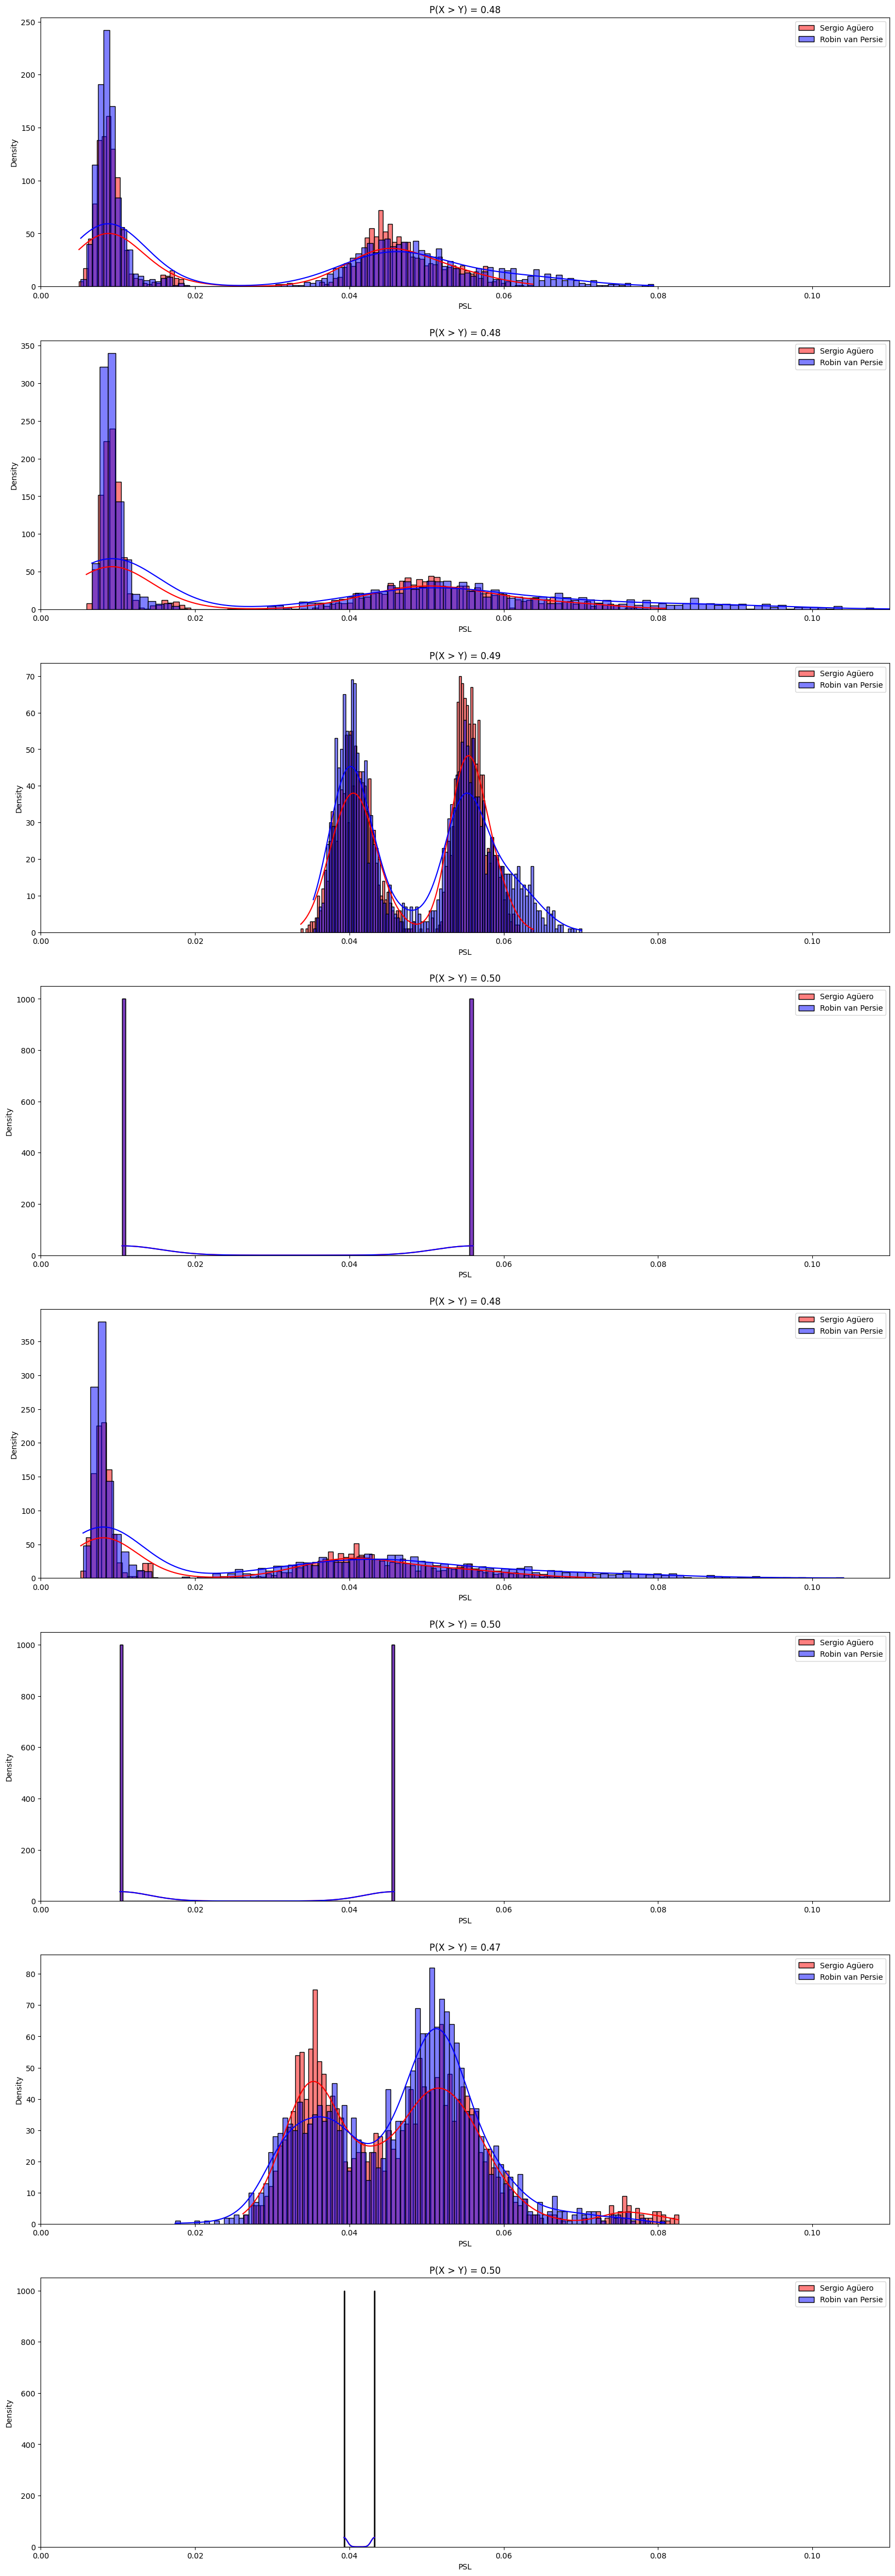

In [ ]:
fig, axs = plt.subplots(8, 1, figsize=(20, 60))
for i, ax in enumerate(axs.flat):
    psls = psls_history[i]
    psls_van_persie = psls_history_van_persie[i]

    sample_count = len(psls)
    bin_count = sample_count // 20


    sns.histplot(
        psls, ax=ax, kde=True, color="r", label=sample_player, alpha=0.5, bins=bin_count)
    sns.histplot(
        psls_van_persie,
        ax=ax,
        kde=True,
        color="b",
        label="Robin van Persie",
        alpha=0.5,
        bins=bin_count,
    )


    # ax.set_title(
    #     f"Distribution of PSL for {n_samples} samples of each KDE dist for {random_vars_keys} for {sample_player} and Robin van Persie \n P(PSL_{sample_player} > PSL_van_Persie) = {p_greaters[0]:.2f}"
    # )

    ax.set_title(f"P(X > Y) = {p_greaters[i]:.2f}")

    ax.set_xlabel("PSL")
    ax.set_ylabel("Density")

    ax.set_xlim(
        0, 
        max(
            max([
                max(p) for p in psls_history
            ]),
            max([
                max(p) for p in psls_history_van_persie
            ])
        )
    )


    ax.legend()

In [728]:
def calculate_player_kdes(tp_ds, player_ids):
    player_kdes = {}
    for player_id in player_ids:
        player_kdes[player_id] = {
            prob: (
                gaussian_kde(probs[probs > 0])
                if (probs := tp_ds[tp_ds["player_id"] == player_id][prob]).shape[0] > 3
                and probs[probs > 0].shape[0] > 3
                else 0
            )
            for prob in [
                "losses_prob",
                "gains_prob",
                "shots_prob",
                "avg_pass_to_prob",
                "avg_pass_from_prob",
            ]
        }
    return player_kdes


def get_match_and_team_indexes(id_player, s_ds, partidos):
    match_ids = s_ds[s_ds["player_id"] == id_player]["match_id"].values
    match_indexes = [
        pi
        for pi, partido in enumerate(partidos)
        if partido["match_id"].values[0] in match_ids
    ]
    team_indexes = []
    for pi in match_indexes:
        match = partidos[pi]
        for ti, equipo in enumerate(separar_partido_en_equipo_pov(match)):
            if equipo["home_team_id"].values[0] == equipo["team_id"].values[0]:
                team_indexes.append((pi, ti))
    return team_indexes


def update_Q_lis_alt_inner(Q_lis_alt_inner, lis, positions, q_ps_sample, prob_key):
    for li, i in zip(lis, positions):
        if prob_key == "avg_pass_to_prob":
            for j in range(11):
                if i != j:
                        Q_lis_alt_inner[li, i + 1, j + 1] = q_ps_sample
        elif prob_key == "avg_pass_from_prob":
            for j in range(11):
                if i != j:
                        Q_lis_alt_inner[li, j + 1, i + 1] = q_ps_sample
        elif prob_key == "losses_prob":
                Q_lis_alt_inner[li, i + 1, 13] = q_ps_sample
        elif prob_key == "gains_prob":
                Q_lis_alt_inner[li, 1, 1 + i] = q_ps_sample
        elif prob_key == "shots_prob":
                Q_lis_alt_inner[li, i + 1, 14] = q_ps_sample


def calculate_psls_for_match(
    match_index,
    ti,
    id_player_1,
    id_player_2,
    Q_storage,
    R_storage,
    lineups,
    player_kdes,
    random_vars_keys,
    n_samples,
):
    psls = []
    psls_van_persie = []
    durations = R_storage[match_index, ti, :, 0, 0]

    for prob_key in random_vars_keys:
        # Q_lis_alt_inner = Q_storage[match_index, ti].copy()
        names = Q_storage[match_index, ti, :, 0, 2:-2]
        lis, positions = np.where(names == id_player_1)

        kde_aguero = player_kdes[id_player_1][prob_key]
        kde_van_persie = player_kdes[id_player_2][prob_key]

        if kde_aguero == 0 or kde_van_persie == 0:
            continue

        # print(type(kde_aguero))
        # print(type(kde_aguero.resample(n_samples)))

        q_samples_aguero = (
            kde_aguero.resample(n_samples)[0]
            if kde_aguero != 0
            else np.zeros(n_samples)
        )
        q_samples_van_persie = (
            kde_van_persie.resample(n_samples)[0]
            if kde_van_persie != 0
            else np.zeros(n_samples)
        )

        for q_ps_sample, q_ps_van_persie in zip(q_samples_aguero, q_samples_van_persie):

            Q_TM = Q_storage[match_index, ti].copy()
            update_Q_lis_alt_inner(Q_TM, lis, positions, q_ps_sample, prob_key)
            psls.append(psl_dist_from_rv(Q_TM, lineups))

            Q_TM = Q_storage[match_index, ti].copy()
            update_Q_lis_alt_inner(Q_TM, lis, positions, q_ps_van_persie, prob_key)
            psls_van_persie.append(psl_dist_from_rv(Q_TM, lineups))

    return np.array(psls), np.array(psls_van_persie), durations


def calculate_psls_and_probability(
    id_player_1,
    id_player_2,
    tp_ds,
    s_ds,
    partidos,
    Q_storage,
    R_storage,
    lineups,
    player_kdes,
    random_vars_keys = ["gains_prob", "shots_prob"],
    n_samples=1000,
    n_kde_samples=1000000,
):
    team_indexes = get_match_and_team_indexes(id_player_1, s_ds, partidos)

    psls_history = []
    psls_history_van_persie = []

    for match_index, ti in team_indexes:
        psls, psls_van_persie, _ = calculate_psls_for_match(
            match_index,
            ti,
            id_player_1,
            id_player_2,
            Q_storage,
            R_storage,
            lineups,
            player_kdes,
            random_vars_keys,
            n_samples,
        )
        psls_history.append(psls)
        psls_history_van_persie.append(psls_van_persie)

    # Calculate the KDE for both PSL distributions
    p_greaters = []
    for psls, psls_van_persie in zip(psls_history, psls_history_van_persie):
        if len(psls) == 0 or len(psls_van_persie) == 0:
            continue

        psl_kde_sample_player = gaussian_kde(psls)
        psl_kde_van_persie = gaussian_kde(psls_van_persie)

        # Probability that the PSL of the sample player is greater than the PSL of Robin van Persie
        psl_sample_player_samples = psl_kde_sample_player.resample(n_kde_samples)[0]
        psl_van_persie_samples = psl_kde_van_persie.resample(n_kde_samples)[0]

        p_greater = np.mean(psl_sample_player_samples > psl_van_persie_samples)
        p_greaters.append(p_greater)

    return (
        np.array(psls_history),
        np.array(psls_history_van_persie),
        np.array(p_greaters),
    )

In [724]:
player_ids = tp_ds["player_id"].unique()
player_kdes = calculate_player_kdes(tp_ds, player_ids)

In [711]:
from scipy import stats

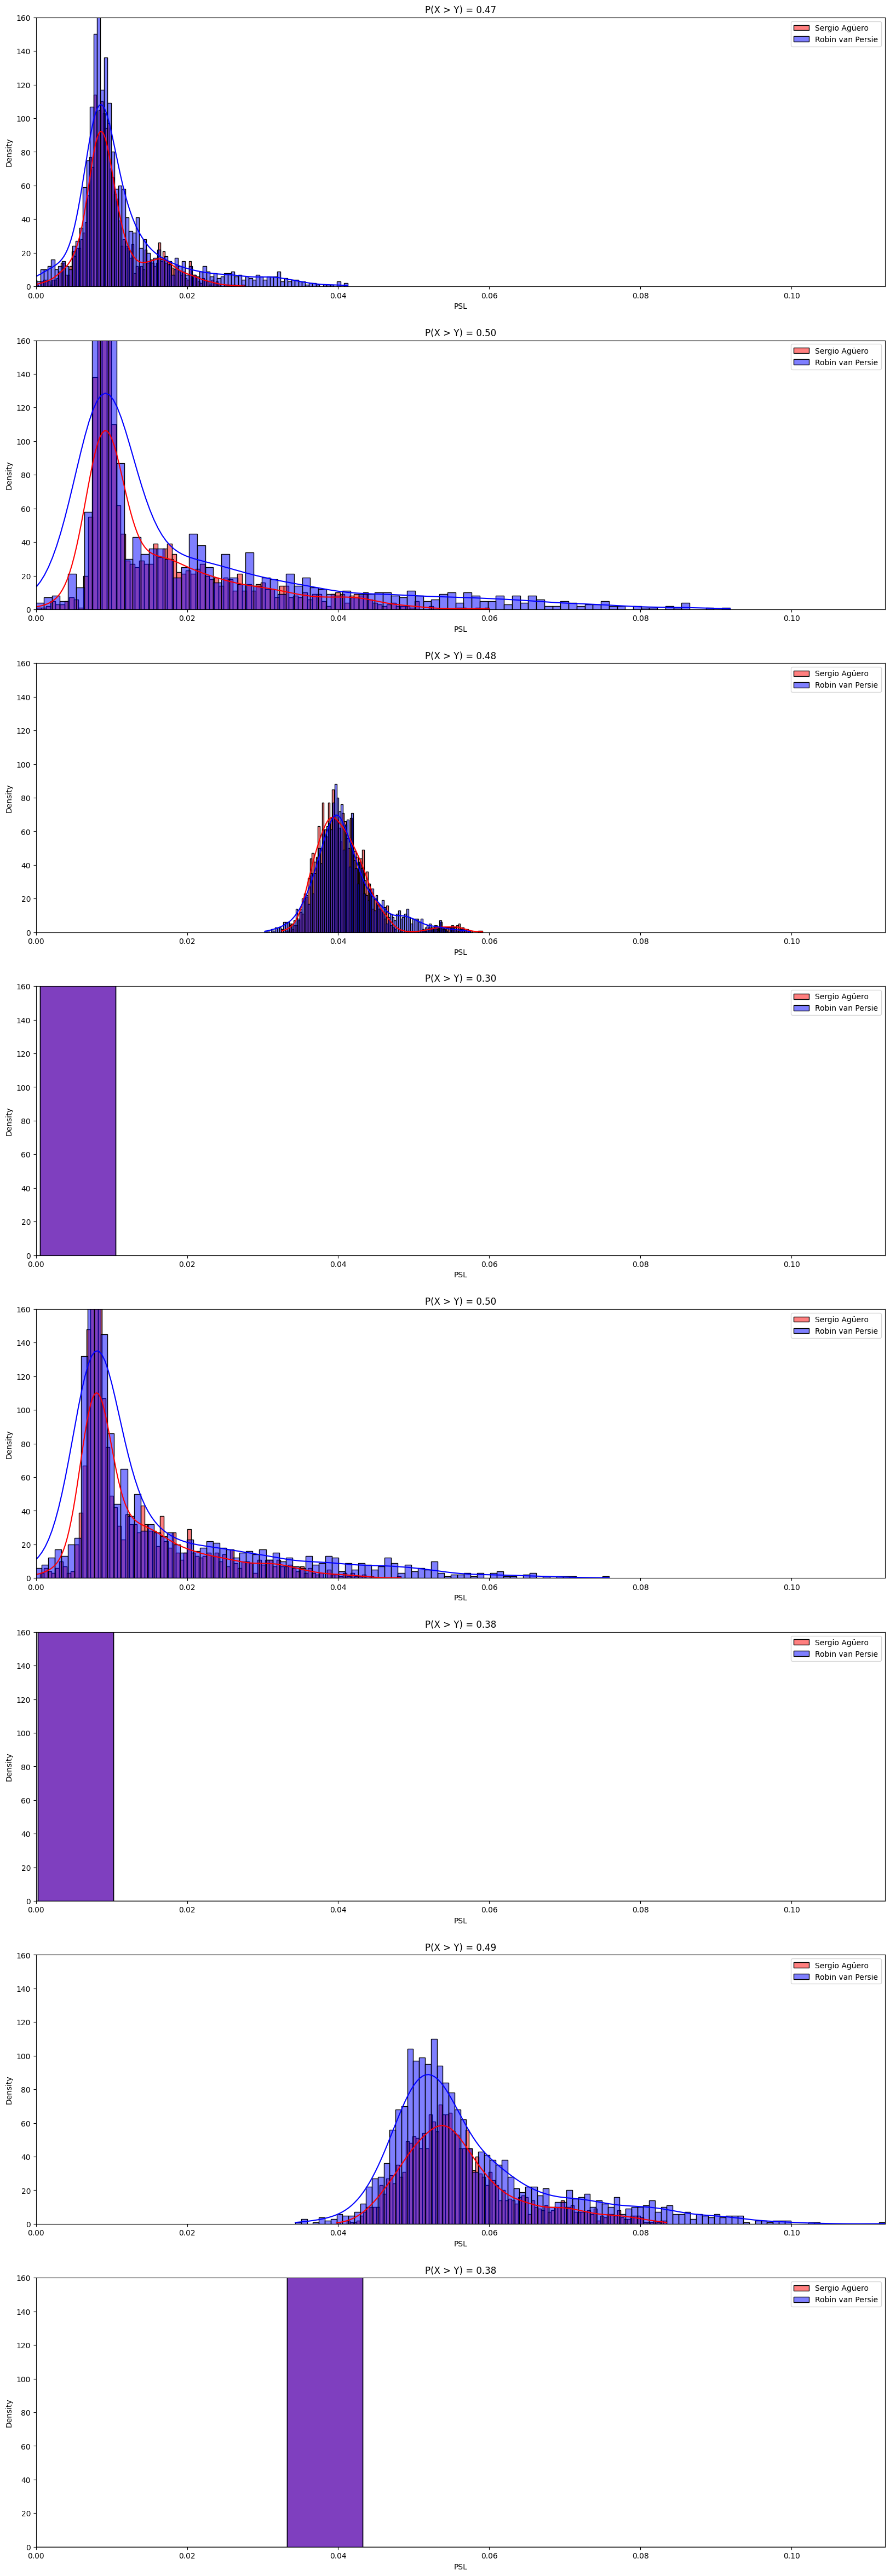

In [730]:
# Ejemplo de uso
id_sample_player = epl_player_data.get_player_id_by_name("Sergio Agüero")
id_van_persie = epl_player_data.get_player_id_by_name("Robin van Persie")

psls_history_aguero, psls_history_van_persie, p_greater = (
    calculate_psls_and_probability(
        id_sample_player,
        id_van_persie,
        tp_ds,
        s_ds,
        partidos,
        Q_storage,
        R_storage,
        lineups,
        player_kdes,
    )
)

plot_count = len(psls_history_aguero)
fig, axs = plt.subplots(plot_count, 1, figsize=(20, 60))

for i, ax in enumerate(axs.flat):
    psls = psls_history_aguero[i]
    psls_van_persie = psls_history_van_persie[i]

    sample_count = psls.shape[0]
    bin_count = sample_count // 20

    sns.histplot(
        psls, ax=ax, kde=True, color="r", label=sample_player, alpha=0.5, bins=bin_count
    )
    sns.histplot(
        psls_van_persie,
        ax=ax,
        kde=True,
        color="b",
        label="Robin van Persie",
        alpha=0.5,
        bins=bin_count,
    )

    ax.set_title(f"P(X > Y) = {p_greater[i]:.2f}")

    ax.set_xlabel("PSL")
    ax.set_ylabel("Density")

    ax.set_xlim(
        0,
        np.max(np.concatenate((psls_history_aguero.ravel(), psls_history_van_persie.ravel()))),
    )

    # set_ylim to highest density in all plots
    ax.set_ylim(
        0,
        stats.mode(
            (
                means := [
                    np.mean(np.histogram(p, bins=bin_count)[0])
                    for p in [psls_history_aguero, psls_history_van_persie]
                ]
            )
        )[0] + 2 * np.std(means),
    )

    ax.legend()

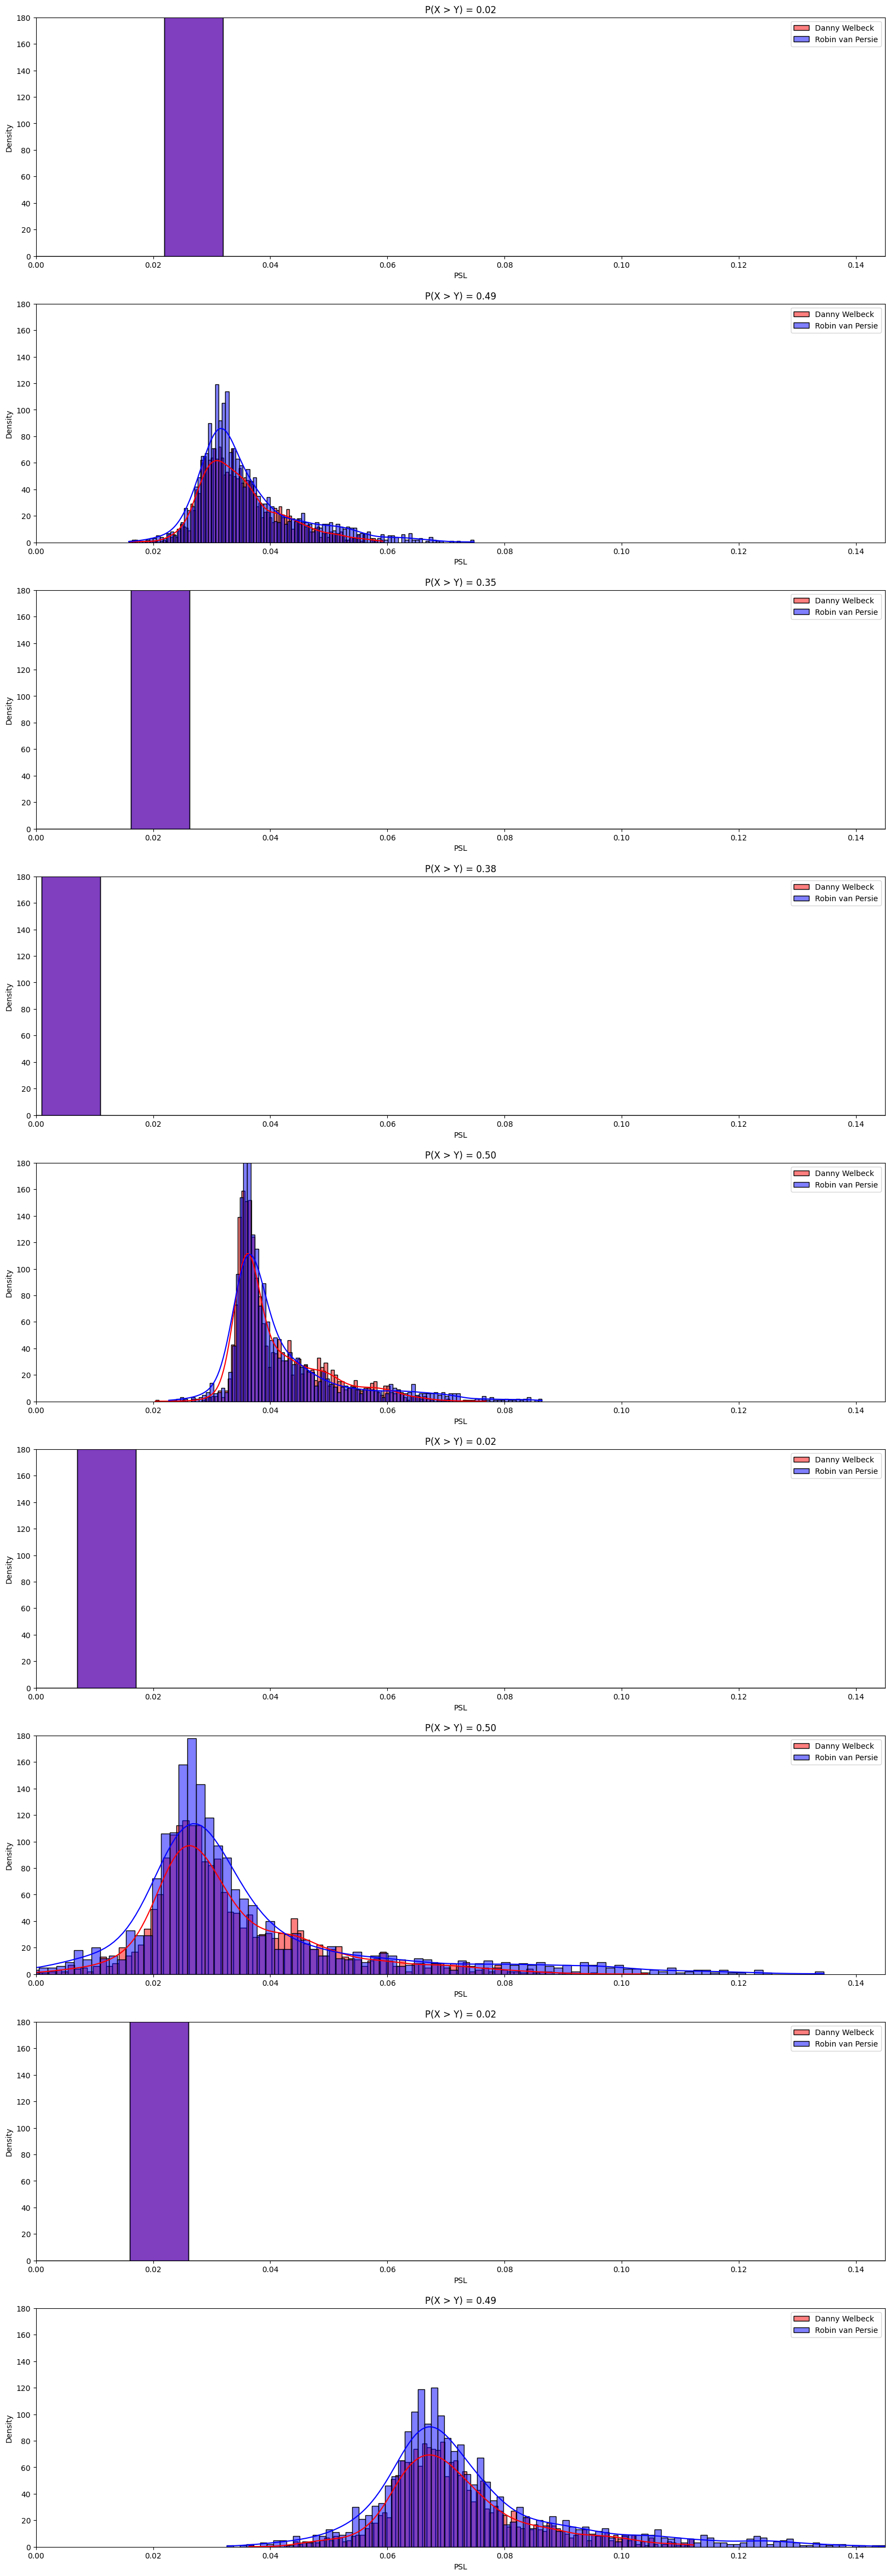

In [732]:
name1 = "Danny Welbeck"
name2 = "Robin van Persie"
id_1 = epl_player_data.get_player_id_by_name(name1)
id_2 = epl_player_data.get_player_id_by_name(name2)

psls_history_1, psls_history_2, p_greater = (
    calculate_psls_and_probability(
        id_1,
        id_2,
        tp_ds,
        s_ds,
        partidos,
        Q_storage,
        R_storage,
        lineups,
        player_kdes,
    )
)

plot_count = len(psls_history_1)
fig, axs = plt.subplots(plot_count, 1, figsize=(20, 60))

for i, ax in enumerate(axs.flat):
    psls = psls_history_1[i]
    psls_2 = psls_history_2[i]

    sample_count = psls.shape[0]
    bin_count = sample_count // 20

    sns.histplot(
        psls, ax=ax, kde=True, color="r", label=name1, alpha=0.5, bins=bin_count
    )
    sns.histplot(
        psls_2,
        ax=ax,
        kde=True,
        color="b",
        label=name2,
        alpha=0.5,
        bins=bin_count,
    )

    ax.set_title(f"P(X > Y) = {p_greater[i]:.2f}")

    ax.set_xlabel("PSL")
    ax.set_ylabel("Density")

    ax.set_xlim(
        0,
        np.max(
            np.concatenate(
                (psls_history_1.ravel(), psls_history_2.ravel())
            )
        ),
    )

    # set_ylim to highest density in all plots
    ax.set_ylim(
        0,
        stats.mode(
            (
                means := [
                    np.mean(np.histogram(p, bins=bin_count)[0])
                    for p in [psls_history_1, psls_history_2]
                ]
            )
        )[0]
        + 2 * np.std(means),
    )

    ax.legend()

# PSL for a Team of 11

In [ ]:
epl["home_team_name"]

In [756]:
team_name = "Manchester City"
# epl[["home_team_name", "home_team_id", "away_team_name", "away_team_id", "team_id", "match_id"]]
# Team id is the same as home_team_id when the team is playing at home, or away_team_id when the team is playing away
team_id = epl[epl["home_team_name"] == team_name]["home_team_id"].values[0]
team_players_ids = []
team_matches = epl[epl["team_id"] == team_id]["match_id"].unique()

team_players = epl[epl["team_id"] == team_id]["player_id"].dropna().unique()
team_players

array([ 37572.,  20312.,  14664.,  49384.,  17476.,   7551.,  15749.,
        20658.,  20664.,  28554.,  17336.,  42544.,  42493.,  42593.,
        15157.,  15076.,  12450.,  93666.,  19534.,  18573.,  19688.,
         1632.,  84702.,  20492., 103040.])

In [783]:
from src.match_data_extraction import get_jugadores

In [785]:
team_formations = []
for pi, partido in enumerate(partidos):
    match_id = partido["match_id"].values[0]
    if match_id in team_matches:
        for ti, equipo in enumerate(separar_partido_en_equipo_pov(partido)):
            _team_id = equipo["team_id"].values[0]
            if _team_id == team_id:
                for li, lineup in enumerate(separar_partido_del_equipo_en_lineups(equipo)):
                    duration = get_lineup_duration(lineup)
                    # players_ids = R_storage[pi, ti, li, 0, 2:-2]
                    players_ids = get_jugadores(lineup)
                    # print(len(list(filter(lambda x: x != 0, players_ids))))
                    team_formations.append((pi, ti, li, duration, set(players_ids)))

len(team_formations)

150

In [786]:
team_formations_count = {}
team_player_appearances = {}

for pi, ti, li, duration, players_ids in team_formations:
    players_ids_tuple = tuple(
        sorted(players_ids)
    )  # Convertir a tupla ordenada para consistencia
    if players_ids_tuple not in team_formations_count:
        team_formations_count[players_ids_tuple] = 0
    team_formations_count[players_ids_tuple] += 1

    for player_id in players_ids:
        if player_id not in team_player_appearances:
            team_player_appearances[player_id] = 0
        team_player_appearances[player_id] += 1

team_player_appearances.values()

dict_values([80, 94, 138, 24, 119, 70, 104, 100, 82, 91, 74, 85, 26, 50, 39, 4, 76, 1, 12, 25, 63, 102, 70, 22, 3])

In [792]:
top_11_team_players = sorted(
    team_player_appearances.items(), key=lambda x: x[1], reverse=True
)[:11]

for p_id, app in top_11_team_players:
    print(epl_player_data.get_player_name(int(p_id)), epl_player_data.get_player_position(int(p_id)), app)

Joe Hart G 138
Yaya Touré M 119
Pablo Zabaleta D 104
Gareth Barry M 102
Gaël Clichy D 100
Vincent Kompany D 94
David Silva M 91
Edin Dzeko F 85
Carlos Tevez F 82
Sergio Agüero F 80
James Milner M 76


In [823]:
list_players = list(np.array(top_11_team_players)[:, 0])
list_players

[15749.0,
 14664.0,
 20658.0,
 1632.0,
 17336.0,
 17476.0,
 20664.0,
 42544.0,
 20312.0,
 37572.0,
 15157.0]

In [818]:
import warnings

# Ignorar FutureWarning
warnings.filterwarnings("ignore", category=FutureWarning, module="pandas")

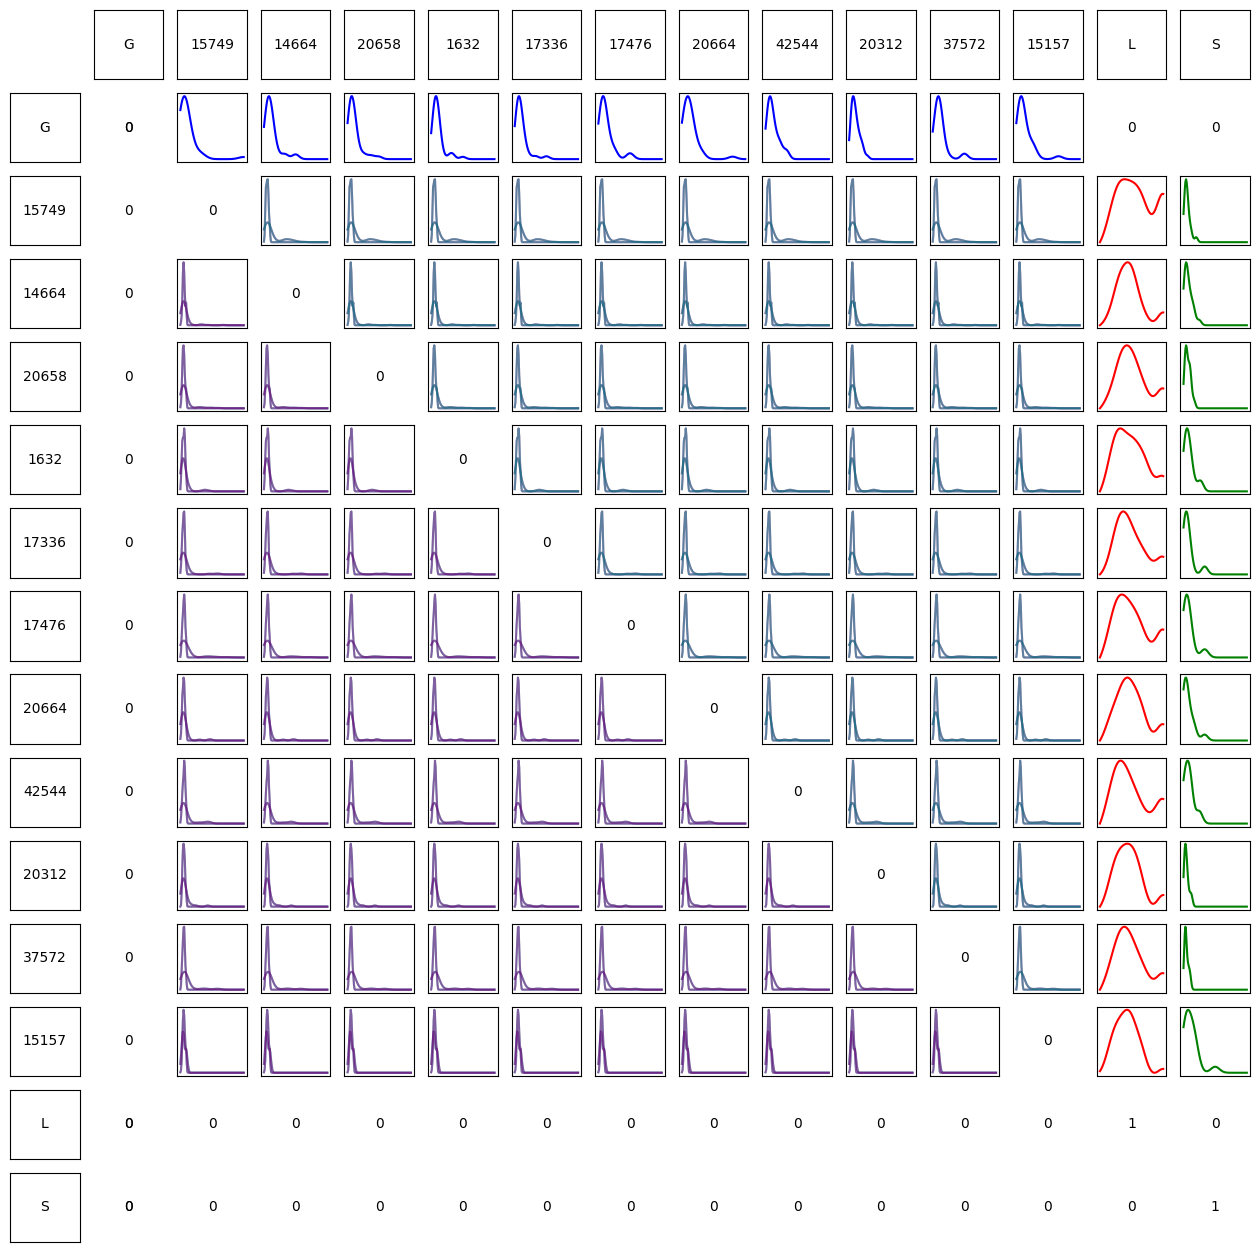

In [845]:
warnings.filterwarnings("ignore")


list_players = list(np.array(top_11_team_players)[:, 0])

def create_dist_TM(list_players, player_kdes):

    matrix = np.zeros((14, 14))
    matrix = pd.DataFrame(matrix, columns=["G"] + list_players + ["L", "S"], index=["G"] + list_players + ["L", "S"])

    dists_cache = {}

    for i, player_id in enumerate(list_players):
        matrix.loc["G", player_id] = player_kdes[player_id]["gains_prob"]
        matrix.loc[player_id, "L"] = player_kdes[player_id]["losses_prob"]
        matrix.loc[player_id, "S"] = player_kdes[player_id]["shots_prob"]

        for j, player_id_2 in enumerate(list_players):

            if i != j:
                if (player_id, player_id_2) not in dists_cache:
                    dists_cache[(player_id, player_id_2)] = []

                if (player_id_2, player_id) not in dists_cache:
                    dists_cache[(player_id_2, player_id)] = []

                dists_cache[(player_id, player_id_2)].append(
                    player_kdes[player_id]["avg_pass_to_prob"]
                )

                dists_cache[(player_id_2, player_id)].append(
                    player_kdes[player_id_2]["avg_pass_from_prob"]
                )
        
    return matrix, dists_cache

def plot_dist_TM(matrix, dists_cache):
    fig, axs_full = plt.subplots(15, 15, figsize=(16, 16))
    players = matrix.columns[1:-2]

    for ax in axs_full.flat:
        # ax.axis("off")
        ax.set_xticks([])
        ax.set_yticks([])

    axs_full[0, 0].axis("off")

    # Plot only names in the first row and column
    for i, player_id in enumerate(players):
        axs_full[0, i + 2].text(0.5, 0.5, int(player_id), ha="center", va="center")
        axs_full[i + 2, 0].text(0.5, 0.5, int(player_id), ha="center", va="center")
        # Remove the x and y ticks

    axs_full[0, 1].text(0.5, 0.5, "G", ha="center", va="center")
    axs_full[1, 0].text(0.5, 0.5, "G", ha="center", va="center")

    axs_full[0, -2].text(0.5, 0.5, "L", ha="center", va="center")
    axs_full[0, -1].text(0.5, 0.5, "S", ha="center", va="center")

    axs_full[-2, 0].text(0.5, 0.5, "L", ha="center", va="center")
    axs_full[-1, 0].text(0.5, 0.5, "S", ha="center", va="center")

    for i in range(15):
        axs_full[i, i].axis("off")

        if i > 0:
            axs_full[-1, i].axis("off")
            axs_full[-2, i].axis("off")
            axs_full[i, 1].axis("off")
            axs_full[i, 1].text(0.5, 0.5, "0", ha="center", va="center")
            if i < 13:
                axs_full[i, i].text(0.5, 0.5, "0", ha="center", va="center")
                axs_full[-1, i].text(0.5, 0.5, "0", ha="center", va="center")
                axs_full[-2, i].text(0.5, 0.5, "0", ha="center", va="center")
            else:
                axs_full[i, i].text(0.5, 0.5, "1", ha="center", va="center")

    axs_full[1, -1].axis("off")
    axs_full[1, -2].axis("off")
    
    axs_full[1, -1].text(0.5, 0.5, "0", ha="center", va="center")
    axs_full[1, -2].text(0.5, 0.5, "0", ha="center", va="center")
    
    axs_full[-2, -1].text(0.5, 0.5, "0", ha="center", va="center")
    axs_full[-1, -2].text(0.5, 0.5, "0", ha="center", va="center")

    axs = axs_full[1:, 1:]

    for i, player_id in enumerate(players):
        axs[0, i + 1].plot(
            np.linspace(0, 1, 100),
            matrix.loc["G", player_id].evaluate(np.linspace(0, 1, 100)),
            color="blue"
        )

        axs[i + 1, -2].plot(
            np.linspace(0, 1, 100),
            matrix.loc[player_id, "L"].evaluate(np.linspace(0, 1, 100)),
            color="red"
        )

        axs[i + 1, -1].plot(
            np.linspace(0, 1, 100),
            matrix.loc[player_id, "S"].evaluate(np.linspace(0, 1, 100)),
            color="green"
        )

        for j, player_id_2 in enumerate(players):
            if i != j:
                for dists in dists_cache[(player_id, player_id_2)]:
                    axs[i + 1, j + 1].plot(
                        np.linspace(0, 1, 100),
                        dists.evaluate(np.linspace(0, 1, 100)),
                        color="purple",
                        alpha=0.5
                    )

                for dists in dists_cache[(player_id_2, player_id)]:
                    axs[j + 1, i + 1].plot(
                        np.linspace(0, 1, 100),
                        dists.evaluate(np.linspace(0, 1, 100)),
                        color="teal",
                        alpha=0.5
                    )

plot_dist_TM(*create_dist_TM(list_players, player_kdes))

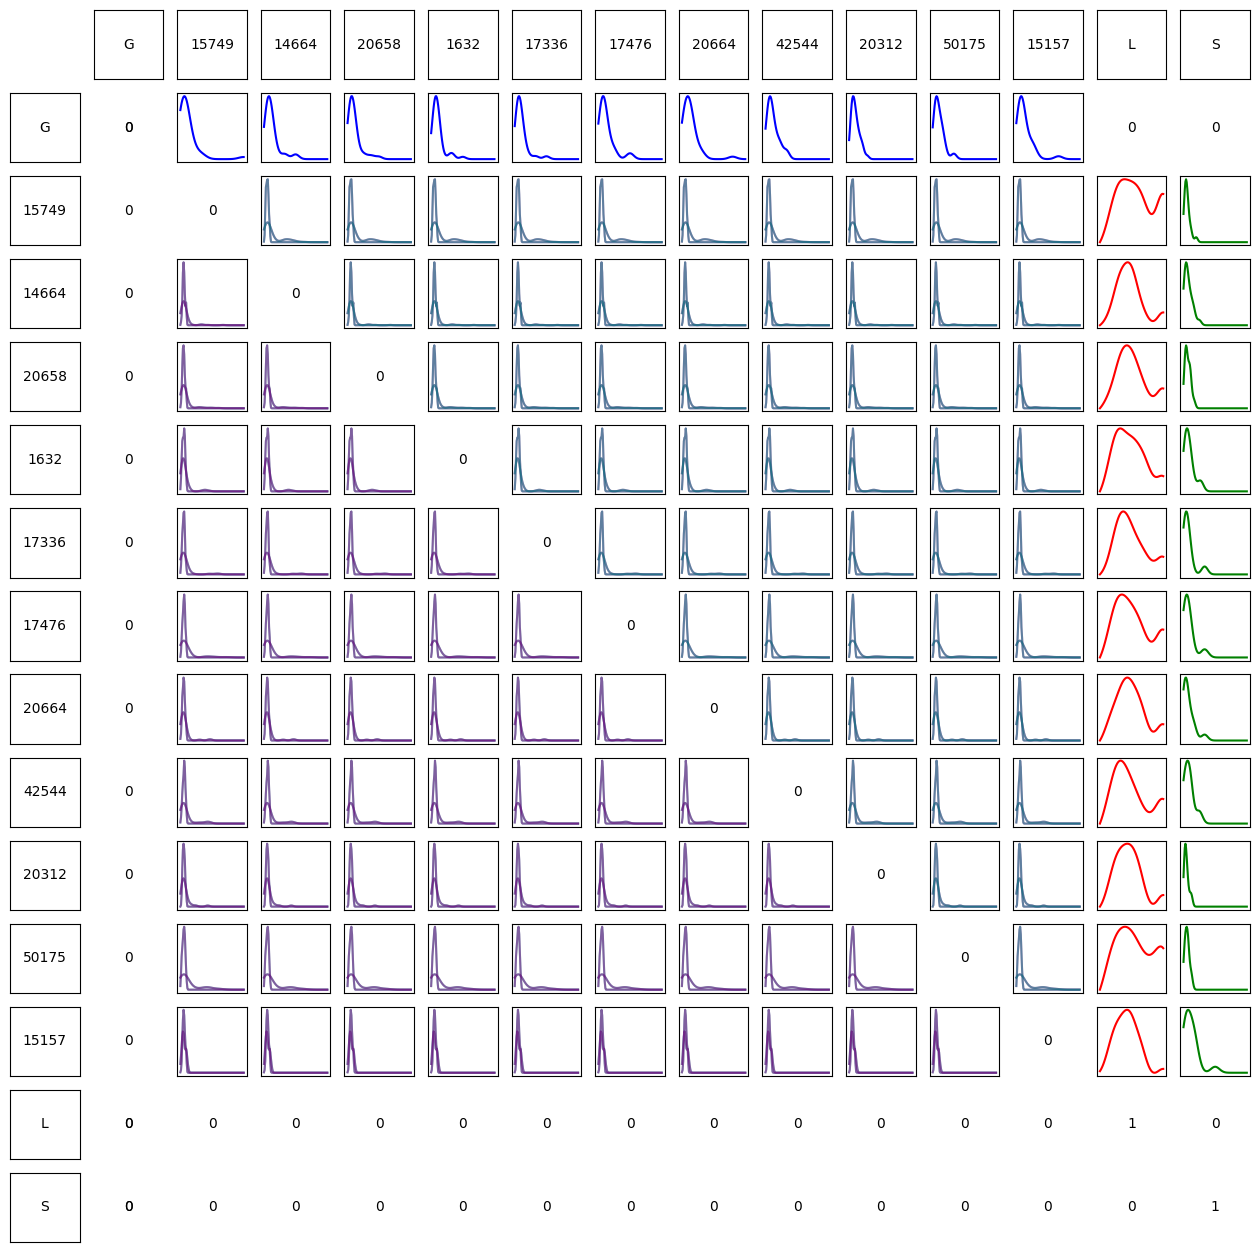

In [851]:
# Replace id of aguero with id of Danny Welbeck
list_players = list(np.array(top_11_team_players)[:, 0])

pos_aguero = list_players.index(epl_player_data.get_player_id_by_name("Sergio Agüero"))
list_players[pos_aguero] = epl_player_data.get_player_id_by_name("Danny Welbeck")

plot_dist_TM(*create_dist_TM(list_players, player_kdes))

100%|██████████| 1000/1000 [01:09<00:00, 14.29it/s]


<Axes: ylabel='Count'>

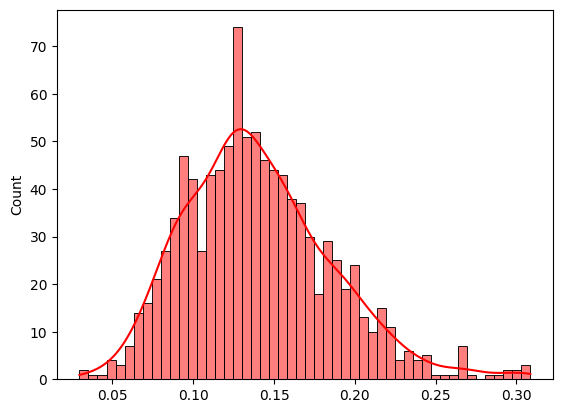

In [864]:
def build_R_from_dists(matrix, dists_cache, list_players):
    R = np.zeros((14, 14))
    R = pd.DataFrame(R, columns=["G"] + list_players + ["L", "S"], index=["G"] + list_players + ["L", "S"])

    nonnegative = lambda x: x if x > 0 else 0

    for i, player_id in enumerate(list_players):
        R.loc["G", player_id] = nonnegative(matrix.loc["G", player_id].resample(1)[0][0])
        R.loc[player_id, "L"] = nonnegative(matrix.loc[player_id, "L"].resample(1)[0][0])
        R.loc[player_id, "S"] = nonnegative(matrix.loc[player_id, "S"].resample(1)[0][0])

        for j, player_id_2 in enumerate(list_players):
            if i != j:
                R.loc[player_id, player_id_2] = nonnegative(np.mean(
                    [dist.resample(1)[0][0] for dist in dists_cache[(player_id, player_id_2)]]
                ))
                R.loc[player_id_2, player_id] = nonnegative(np.mean(
                    [dist.resample(1)[0][0] for dist in dists_cache[(player_id_2, player_id)]]
                ))

    return R


psls = []
psl_sample_counts = 1000
list_players = list(np.array(top_11_team_players)[:, 0])

for i in tqdm(range(psl_sample_counts)):
    R = build_R_from_dists(*create_dist_TM(list_players, player_kdes), list_players).values
    Q = build_Q(R)
    psls.append(psl_estimator(Q))

sns.histplot(psls, kde=True, color="r", alpha=0.5, bins=psl_sample_counts // 20)

In [865]:
def estimate_psl_distribution(psl_sample_counts, list_players, player_kdes):
    psls = []

    for _ in tqdm(range(psl_sample_counts)):
        R = build_R_from_dists(*create_dist_TM(list_players, player_kdes), list_players).values
        Q = build_Q(R)
        psls.append(psl_estimator(Q))

    return psls

def replace_player_in_list_players(list_players, old_player_name, new_player_name):
    pos_old = list_players.index(epl_player_data.get_player_id_by_name(old_player_name))
    list_players[pos_old] = epl_player_data.get_player_id_by_name(new_player_name)
    return list_players

def probability_psl_greater_than(psls, psls_2, n_kde_samples=10000):
    psl_kde_1 = gaussian_kde(psls)
    psl_kde_2 = gaussian_kde(psls_2)

    # Probability that the PSL of the sample player is greater than the PSL of Robin van Persie
    psl_1_samples = psl_kde_1.resample(n_kde_samples)[0]
    psl_2_samples = psl_kde_2.resample(n_kde_samples)[0]

    p_greater = np.mean(psl_1_samples > psl_2_samples)
    p_greaters.append(p_greater)

    return p_greater

In [870]:
""" 
Similares a Sergio Agüero

Theo Walcott 20467 (Arsenal): 0.9998905062675476 - F
Franco Di Santo 49724 (Wigan Athletic): 0.9997592568397522 - F
Olivier Giroud 44346 (Arsenal): 0.9997231960296631 - F
Wayne Rooney 13017 (Everton): 0.9994319677352905 - F
Romelu Lukaku 66749 (West Bromwich Albion): 0.9994180798530579 - F
Adam Le Fondre 19163 (Reading): 0.9994012713432312 - F
Jonathan Walters 12813 (Reading): 0.998664915561676 - F
Marc-Antoine Fortuné 14279 (West Bromwich Albion): 0.9986159205436707 - F
Itay Shechter 74363 (Aston Villa): 0.9984821677207947 - F
Grant Holt 5741 (Fulham): 0.99833083152771 - F
"""

top_similar_players = [
    "Theo Walcott",
    "Franco Di Santo",
    "Olivier Giroud",
    "Wayne Rooney",
    "Romelu Lukaku",
    "Adam Le Fondre",
    "Jonathan Walters",
    "Marc-Antoine Fortuné",
    "Itay Shechter",
    "Grant Holt",
]

list_players = list(np.array(top_11_team_players)[:, 0])

psls = estimate_psl_distribution(1000, list_players, player_kdes)

for player_name in top_similar_players:
    alt_list_players = replace_player_in_list_players(
        list(np.array(top_11_team_players)[:, 0]), "Sergio Agüero", player_name
    )
    psls_2 = estimate_psl_distribution(1000, alt_list_players, player_kdes)
    print(player_name, probability_psl_greater_than(psls, psls_2))

100%|██████████| 1000/1000 [01:09<00:00, 14.40it/s]


Theo Walcott 0.494


100%|██████████| 1000/1000 [01:06<00:00, 15.03it/s]


Franco Di Santo 0.4853


100%|██████████| 1000/1000 [01:13<00:00, 13.58it/s]


Olivier Giroud 0.471


100%|██████████| 1000/1000 [01:08<00:00, 14.64it/s]


Wayne Rooney 0.5081


100%|██████████| 1000/1000 [01:02<00:00, 16.09it/s]


Romelu Lukaku 0.5281


100%|██████████| 1000/1000 [01:01<00:00, 16.28it/s]


Adam Le Fondre 0.51


100%|██████████| 1000/1000 [01:02<00:00, 16.11it/s]


Jonathan Walters 0.5075


100%|██████████| 1000/1000 [01:01<00:00, 16.19it/s]


Marc-Antoine Fortuné 0.4659


100%|██████████| 1000/1000 [01:01<00:00, 16.30it/s]


Itay Shechter 0.5151


100%|██████████| 1000/1000 [01:11<00:00, 14.00it/s]

Grant Holt 0.5272


100%|██████████| 1000/1000 [01:06<00:00, 15.04it/s]


<Axes: ylabel='Count'>

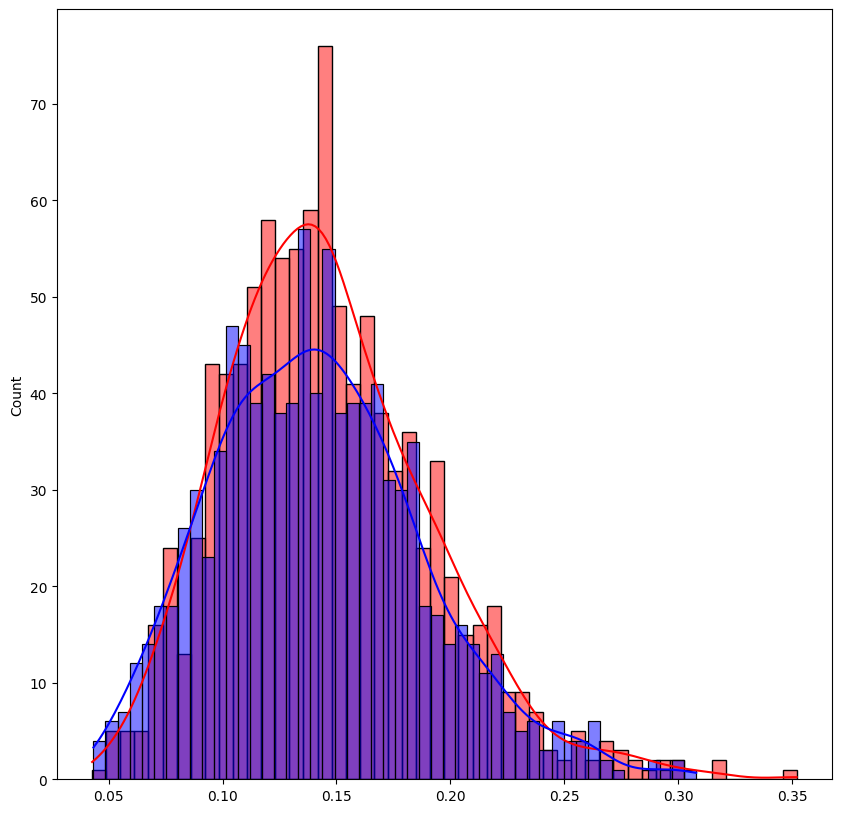

100%|██████████| 1000/1000 [01:11<00:00, 14.07it/s]


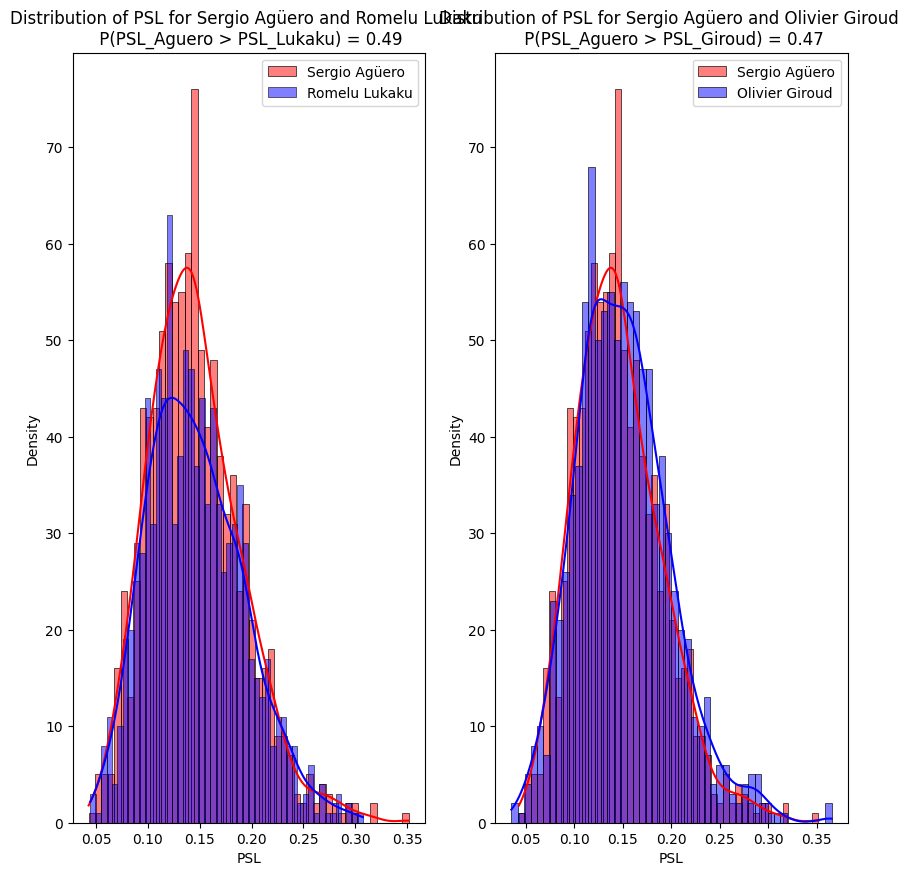

In [875]:
psls_lukaku = estimate_psl_distribution(
    1000,
    replace_player_in_list_players(
        list(np.array(top_11_team_players)[:, 0]), "Sergio Agüero", "Romelu Lukaku"
    ),
    player_kdes,
)

psls_giroud = estimate_psl_distribution(
    1000,
    replace_player_in_list_players(
        list(np.array(top_11_team_players)[:, 0]), "Sergio Agüero", "Olivier Giroud"
    ),
    player_kdes,
)

p_greater_lukaku = probability_psl_greater_than(psls, psls_lukaku)
p_greater_giroud = probability_psl_greater_than(psls, psls_giroud)


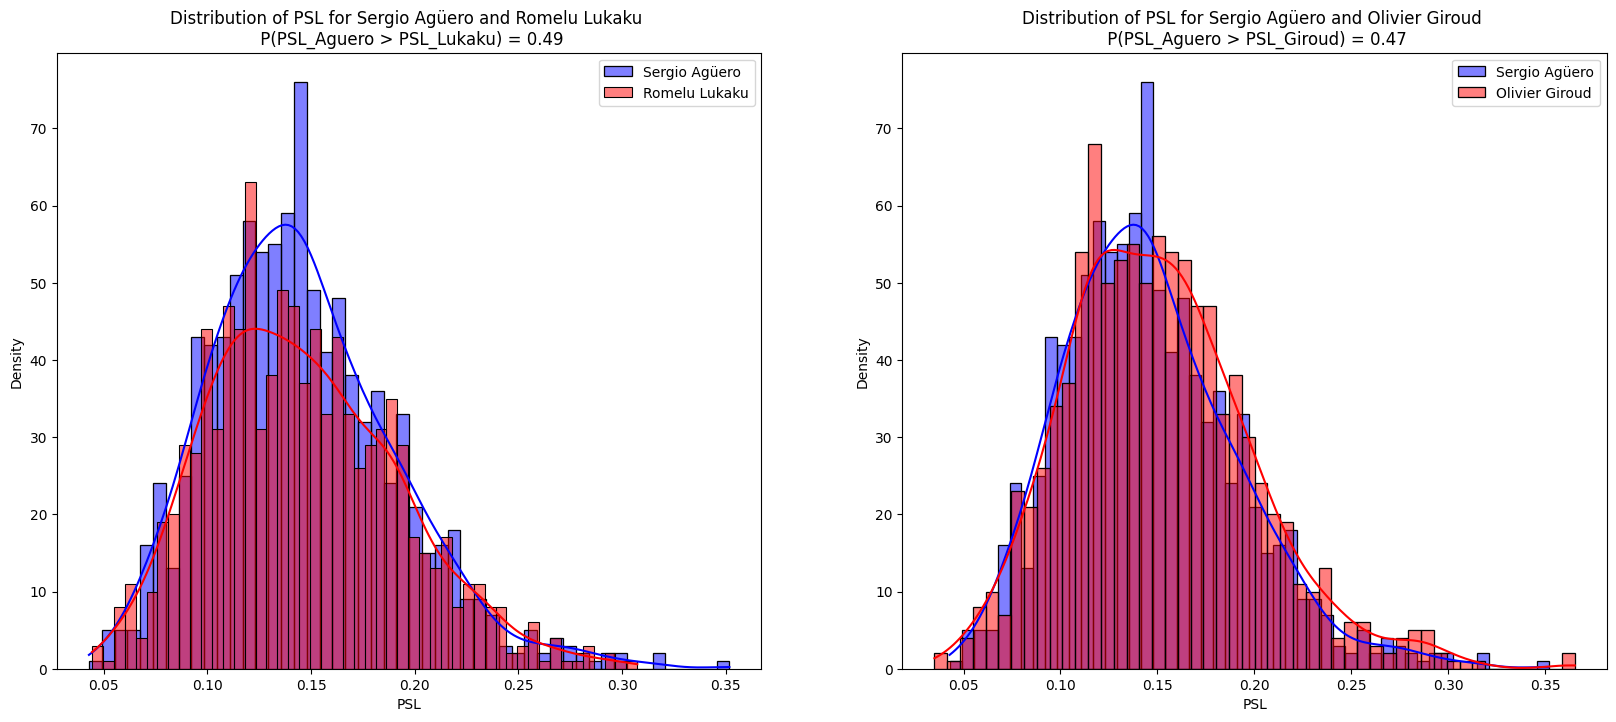

In [900]:
fig, axs = plt.subplots(1, 2, figsize=(20, 8))

sns.histplot(
    psls,
    kde=True,
    color="b",
    alpha=0.5,
    bins=psl_sample_counts // 20,
    ax=axs[0],
    label="Sergio Agüero",
)
sns.histplot(
    psls_lukaku,
    kde=True,
    color="r",
    alpha=0.5,
    bins=psl_sample_counts // 20,
    ax=axs[0],
    label="Romelu Lukaku",
)

axs[0].set_title(
    f"Distribution of PSL for Sergio Agüero and Romelu Lukaku \n P(PSL_Aguero > PSL_Lukaku) = {p_greater_lukaku:.2f}"
)
axs[0].set_xlabel("PSL")
axs[0].set_ylabel("Density")
axs[0].legend()

sns.histplot(
    psls,
    kde=True,
    color="b",
    alpha=0.5,
    bins=psl_sample_counts // 20,
    ax=axs[1],
    label="Sergio Agüero",
)

sns.histplot(
    psls_giroud,
    kde=True,
    color="r",
    alpha=0.5,
    bins=psl_sample_counts // 20,
    ax=axs[1],
    label="Olivier Giroud",
)

axs[1].set_title(
    f"Distribution of PSL for Sergio Agüero and Olivier Giroud \n P(PSL_Aguero > PSL_Giroud) = {p_greater_giroud:.2f}"
)

axs[1].set_xlabel("PSL")
axs[1].set_ylabel("Density")
axs[1].legend()

(0.0, 0.35)

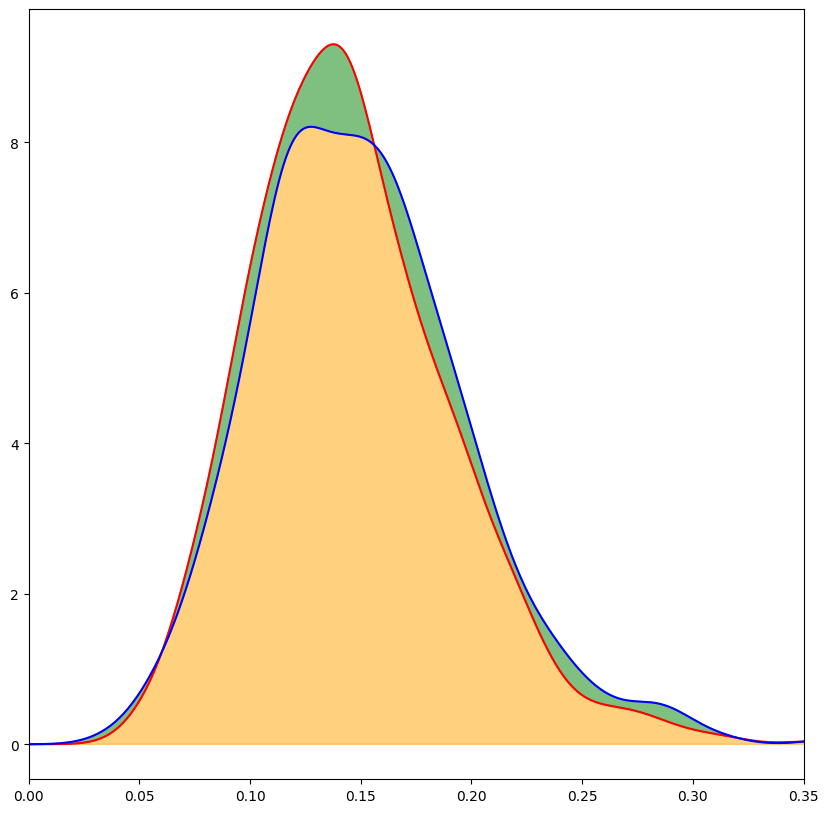

In [883]:
# KDE for psls and psls_giroud
psl_kde = gaussian_kde(psls)
psl_kde_giroud = gaussian_kde(psls_giroud)

Text(0.5, 1.0, 'Areas where psl_kde_aguero > psl_kde_giroud and psl_kde_giroud > psl_kde_aguero')

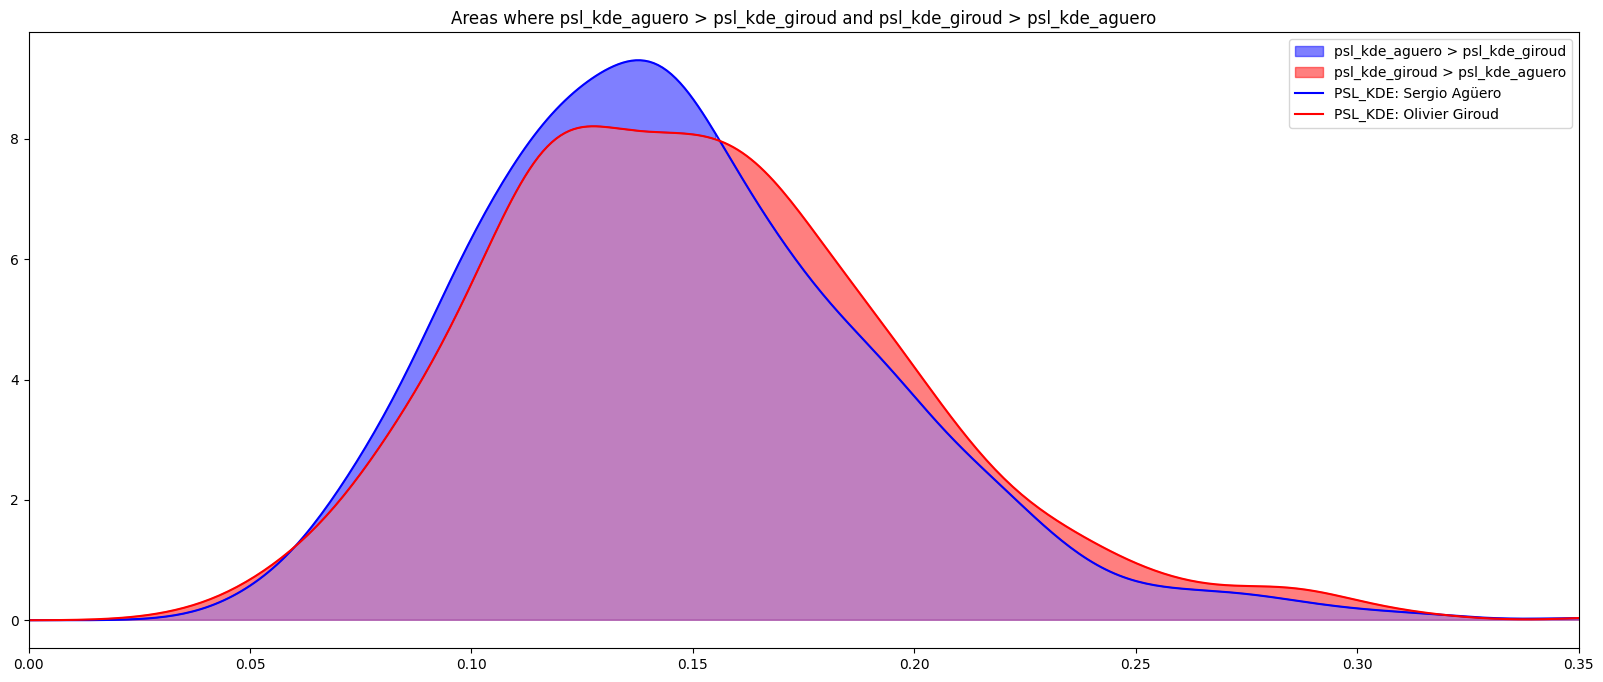

In [898]:
# Suponiendo que ya tienes las curvas KDE evaluadas en x
x = np.linspace(0, 1, 1000)
psl_kde_values = psl_kde.evaluate(x)
psl_kde_giroud_values = psl_kde_giroud.evaluate(x)

# Crear la figura y los ejes
fig, ax = plt.subplots(figsize=(20, 8))

# Rellenar las áreas donde psl_kde > psl_kde_giroud
ax.fill_between(
    x,
    psl_kde_values,
    psl_kde_giroud_values,
    where=(psl_kde_values > psl_kde_giroud_values),
    color="blue",
    alpha=0.5,
    label="psl_kde_aguero > psl_kde_giroud",
)

# Rellenar las áreas donde psl_kde_giroud > psl_kde
ax.fill_between(
    x,
    psl_kde_values,
    psl_kde_giroud_values,
    where=(psl_kde_values <= psl_kde_giroud_values),
    color="red",
    alpha=0.5,
    label="psl_kde_giroud > psl_kde_aguero",
)

# Rellenar el área donde psl_kde = psl_kde_giroud
x_fill = np.linspace(0, 1, 1000)
y_fill = np.minimum(psl_kde.evaluate(x_fill), psl_kde_giroud.evaluate(x_fill))

ax.fill_between(x_fill, y_fill, color="purple", alpha=0.5)

ax.plot(x, psl_kde.evaluate(x), color="b", label="PSL_KDE: Sergio Agüero")
ax.plot(x, psl_kde_giroud.evaluate(x), color="r", label="PSL_KDE: Olivier Giroud")

ax.set_xlim(0, 0.35)

# Añadir leyenda
ax.legend()

ax.set_title("Areas where psl_kde_aguero > psl_kde_giroud and psl_kde_giroud > psl_kde_aguero")